## Import Packages

In [1]:
pip install aif360 'aif360[Reductions]' 'aif360[inFairness]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.7/901.7 kB 40.8 MB/s eta 0:00:00


In [2]:
!pip install torch torchvision adjustText BlackBoxAuditing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 65.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394756 sha256=3c512b19edea9c107d94f81573fdf4282ff08c5f524d92f7ab4efb71a6d94b56
  Stored in directory: /root/.cache/pip/wheels/c5/b9/e9/152a447c23f9c30559676a9f4ecee5c7e9a36130d48176555c
Successfully built BlackBoxAuditing


In [3]:
# Data handling and preprocessing
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.inspection import permutation_importance

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from math import pi
from adjustText import adjust_text

# Machine Learning models
import os
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Boosting models
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Pytorch for NN (MLP)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array
from itertools import product

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [4]:
# Fairness Metrics and Analysis
# AIF360
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover, MetaFairClassifier

from fairlearn.reductions import DemographicParity, EqualizedOdds, ExponentiatedGradient
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, false_negative_rate
from sklearn.base import clone

/usr/local/lib/python3.12/dist-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/usr/local/lib/python3.12/dist-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_discounted

In [5]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

In [6]:
random_seed = 57
# PYTHON
os.environ['PYTHONHASHSEED'] = str(random_seed)
random.seed(random_seed)

# NUMPY
np.random.seed(random_seed)

# TENSORFLOW (TF 1.x session)
tf.compat.v1.set_random_seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
tf.set_random_seed(random_seed)

In [7]:
pip install ucimlrepo

In [8]:
from ucimlrepo import fetch_ucirepo

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Datasets

In [10]:
# Fetch dataset
dataset = fetch_ucirepo(id=697)

# Import data
X = dataset.data.features
y = dataset.data.targets

y['dropout'] = y['Target'].apply(lambda x: 0 if x == 'Dropout' else 1)
y.drop('Target', axis=1, inplace=True)
target = 'dropout'

data = pd.concat([X, y], axis=1)
data['age'] = data['Age at enrollment'].apply(lambda x: 0 if x > 25 else 1)
data.drop('Age at enrollment', axis=1, inplace=True)
data.head()

/tmp/ipython-input-1364869154.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['dropout'] = y['Target'].apply(lambda x: 0 if x == 'Dropout' else 1)
/tmp/ipython-input-1364869154.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.drop('Target', axis=1, inplace=True)


Marital Status  Application mode  Application order  Course  \
0               1                17                  5     171   
1               1                15                  1    9254   
2               1                 1                  5    9070   
3               1                17                  2    9773   
4               2                39                  1    8014   

   Daytime/evening attendance  Previous qualification  \
0                           1                       1   
1                           1                       1   
2                           1                       1   
3                           1                       1   
4                           0                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           122.0            1                      19   
1                           160.0            1                       1   
2                           122.0            1                      37   
3                           122.0            1                      38   
4                           100.0            1                      37   

   Father's qualification  ...  Curricular units 2nd sem (enrolled)  \
0                      12  ...                                    0   
1                       3  ...                                    6   
2                      37  ...                                    6   
3                      37  ...                                    6   
4                      38  ...                                    6   

   Curricular units 2nd sem (evaluations)  \
0                                       0   
1                                       6   
2                                       0   
3                                      10   
4                                       6   

   Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
0                                    0                          0.000000   
1                                    6                         13.666667   
2                                    0                          0.000000   
3                                    5                         12.400000   
4                                    6                         13.000000   

   Curricular units 2nd sem (without evaluations)  Unemployment rate  \
0                                               0               10.8   
1                                               0               13.9   
2                                               0               10.8   
3                                               0                9.4   
4                                               0               13.9   

   Inflation rate   GDP  dropout  age  
0             1.4  1.74        0    1  
1            -0.3  0.79        1    1  
2             1.4  1.74        0    1  
3            -0.8 -3.12        1    1  
4            -0.3  0.79        1    0  

[5 rows x 37 columns]

In [ ]:
# save data to drive
data.to_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/datasets/Student/Raw/Student_orig.csv')

### EDA

In [ ]:
X.head()

Marital Status  Application mode  Application order  Course  \
0               1                17                  5     171   
1               1                15                  1    9254   
2               1                 1                  5    9070   
3               1                17                  2    9773   
4               2                39                  1    8014   

   Daytime/evening attendance  Previous qualification  \
0                           1                       1   
1                           1                       1   
2                           1                       1   
3                           1                       1   
4                           0                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           122.0            1                      19   
1                           160.0            1                       1   
2                           122.0            1                      37   
3                           122.0            1                      38   
4                           100.0            1                      37   

   Father's qualification  ...  \
0                      12  ...   
1                       3  ...   
2                      37  ...   
3                      37  ...   
4                      38  ...   

   Curricular units 1st sem (without evaluations)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Curricular units 2nd sem (credited)  Curricular units 2nd sem (enrolled)  \
0                                    0                                    0   
1                                    0                                    6   
2                                    0                                    6   
3                                    0                                    6   
4                                    0                                    6   

   Curricular units 2nd sem (evaluations)  \
0                                       0   
1                                       6   
2                                       0   
3                                      10   
4                                       6   

   Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
0                                    0                          0.000000   
1                                    6                         13.666667   
2                                    0                          0.000000   
3                                    5                         12.400000   
4                                    6                         13.000000   

   Curricular units 2nd sem (without evaluations)  Unemployment rate  \
0                                               0               10.8   
1                                               0               13.9   
2                                               0               10.8   
3                                               0                9.4   
4                                               0               13.9   

   Inflation rate   GDP  
0             1.4  1.74  
1            -0.3  0.79  
2             1.4  1.74  
3            -0.8 -3.12  
4            -0.3  0.79  

[5 rows x 36 columns]

In [ ]:
X.columns

Index(['Marital Status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'International', 'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricu

In [ ]:
X.dtypes

Marital Status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Admission grade                                   float64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees up to date                             int64
Gender                                              int64
Scholarship holder                                  int64
International                                       int64
Curricular units 1st sem (credited)                 int64
Curricular units 1st sem (enrolled)                 int64
Curricular units 1st sem (evaluations)              int64
Curricular units 1st sem (approved)                 int64
Curricular units 1st sem (grade)                  float64
Curricular units 1st sem (without evaluations)      int64
Curricular units 2nd sem (credited)                 int64
Curricular units 2nd sem (enrolled)                 int64
Curricular units 2nd sem (evaluations)              int64
Curricular units 2nd sem (approved)                 int64
Curricular units 2nd sem (grade)                  float64
Curricular units 2nd sem (without evaluations)      int64
Unemployment rate                                 float64
Inflation rate                                    float64
GDP                                               float64
age                                                 int64
dtype: object

In [ ]:
X['Age at enrollment'].value_counts()

Age at enrollment
18    1036
19     911
20     599
21     322
22     174
24     131
23     108
26      94
25      93
27      91
28      83
29      66
32      61
34      60
31      55
35      49
30      49
33      45
37      42
39      38
36      35
41      31
38      29
43      25
40      23
45      22
44      21
47      18
50      16
42      13
49      13
46      12
48      11
51       7
54       7
53       7
55       5
17       5
52       4
58       3
59       3
60       2
57       2
70       1
61       1
62       1
Name: count, dtype: int64

In [ ]:
# Identify the age group which has high dropout (mean proportion closer to 0)
proportion_dropout = (
    data.groupby('Age at enrollment')['dropout']
    .mean()
    .reset_index()
    .rename(columns={'dropout': 'proportion_dropout'})
    .sort_values(by='proportion_dropout', ascending=False)  # Sort highest on top
)

print("Proportion of Dropout for Each Age (Ranked):")
print(proportion_dropout)

Proportion of Dropout for Each Age (Ranked):
    Age at enrollment  proportion_dropout
0                  17            1.000000
44                 62            1.000000
42                 60            1.000000
35                 52            1.000000
1                  18            0.805019
3                  20            0.777963
2                  19            0.772777
4                  21            0.711180
5                  22            0.666667
24                 41            0.645161
6                  23            0.620370
7                  24            0.572519
36                 53            0.571429
26                 43            0.560000
16                 33            0.555556
22                 39            0.526316
27                 44            0.523810
17                 34            0.516667
29                 46            0.500000
39                 57            0.500000
8                  25            0.494624
32                 49          

In [14]:
# Proportion of dropout (class 0) in y
data['dropout'].value_counts(normalize=True)

dropout
1    0.678797
0    0.321203
Name: proportion, dtype: float64

In [ ]:
# Identify the age group which has high dropout (mean proportion closer to 0)
proportion_dropout = (
    data.groupby('Gender')['dropout']
    .mean()
    .reset_index()
    .rename(columns={'dropout': 'proportion_dropout'})
    .sort_values(by='proportion_dropout', ascending=False)  # Sort highest on top
)

print("Proportion of Dropout for Each Gender (Ranked):")
print(proportion_dropout)

Proportion of Dropout for Each Gender (Ranked):
   Gender  proportion_dropout
0       0            0.748954
1       1            0.549486


## Data Integrity Check

In [ ]:
def check_data_integrity(df, target):
    """
    Check for data integrity issues such as missing values, duplicates, and outliers.
    """
    # Check for missing values
    missing_values = df.isnull().sum()
    print("Missing values in each column:\n", missing_values[missing_values > 0])

    # List out columns with missing or NA values
    missing_columns = df.columns[df.isna().any()].tolist()
    print("Columns with missing or NA values:")
    print(missing_columns)

    # Check for duplicates
    duplicates = df.duplicated().sum()
    print("Number of duplicate rows:", duplicates)

    # Check for unique values in categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    print("Unique values in categorical columns:")
    for col in categorical_columns:
        unique_values = df[col].unique()
        print(f"{col}: {len(unique_values)} unique values")

    # Check for class imbalance
    plt.figure(figsize=(4, 3))
    sns.countplot(x=target, data=df)
    plt.title('Class Distribution')
    plt.xlabel(target)
    plt.ylabel('Count')
    plt.show()

    # Check for outliers using boxplots
    num_numeric_cols = len(df.select_dtypes(include=[np.number]).columns)
    num_rows = (num_numeric_cols + 3) // 4  # Calculate rows needed
    plt.figure(figsize=(12, 8))
    for i, col in enumerate(df.select_dtypes(include=[np.number]).columns):
        plt.subplot(num_rows, 4, i + 1)  # Adjust subplot grid
        sns.boxplot(x=df[col])
        plt.title(col)
    plt.tight_layout()
    plt.show()

    '''
    # Show all feature distribution
    plt.figure(figsize=(12, 6))
    for i, col in enumerate(df.select_dtypes(include=[np.number]).columns):
        plt.subplot(2, 4, i + 1)
        sns.histplot(df[col], kde=True)
        plt.title(col)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    '''

    # Show feature distribution by income
    plt.figure(figsize=(12, 8))
    for i, col in enumerate(df.select_dtypes(include=[np.number]).columns):
        plt.subplot(num_rows, 4, i + 1)  # Adjust subplot grid to accommodate more columns
        sns.histplot(df[df[target] == 0][col], kde=True, label='Target Value = 0', color='blue', alpha=0.5)
        sns.histplot(df[df[target] == 1][col], kde=True, label='Target Value = 1', color='red', alpha=0.5)
        plt.title(col)
        plt.xlabel('Value')


Missing values in each column:
 Series([], dtype: int64)
Columns with missing or NA values:
[]
Number of duplicate rows: 47
Unique values in categorical columns:
workclass: 7 unique values
education: 16 unique values
marital-status: 7 unique values
occupation: 14 unique values
relationship: 6 unique values
native-country: 41 unique values


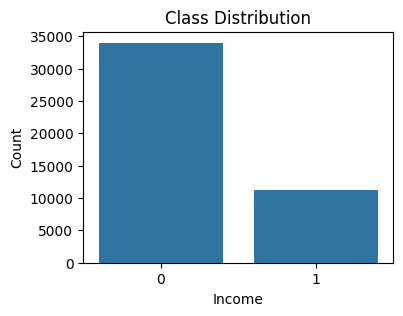

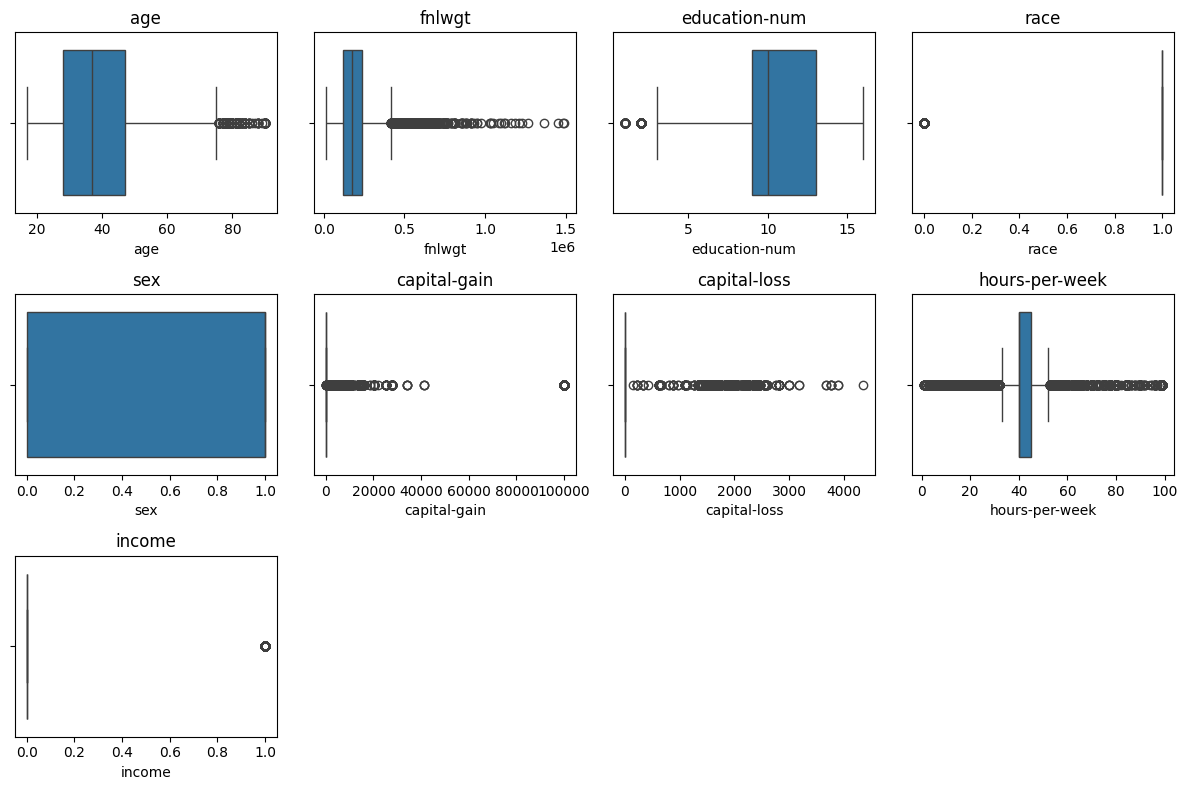

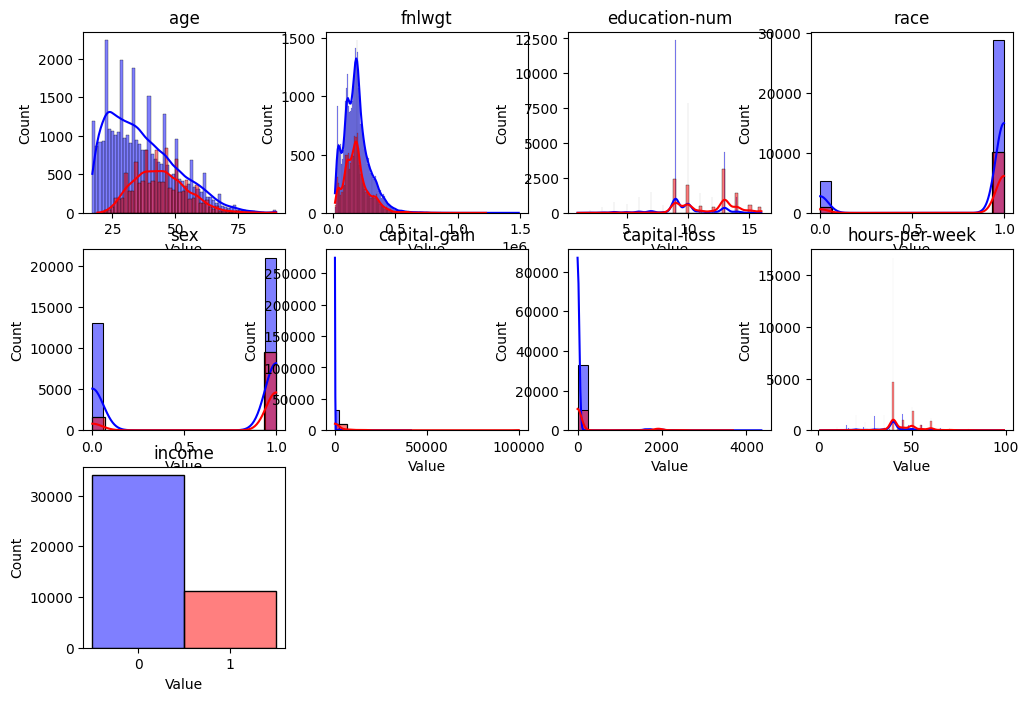

In [ ]:
check_data_integrity(data, target)

## Preprocessing

In [ ]:
def data_preprocessing(data, target):
    X = data.drop(target, axis=1)
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = data_preprocessing(data, target)

## MODEL SELECTION & FAIRNESS EVALUATION

In [ ]:
sensitive_feature = 'age'

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2)  # Binary classification with 2 logits

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # Raw logits

class PyTorchMLPWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim=10, hidden_dim=64, lr=0.001, epochs=20, batch_size=64, random_state=42):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self._build_model()

    def _set_seed(self):
        seed = self.random_state
        os.environ['PYTHONHASHSEED'] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    def _build_model(self):
        self.model = SimpleMLP(self.input_dim, self.hidden_dim)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def fit(self, X, y, sample_weight=None):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.longlong)
        X, y = check_X_y(X, y)
        self._build_model()

        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y, dtype=torch.long).to(self.device)
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)

        if sample_weight is not None:
            sw_tensor = torch.tensor(sample_weight, dtype=torch.float32).to(self.device)
        else:
            sw_tensor = torch.ones(len(X_tensor)).to(self.device)

        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss(reduction='none')

        for epoch in range(self.epochs):
            self.model.train()
            for i in range(0, len(X_tensor), self.batch_size):
                x_batch = X_tensor[i:i+self.batch_size]
                y_batch = y_tensor[i:i+self.batch_size]
                sw_batch = sw_tensor[i:i+self.batch_size]

                optimizer.zero_grad()
                logits = self.model(x_batch)
                loss = criterion(logits, y_batch)
                loss = (loss * sw_batch).mean()
                loss.backward()
                optimizer.step()

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)
        X = check_array(X)
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            logits = self.model(X_tensor)
            preds = torch.argmax(logits, dim=1)
        return preds.cpu().numpy().ravel()

    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float32)
        X = check_array(X)
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            logits = self.model(X_tensor)
            probs = F.softmax(logits, dim=1)
        probs = probs.cpu().numpy()
        return probs

In [ ]:
# Dictionary of models
models = {
    "LR": LogisticRegression(max_iter=2000, random_state=random_seed),
    "NB": GaussianNB(),
    "RF": RandomForestClassifier(random_state=random_seed),
    "DT": DecisionTreeClassifier(random_state=random_seed),
    "XGB": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_seed),
    "LGBM": LGBMClassifier(random_state=random_seed),
    "GBM": GradientBoostingClassifier(random_state=random_seed),
    "MLP": PyTorchMLPWrapper(input_dim=X_train.shape[1])
}

In [ ]:
param_grid = {
    "NB": {
        'var_smoothing': [1e-9, 1e-8, 1e-7]
    },
    "LR": {
        'C': [0.1, 1, 10],
        'penalty': ['l2', 'l1'],
        'solver': ['liblinear', 'saga']
    },
    "RF": {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30],
        #'min_samples_split': [2, 5, 10],
        #'min_samples_leaf': [1, 2, 4]
    },
    "DT": {
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        #'min_samples_leaf': [1, 2, 4]
    },
    "XGB": {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1]
    },
    "LGBM": {
        'n_estimators': [50, 100],
        'max_depth': [10, 20],
        'learning_rate': [0.01, 0.1]
    },
    "GBM": {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    "MLP": {
        'hidden_dim': [32, 64],
        'lr': [0.001, 0.01],
        'epochs': [10, 20]
    }
}


### Combined Functions

In [ ]:
#Use This (FINAL)
def train_evaluate_plot(models, param_grid, X_train, y_train, X_test, y_test, target, sensitive_feature):
    results = {}

    test_splits = np.array_split(np.arange(len(X_test)), 3)

    param_combinations = list(product(*param_grid['MLP'].values()))
    param_names = list(param_grid['MLP'].keys())

    for name, model in models.items():
        if name != 'MLP':
            pipe = ImbPipeline([
                ('scaler', MinMaxScaler()),
                ('clf', model)
            ])
            updated_param_grid = {f"clf__{key}": value for key, value in param_grid[name].items()}
            cv = GridSearchCV(pipe, updated_param_grid, cv=5, scoring='f1', return_train_score=True, n_jobs=-1)
            cv.fit(X_train, y_train)
            best_model = cv.best_estimator_

            cv_results = cv.cv_results_
            train_cv_score = np.mean(cv_results['mean_train_score'])
            val_cv_score = np.mean(cv_results['mean_test_score'])

            acc_list, f1_list, roc_list = [], [], []
            sp_list, eo_list, eodd_list, aod_list = [], [], [], []
            tpr_list, fpr_list, fnr_list = [], [], []

            for split in test_splits:
                X_split = X_test.iloc[split]
                y_split = y_test.iloc[split]

                y_pred = best_model.predict(X_split)
                y_prob = best_model.predict_proba(X_split)[:, 1]

                acc_list.append(accuracy_score(y_split, y_pred))
                f1_list.append(f1_score(y_split, y_pred))
                roc_list.append(roc_auc_score(y_split, y_prob))

                true_df = X_split.copy()
                true_df[target] = y_split.values
                pred_df = X_split.copy()
                pred_df[target] = y_pred

                true_dataset = BinaryLabelDataset(df=true_df, label_names=[target], protected_attribute_names=[sensitive_feature])
                pred_dataset = BinaryLabelDataset(df=pred_df, label_names=[target], protected_attribute_names=[sensitive_feature])

                metric = ClassificationMetric(true_dataset, pred_dataset,
                                              unprivileged_groups=[{sensitive_feature: 0}],
                                              privileged_groups=[{sensitive_feature: 1}])

                sp_list.append(metric.statistical_parity_difference())
                eo_list.append(metric.equal_opportunity_difference())
                eodd_list.append(metric.equalized_odds_difference())
                aod_list.append(metric.average_odds_difference())

                tpr_list.append(metric.true_positive_rate())
                fpr_list.append(metric.false_positive_rate())
                fnr_list.append(metric.false_negative_rate())

            results[name] = {
                'train_cv_f1': train_cv_score,
                'val_cv_f1': val_cv_score,
                'accuracy': np.mean(acc_list),
                'f1': np.mean(f1_list),
                'roc_auc': np.mean(roc_list),
                'stat_parity': np.mean(sp_list),
                'equal_opp': np.mean(eo_list),
                'equal_odds': np.mean(eodd_list),
                'avg_odds_diff': np.mean(aod_list),
                'tpr': np.mean(tpr_list),
                'fpr': np.mean(fpr_list),
                'fnr': np.mean(fnr_list),
                'best_model': best_model
            }

        else:
            # Manual CV for PyTorch MLP
            scaler = MinMaxScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            X_np = X_train_scaled
            y_np = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train

            best_score = -1
            best_params = None

            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            for values in param_combinations:
                params = dict(zip(param_names, values))
                fold_scores = []

                for train_idx, val_idx in skf.split(X_np, y_np):
                    X_fold_train, X_fold_val = X_np[train_idx], X_np[val_idx]
                    y_fold_train, y_fold_val = y_np[train_idx], y_np[val_idx]

                    model = PyTorchMLPWrapper(
                        input_dim=X_np.shape[1],
                        hidden_dim=params['hidden_dim'],
                        lr=params['lr'],
                        epochs=params['epochs']
                    )
                    model.fit(X_fold_train, y_fold_train)
                    y_pred = model.predict(X_fold_val)
                    fold_scores.append(f1_score(y_fold_val, y_pred))

                avg_score = np.mean(fold_scores)
                if avg_score > best_score:
                    best_score = avg_score
                    best_params = params

            best_model = PyTorchMLPWrapper(
                input_dim=X_np.shape[1],
                hidden_dim=best_params['hidden_dim'],
                lr=best_params['lr'],
                epochs=best_params['epochs']
            )
            best_model.fit(X_np, y_np)
            train_cv_score = val_cv_score = best_score

            acc_list, f1_list, roc_list = [], [], []
            sp_list, eo_list, eodd_list, aod_list = [], [], [], []
            tpr_list, fpr_list, fnr_list = [], [], []

            for split in test_splits:
                X_split = pd.DataFrame(X_test_scaled[split], columns=X_test.columns)
                y_split = y_test.iloc[split]

                y_pred = best_model.predict(X_split)
                y_prob = best_model.predict_proba(X_split)[:, 1]

                acc_list.append(accuracy_score(y_split, y_pred))
                f1_list.append(f1_score(y_split, y_pred))
                roc_list.append(roc_auc_score(y_split, y_prob))

                true_df = X_split.copy()
                true_df[target] = y_split.values
                pred_df = X_split.copy()
                pred_df[target] = y_pred

                true_dataset = BinaryLabelDataset(df=true_df, label_names=[target], protected_attribute_names=[sensitive_feature])
                pred_dataset = BinaryLabelDataset(df=pred_df, label_names=[target], protected_attribute_names=[sensitive_feature])

                metric = ClassificationMetric(true_dataset, pred_dataset,
                                              unprivileged_groups=[{sensitive_feature: 0}],
                                              privileged_groups=[{sensitive_feature: 1}])

                sp_list.append(metric.statistical_parity_difference())
                eo_list.append(metric.equal_opportunity_difference())
                eodd_list.append(metric.equalized_odds_difference())
                aod_list.append(metric.average_odds_difference())

                tpr_list.append(metric.true_positive_rate())
                fpr_list.append(metric.false_positive_rate())
                fnr_list.append(metric.false_negative_rate())

            results[name] = {
                'train_cv_f1': train_cv_score,
                'val_cv_f1': val_cv_score,
                'accuracy': np.mean(acc_list),
                'f1': np.mean(f1_list),
                'roc_auc': np.mean(roc_list),
                'stat_parity': np.mean(sp_list),
                'equal_opp': np.mean(eo_list),
                'equal_odds': np.mean(eodd_list),
                'avg_odds_diff': np.mean(aod_list),
                'tpr': np.mean(tpr_list),
                'fpr': np.mean(fpr_list),
                'fnr': np.mean(fnr_list),
                'best_model': best_model
            }

    results_df = pd.DataFrame(results).T.sort_values(by='f1', ascending=False)

    metrics_df = results_df[['train_cv_f1', 'val_cv_f1', 'accuracy', 'f1', 'roc_auc']].astype(float)
    plt.figure(figsize=(6, 5))
    sns.heatmap(metrics_df, annot=True, fmt=".2f", cmap='YlGnBu')
    plt.title("Model Performance Comparison")
    plt.xlabel("Metric")
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()

    fairness_metrics = ['stat_parity', 'equal_opp', 'equal_odds', 'avg_odds_diff', 'tpr', 'fpr', 'fnr']
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    plt.suptitle('Fairness Metrics and Rates Comparison')
    axes = axes.flatten()

    for i, metric in enumerate(fairness_metrics):

        sns.barplot(x=results_df.index, y=metric, data=results_df, ax=axes[i])
        axes[i].set_title(metric.replace('_', ' ').title())
        axes[i].set_xlabel('Model')
        axes[i].set_ylabel(metric.replace('_', ' ').title())
        if metric in ['stat_parity', 'equal_opp', 'equal_odds']:
            axes[i].axhline(0, linestyle='--', color='gray')

    for j in range(len(fairness_metrics), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    perf_metrics = ['accuracy', 'f1', 'roc_auc']
    fair_metrics = ['stat_parity', 'equal_opp', 'equal_odds', 'avg_odds_diff']

    perf_norm = results_df[perf_metrics] / results_df[perf_metrics].max()
    fair_norm = 1 - results_df[fair_metrics].abs() / results_df[fair_metrics].abs().max()

    def radar_chart(data_norm, title, metrics, subplot_idx):
        N = len(metrics)
        angles = [n / float(N) * 2 * pi for n in range(N)] + [0]
        ax = plt.subplot(1, 2, subplot_idx, polar=True)
        for model in data_norm.index:
            values = data_norm.loc[model].tolist() + [data_norm.loc[model].tolist()[0]]
            ax.plot(angles, values, label=model)
            ax.fill(angles, values, alpha=0.1)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metrics)
        ax.set_title(title, size=13)

    plt.figure(figsize=(14, 6))
    radar_chart(perf_norm, 'Performance Metrics (Higher = Better)', perf_metrics, 1)
    radar_chart(fair_norm, 'Fairness Metrics (Higher = Fairer)', fair_metrics, 2)

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(results_df.index))
    plt.tight_layout()
    plt.show()

    return results, results_df

In [ ]:
def pareto_plot(df):
    # Plot Pareto grid (F1 vs AOD)
    plt.figure(figsize=(8, 5))

    # Use 1 - |AOD| as fairness score
    x = 1 - abs(df['avg_odds_diff'])
    y = df['f1']
    labels = df.index

    # Optional: color by another metric (e.g., accuracy)
    colors = df['accuracy']

    # Use seaborn for better style
    sns.set(style="whitegrid")

    # Scatter plot with colormap
    scatter = plt.scatter(x, y, c=colors, cmap='viridis', s=100, edgecolor='k')

    # Prepare text labels
    texts = []
    for i, label in enumerate(labels):
        texts.append(plt.text(x.iloc[i]+0.002, y.iloc[i], label, fontsize=9, ha='left', va='center'))

    # Auto-adjust labels to avoid overlap
    adjust_text(
        texts,
        only_move={'points': 'y', 'texts': 'xy'},  # allow smarter repositioning
        arrowprops=dict(arrowstyle="-", color='gray', lw=0.5)
    )

    # Axes and title
    plt.xlabel('1 - |Average Odds Difference| (Higher = Fairer)', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.title('Fairness–Performance Trade-off Across Models', fontsize=14)

    # Colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Accuracy', rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:57:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 2402, number of negative: 1137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1238
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.678723 -> initscore=0.747909
[LightGBM] [Info] Start training from score 0.747909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

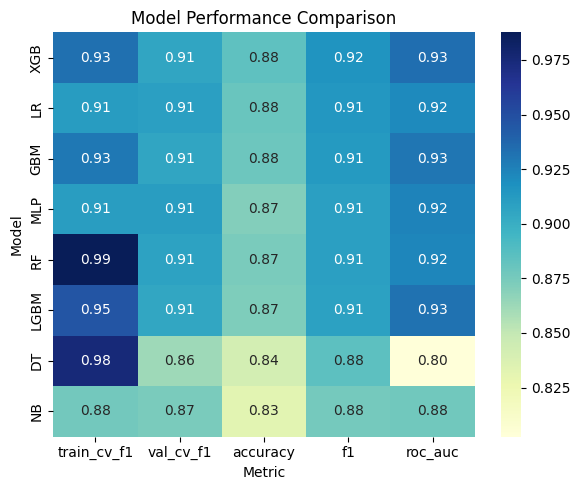

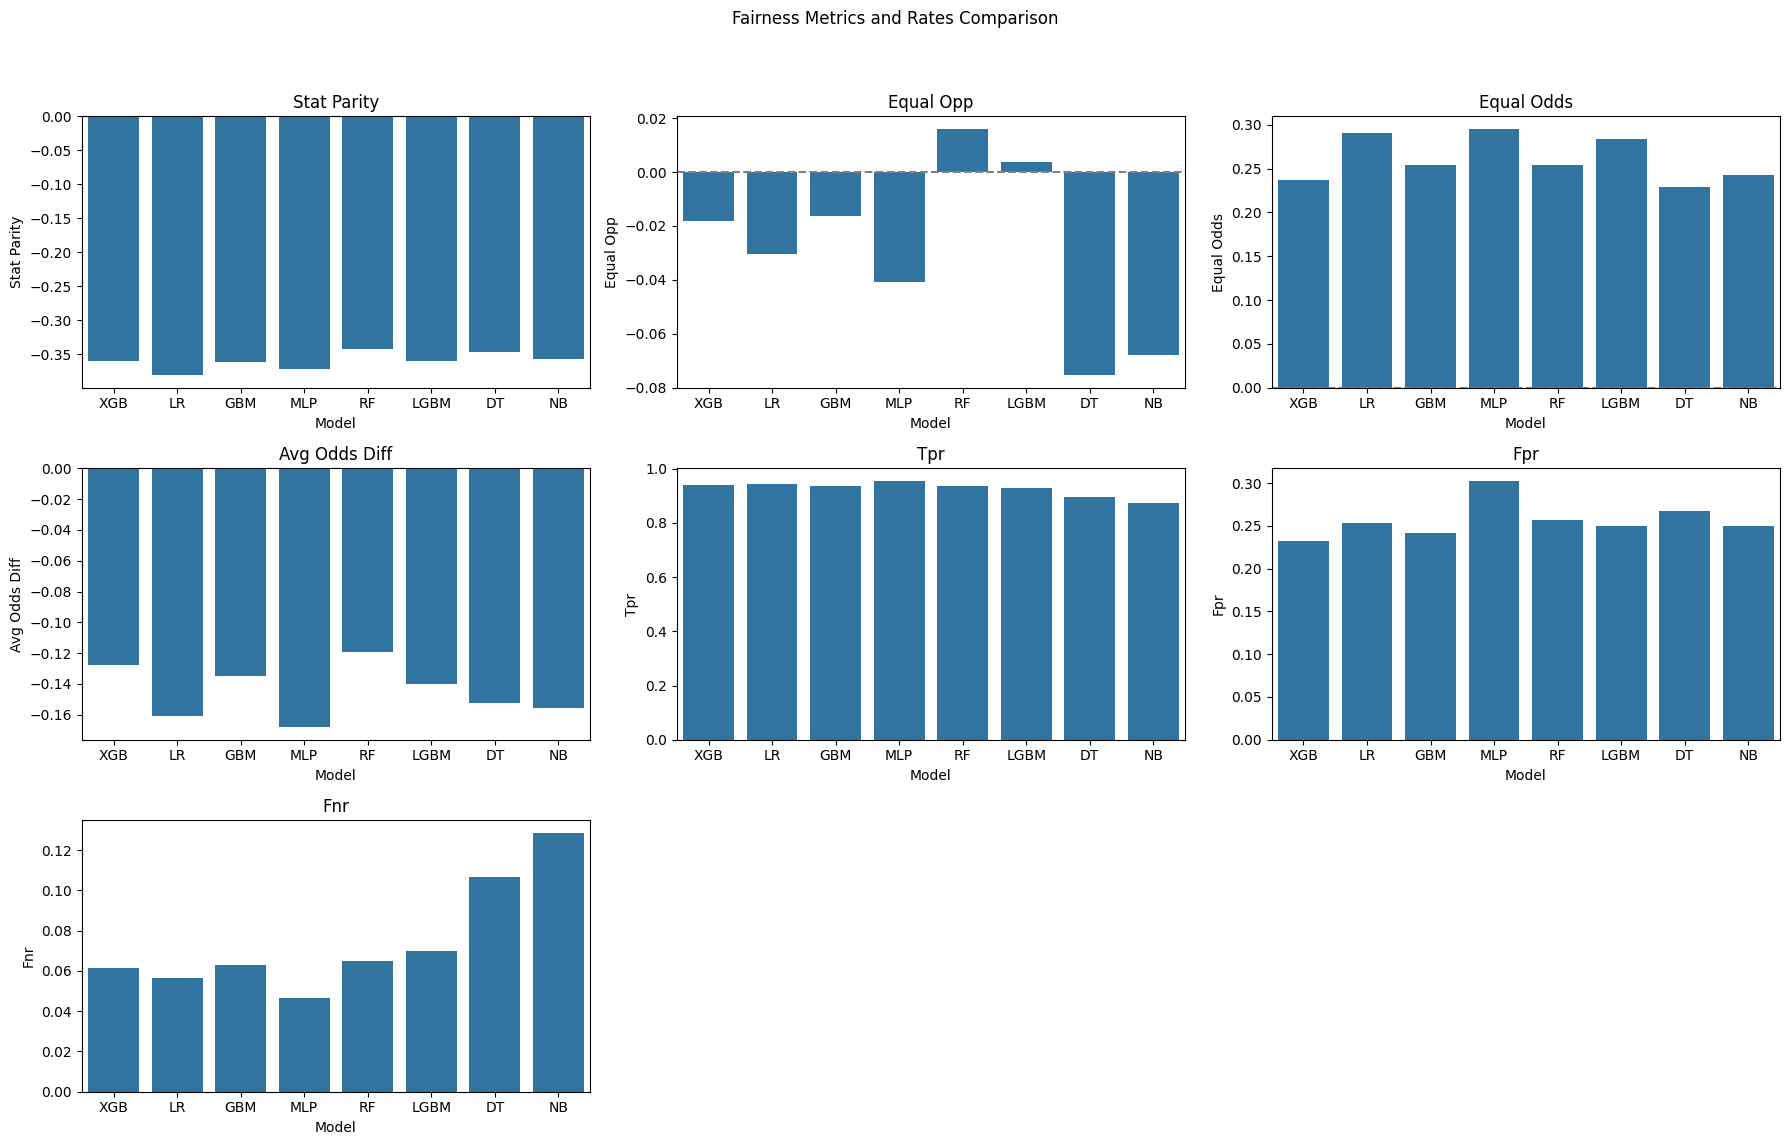

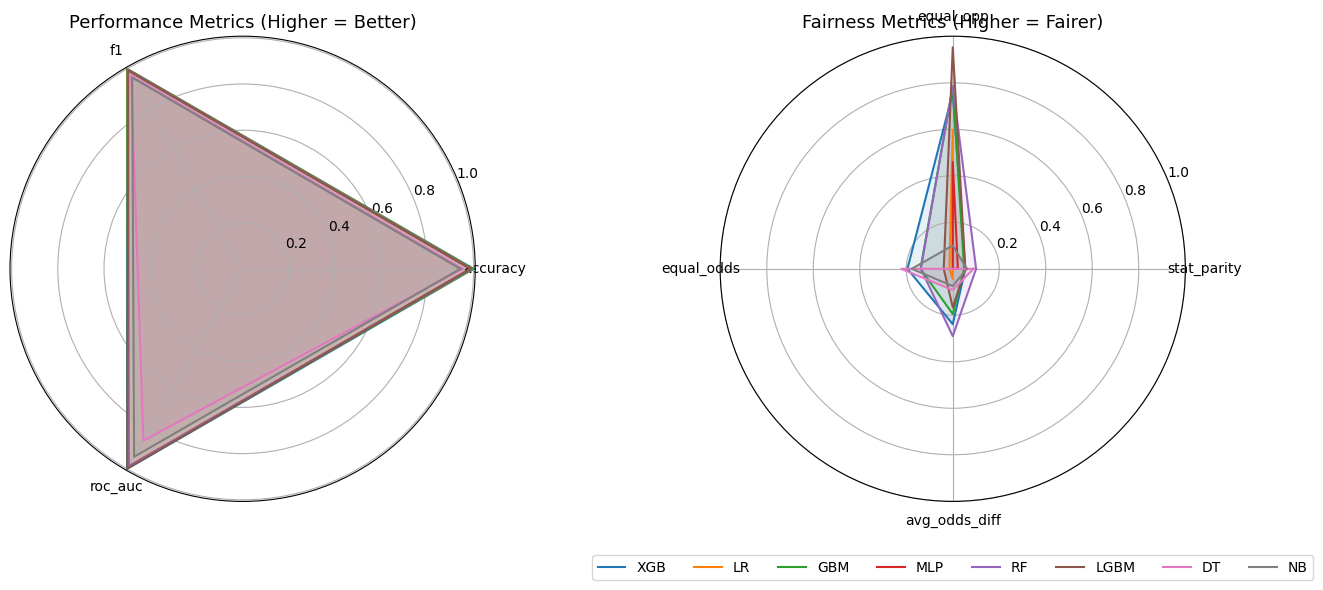

In [ ]:
results_dict, results_df = train_evaluate_plot(models, param_grid, X_train, y_train, X_test, y_test, target, sensitive_feature)

In [ ]:
results_df

train_cv_f1 val_cv_f1  accuracy        f1   roc_auc stat_parity  \
XGB     0.932991  0.905953  0.883616  0.916241  0.934141   -0.359406   
LR      0.911493  0.909025  0.880226  0.914488  0.921196   -0.379945   
GBM     0.929735  0.905533  0.879096  0.913118  0.929903   -0.361339   
MLP     0.910779  0.910779  0.871186  0.909437  0.924524   -0.371549   
RF      0.987662  0.907989  0.873446  0.909174  0.923149   -0.341786   
LGBM    0.946441  0.905082  0.872316   0.90813  0.932147   -0.359434   
DT      0.975055  0.861948  0.841808  0.884614  0.802557   -0.346118   
NB      0.876411  0.873899  0.832768   0.87605  0.877744   -0.356864   

     equal_opp equal_odds avg_odds_diff       tpr       fpr       fnr  \
XGB  -0.018353   0.237435     -0.127894  0.938614  0.231966  0.061386   
LR   -0.030339   0.290735     -0.160537  0.943524  0.253107  0.056476   
GBM  -0.016381   0.253986     -0.135183  0.936972  0.242093  0.063028   
MLP   -0.04078    0.29496      -0.16787  0.953375  0.302337  0.046625   
RF    0.016082   0.254476     -0.119197  0.934996  0.256798  0.065004   
LGBM   0.00354   0.283489     -0.139974  0.930171  0.249484  0.069829   
DT   -0.075481   0.229564     -0.152523  0.893485  0.267359  0.106515   
NB   -0.067917   0.242862     -0.155389  0.871687  0.249995  0.128313   

                                             best_model  
XGB   (MinMaxScaler(), XGBClassifier(base_score=None...  
LR    (MinMaxScaler(), LogisticRegression(C=1, max_i...  
GBM   (MinMaxScaler(), ([DecisionTreeRegressor(crite...  
MLP   PyTorchMLPWrapper(hidden_dim=32, input_dim=36,...  
RF    (MinMaxScaler(), (DecisionTreeClassifier(max_d...  
LGBM  (MinMaxScaler(), LGBMClassifier(max_depth=10, ...  
DT    (MinMaxScaler(), DecisionTreeClassifier(max_de...  
NB                       (MinMaxScaler(), GaussianNB())

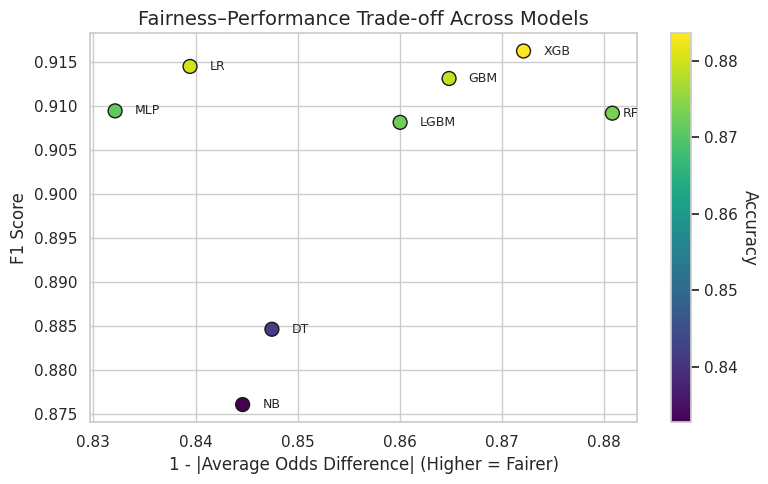

In [ ]:
pareto_plot(results_df)

In [ ]:
# Export the results DataFrame to a CSV file
results_df.to_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/Student/Student_age_original_models.csv')

## Fairness Mitigation

In [ ]:
# Define weights for each metric (tune these based on priority)
w_f1 = 0.5        # Equal weightage between performance and fairness
w_spd = 0.25      # Equal weightage for the 4 fairness metrics
w_eod = 0.25
w_eopp = 0.25
w_aod = 0.25

# Scoring function: higher is better
def composite_score(result):
    f1 = result['f1']
    spd = abs(result['stat_parity'])  # smaller is better → we subtract from 1
    eod = abs(result['equal_odds'])
    eopp = abs(result['equal_opp'])
    aod = abs(result['avg_odds_diff'])

    # Combine the fairness scores into 1 with equal weightage and invert it (higher better)
    fairness_score = 1 - (w_spd * spd + w_eod * eod + w_eopp * eopp + w_aod * aod)
    return w_f1 * f1 + (1 - w_f1) * fairness_score

In [ ]:
# Select model with highest composite score
best_name = max(results_dict, key=lambda x: composite_score(results_dict[x]))
best_model = results_dict[best_name]['best_model']

print(f"Balanced Best Model: {best_name}")

# Check if it's a pipeline
if isinstance(best_model, Pipeline):
    print("Model parameters:")
    print(best_model.named_steps['clf'].get_params())
else:
    print("Model parameters:")
    print(best_model.get_params())

Balanced Best Model: XGB
Model parameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 57, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}


### Fairness Constraints Functions

####Useful functions

In [ ]:
class MultiLevelReweighing:
    """MultiLevelReweighing is a preprocessing technique that Weights the examples in each
    (group, label) combination differently to ensure fairness before
    classification .This technique can compute the protected level of every sample , and then it can
    give every sample a new weight.
    """

    def __init__(self, unprivileged_groups, privileged_groups):
        """
        Args:
            unprivileged_groups (list(dict)): Representation for unprivileged group.
            privileged_groups (list(dict)): Representation for privileged group.
            such as:
            [{'feature_name':'sex','privileged_value':1,'level':2},
            {'feature_name':'race','privileged_value':1,'level':1}]
        """

        self.unprivileged_groups = unprivileged_groups
        self.privileged_groups = privileged_groups
        self.protect_feature_count = len(self.privileged_groups)
        self.w_p_fav = 1.0
        self.w_p_unfav = 1.0
        self.w_up_fav = 1.0
        self.w_up_unfav = 1.0

    def fit(self, dataset):
        """Compute the weights for reweighing the dataset.

        Args:
            dataset (BinaryLabelDataset): Dataset containing true labels.

        Returns:
            MultiLevelReweighing: Returns self.
        """

        (
            protect_level_dic,
            fav_cond,
            unfav_cond,
            combination_p_fav_dic,
        ) = self._obtain_conditionings(dataset)

        level_max = 0
        for group in self.privileged_groups:
            level_max = level_max + group["level"]
        n = np.sum(dataset.instance_weights, dtype=np.float64)
        n_p_level_dic = {}
        # weight:[1,2,1,1,2]
        #'n_p1':2
        for level in range(0, level_max + 1):
            n_p_level_dic["n_p" + str(level)] = np.sum(
                dataset.instance_weights[
                    protect_level_dic["protect_level" + str(level) + "_cond"]
                ],
                dtype=np.float64,
            )

        n_fav = np.sum(dataset.instance_weights[fav_cond], dtype=np.float64)
        n_unfav = np.sum(dataset.instance_weights[unfav_cond], dtype=np.float64)

        n_p_level_fav_or_unfav_dic = {}
        # "n_p1_unfav":3
        for level in range(0, level_max + 1):
            n_p_level_fav_or_unfav_dic["n_p" + str(level) + "_fav"] = np.sum(
                dataset.instance_weights[
                    combination_p_fav_dic["cond_p" + str(level) + "_fav"]
                ],
                dtype=np.float64,
            )
            n_p_level_fav_or_unfav_dic["n_p" + str(level) + "_unfav"] = np.sum(
                dataset.instance_weights[
                    combination_p_fav_dic["cond_p" + str(level) + "_unfav"]
                ],
                dtype=np.float64,
            )

        self.w_p_level_fav_or_unfav_dic = {}

        # reweighing weights
        # dataset.instance_weights
        # "w_p3_fav":3
        for level in range(0, level_max + 1):
            self.w_p_level_fav_or_unfav_dic["w_p" + str(level) + "_fav"] = (
                n_fav
                * n_p_level_dic["n_p" + str(level)]
                / (n * n_p_level_fav_or_unfav_dic["n_p" + str(level) + "_fav"])
            )
            self.w_p_level_fav_or_unfav_dic["w_p" + str(level) + "_unfav"] = (
                n_unfav
                * n_p_level_dic["n_p" + str(level)]
                / (n * n_p_level_fav_or_unfav_dic["n_p" + str(level) + "_unfav"])
            )

        return self

    def transform(self, dataset):
        """Transform the dataset to a new dataset based on the estimated
        transformation.

        Args:
            dataset (BinaryLabelDataset): Dataset that needs to be transformed.
        Returns:
            dataset (BinaryLabelDataset): Dataset with transformed
                instance_weights attribute.
        """
        protect_level_dic = {}
        level_max = 0
        for group in self.privileged_groups:
            level_max = level_max + group["level"]
        dataset_transformed = dataset.copy(deepcopy=True)

        (
            protect_level_dic,
            fav_cond,
            unfav_cond,
            combination_p_fav_dic,
        ) = self._obtain_conditionings(dataset)

        # apply reweighing
        for level in range(1 + level_max):
            dataset_transformed.instance_weights[
                combination_p_fav_dic["cond_p" + str(level) + "_fav"]
            ] *= self.w_p_level_fav_or_unfav_dic["w_p" + str(level) + "_fav"]
            dataset_transformed.instance_weights[
                combination_p_fav_dic["cond_p" + str(level) + "_unfav"]
            ] *= self.w_p_level_fav_or_unfav_dic["w_p" + str(level) + "_unfav"]

        return dataset_transformed

    ##############################
    #### Supporting functions ####
    ##############################
    def _obtain_conditionings(self, dataset):
        """Obtain the necessary conditioning boolean vectors to compute
        instance level weights.
        [{'feature_name':'sex','privileged_value':1,'level':2},
            {'feature_name':'race','privileged_value':1,'level':1}]
        """
        # conditioning

        protect_level_dic = {}
        level_max = 0
        for group in self.privileged_groups:
            level_max = level_max + group["level"]
        for i in range(0, level_max + 1):
            protect_level_dic["protect_level" + str(i) + "_cond"] = np.zeros(
                dataset.protected_attributes.shape[0], dtype=bool
            )
        #'protect_level3_cond':[0,1,0]
        #'protect_level2_cond':[0,0,1]
        # [
        #     [1,1],
        #     [0,1],
        #     [1,0],
        #     [0,0]
        # ]
        # ['sex','race']
        for sample_index in range(len(dataset.protected_attributes)):  # 3,5
            protect_feature = dataset.protected_attributes[sample_index]
            this_sample_protect_level = 0
            for group in self.privileged_groups:
                name = group["feature_name"]
                val = group["privileged_value"]
                level = group["level"]
                index = dataset.protected_attribute_names.index(name)
                if protect_feature[index] == val:
                    this_sample_protect_level = this_sample_protect_level + level  # 3
            protect_level_dic[
                "protect_level" + str(this_sample_protect_level) + "_cond"
            ][sample_index] = True
            # "protect_level" + str(3) + "_cond":[0,0,0,1,0]

        # [[1],[0],[1]],[1,0,1]
        fav_cond = dataset.labels.ravel() == dataset.favorable_label  # [0,0,1,1,0]
        unfav_cond = dataset.labels.ravel() == dataset.unfavorable_label  # [1,1,0,0,1]

        # combination of label and privileged/unpriv. groups
        combination_p_fav_dic = {}
        # "cond_p3_fav":[0,0,1,0,0]

        for i in range(0, level_max + 1):  # 3

            combination_p_fav_dic["cond_p" + str(i) + "_fav"] = np.logical_and(
                fav_cond, protect_level_dic["protect_level" + str(i) + "_cond"]
            )
            combination_p_fav_dic["cond_p" + str(i) + "_unfav"] = np.logical_and(
                unfav_cond, protect_level_dic["protect_level" + str(i) + "_cond"]
            )

        return (protect_level_dic, fav_cond, unfav_cond, combination_p_fav_dic)

In [ ]:
# NEW: Run all fairness method with gridsearch for hyperparameter
def run_all_fairness_methods(best_name, data, X_train, y_train, X_test, y_test, target, sensitive_feature, results_df, results_dict):
    combined_all = results_df.loc[[best_name]].copy()
    data = data.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)

    train_df = X_train.copy()
    train_df[target] = y_train.values
    test_df = X_test.copy()
    test_df[target] = y_test.values

    # Ensure sensitive features are included in the DataFrames used for BLD creation
    sensitive_features_list = ['Gender', 'age'] # Include both sex and race
    train_df_bld = train_df.copy()
    test_df_bld = test_df.copy()

    # Add sensitive features if they are not already present (after one-hot encoding)
    for sf in sensitive_features_list:
        if sf not in train_df_bld.columns and sf in data.columns: # Check if original data has the feature
             # This assumes original 'data' DataFrame has the sensitive feature before one-hot encoding
             train_df_bld[sf] = data.loc[train_df_bld.index, sf].values.astype(int)
             test_df_bld[sf] = data.loc[test_df_bld.index, sf].values.astype(int)
        elif sf in train_df_bld.columns:
             # If already present (e.g., not one-hot encoded), ensure correct type if needed
             train_df_bld[sf] = train_df_bld[sf].astype(int)
             test_df_bld[sf] = test_df_bld[sf].astype(int)


    train_bld = BinaryLabelDataset(df=train_df_bld, label_names=[target], protected_attribute_names=[sensitive_feature])
    test_bld = BinaryLabelDataset(df=test_df_bld, label_names=[target], protected_attribute_names=[sensitive_feature])


    # --- Reweighing ---
    rw = Reweighing(unprivileged_groups=[{sensitive_feature: 0}], privileged_groups=[{sensitive_feature: 1}])
    train_rw = rw.fit_transform(train_bld)
    X_rw = train_rw.features
    y_rw = train_rw.labels.ravel()
    weights = train_rw.instance_weights
    input_dim = X_rw.shape[1]

    if best_name=="MLP":
        # MLP model (custom PyTorch wrapper)
        model_rw = results_dict[best_name]['best_model']
        model_rw.fit(X_rw, y_rw)
    else:
        model_rw = ImbPipeline([
            ('scaler', MinMaxScaler()),
            ('clf', results_dict[best_name]['best_model'].named_steps['clf'])
        ])
        model_rw.fit(X_rw, y_rw, clf__sample_weight=weights)

    y_pred_rw = model_rw.predict(X_test)
    # Reconstruct prediction DataFrame with same structure as test_df_bld
    pred_df_rw = test_df_bld.copy()
    pred_df_rw[target] = y_pred_rw

    metric_rw = ClassificationMetric(test_bld, BinaryLabelDataset(df=pred_df_rw, label_names=[target], protected_attribute_names=[sensitive_feature]),
                                     unprivileged_groups=[{sensitive_feature: 0}], privileged_groups=[{sensitive_feature: 1}])

    RW_row = pd.Series({
        'accuracy': accuracy_score(y_test, y_pred_rw),
        'f1': f1_score(y_test, y_pred_rw),
        'roc_auc': roc_auc_score(y_test, model_rw.predict_proba(X_test)[:, 1]),
        'stat_parity': metric_rw.statistical_parity_difference(),
        'equal_opp': metric_rw.equal_opportunity_difference(),
        'equal_odds': metric_rw.equalized_odds_difference(),
        'avg_odds_diff': metric_rw.average_odds_difference(),
        'tpr': metric_rw.true_positive_rate(),
        'fpr': metric_rw.false_positive_rate(),
        'fnr': metric_rw.false_negative_rate(),
        'best_parameter': None,
        'best_model': model_rw
    }, name='RW')

    combined_all = pd.concat([combined_all, RW_row.to_frame().T], axis=0)

    # --- Prejudice Remover ---
    best_pr = None
    best_pr_row = None
    for eta in [1.0, 10.0, 25.0, 50.0, 100.0]:
        try:
            pr_model = PrejudiceRemover(sensitive_attr=sensitive_feature, eta=eta)
            pr_model.fit(train_bld)
            pred_pr = pr_model.predict(test_bld)
            y_pred_pr = pred_pr.labels.ravel()

            metric_pr = ClassificationMetric(test_bld, pred_pr,
                                            unprivileged_groups=[{sensitive_feature: 0}],
                                            privileged_groups=[{sensitive_feature: 1}])

            pr_row = pd.Series({
                'accuracy': accuracy_score(y_test, y_pred_pr),
                'f1': f1_score(y_test, y_pred_pr),
                'roc_auc': roc_auc_score(y_test, pred_pr.scores.ravel()),
                'stat_parity': metric_pr.statistical_parity_difference(),
                'equal_opp': metric_pr.equal_opportunity_difference(),
                'equal_odds': metric_pr.equalized_odds_difference(),
                'avg_odds_diff': metric_pr.average_odds_difference(),
                'tpr': metric_pr.true_positive_rate(),
                'fpr': metric_pr.false_positive_rate(),
                'fnr': metric_pr.false_negative_rate(),
                'best_parameter': eta,
                'best_model': pr_model
            }, name=f'PR_eta_{eta}')

            if best_pr_row is None or abs(pr_row['equal_opp']) < abs(best_pr_row['equal_opp']):
                best_pr = pr_model
                best_pr_row = pr_row

        except Exception as e:
            print(f"Prejudice Remover failed for eta={eta}: {e}")

    if best_pr_row is not None:
        combined_all = pd.concat([combined_all, best_pr_row.to_frame().T])

    # --- Disparate Impact Remover ---
    best_dir_row = None
    for repair_level in [0.1, 0.25, 0.5, 0.75, 1.0]:
        try:
            dir = DisparateImpactRemover(repair_level=repair_level)
            train_dir = dir.fit_transform(train_bld)
            X_train_dir = train_dir.features
            y_train_dir = train_dir.labels.ravel()

            model_dir = results_dict[best_name]['best_model'] if best_name == "MLP" else ImbPipeline([
                ('scaler', MinMaxScaler()),
                ('clf', results_dict[best_name]['best_model'].named_steps['clf'])
            ])
            model_dir.fit(X_train_dir, y_train_dir)
            y_pred_dir = model_dir.predict(X_test)

            pred_df_dir = test_df_bld.copy()
            pred_df_dir[target] = y_pred_dir

            metric_dir = ClassificationMetric(test_bld, BinaryLabelDataset(df=pred_df_dir, label_names=[target], protected_attribute_names=[sensitive_feature]),
                                              unprivileged_groups=[{sensitive_feature: 0}],
                                              privileged_groups=[{sensitive_feature: 1}])

            dir_row = pd.Series({
                'accuracy': accuracy_score(y_test, y_pred_dir),
                'f1': f1_score(y_test, y_pred_dir),
                'roc_auc': roc_auc_score(y_test, model_dir.predict_proba(X_test)[:, 1]),
                'stat_parity': metric_dir.statistical_parity_difference(),
                'equal_opp': metric_dir.equal_opportunity_difference(),
                'equal_odds': metric_dir.equalized_odds_difference(),
                'avg_odds_diff': metric_dir.average_odds_difference(),
                'tpr': metric_dir.true_positive_rate(),
                'fpr': metric_dir.false_positive_rate(),
                'fnr': metric_dir.false_negative_rate(),
                'best_parameter': repair_level,
                'best_model': model_dir
            }, name=f'DIR_rl_{repair_level}')

            if best_dir_row is None or abs(dir_row['equal_opp']) < abs(best_dir_row['equal_opp']):
                best_dir_row = dir_row

        except Exception as e:
            print(f"DIR failed for repair_level={repair_level}: {e}")

    if best_dir_row is not None:
        combined_all = pd.concat([combined_all, best_dir_row.to_frame().T])


    # --- Exponentiated Gradient Reduction ---
    # Scale X
    scaler = MaxAbsScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Restore DataFrames after scaling
    X_train_reset = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_copy = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # Add sensitive features AFTER scaling (not scaled)
    for sf in sensitive_features_list:
        if sf not in X_train_reset.columns and sf in data.columns:
            X_train_reset[sf] = data.loc[X_train_reset.index, sf].astype(int).values
            X_test_copy[sf] = data.loc[X_test_copy.index, sf].astype(int).values
        elif sf in X_train_reset.columns:
            X_train_reset[sf] = X_train_reset[sf].astype(int)
            X_test_copy[sf] = X_test_copy[sf].astype(int)

    y_train_reset = y_train.reset_index(drop=True)

    best_egr_row = None
    for eps in [0.001, 0.01, 0.1]:
        for constraint in [EqualizedOdds(), DemographicParity()]:
            try:
                expgrad = ExponentiatedGradient(estimator=LogisticRegression(solver='liblinear', random_state=random_seed),
                                                constraints=constraint,
                                                sample_weight_name="sample_weight",
                                                eps=eps)
                expgrad.fit(X_train_reset, y_train_reset, sensitive_features=X_train_reset[sensitive_feature])
                y_pred_eg = expgrad.predict(X_test_copy)

                pred_df_eg = X_test_copy.copy()
                pred_df_eg[target] = y_pred_eg
                test_df_for_metric = X_test_copy.copy()
                test_df_for_metric[target] = y_test.values
                test_bld_for_metric = BinaryLabelDataset(df=test_df_for_metric, label_names=[target], protected_attribute_names=[sensitive_feature])

                metric_eg = ClassificationMetric(test_bld_for_metric, BinaryLabelDataset(df=pred_df_eg, label_names=[target], protected_attribute_names=[sensitive_feature]),
                                                unprivileged_groups=[{sensitive_feature: 0}], privileged_groups=[{sensitive_feature: 1}])

                egr_row = pd.Series({
                    'accuracy': accuracy_score(y_test, y_pred_eg),
                    'f1': f1_score(y_test, y_pred_eg),
                    'roc_auc': roc_auc_score(y_test, expgrad._pmf_predict(X_test_copy)[:, 1]),
                    'stat_parity': metric_eg.statistical_parity_difference(),
                    'equal_opp': metric_eg.equal_opportunity_difference(),
                    'equal_odds': metric_eg.equalized_odds_difference(),
                    'avg_odds_diff': metric_eg.average_odds_difference(),
                    'tpr': metric_pr.true_positive_rate(),
                    'fpr': metric_pr.false_positive_rate(),
                    'fnr': metric_pr.false_negative_rate(),
                    'best_parameter': eps,
                    'best_model': expgrad
                }, name=f"EGR_{constraint.__class__.__name__}_eps_{eps}")

                if best_egr_row is None or abs(egr_row['equal_opp']) < abs(best_egr_row['equal_opp']):
                    best_egr_row = egr_row

            except Exception as e:
                print(f"EGR failed for eps={eps} constraint={constraint}: {e}")

    if best_egr_row is not None:
        combined_all = pd.concat([combined_all, best_egr_row.to_frame().T])


    # --- Adversarial Debiasing ---
    # Scale inputs to [0, 1]
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # Add sensitive features to X_train_df and X_test_df if not present
    for sf in sensitive_features_list:
        if sf not in X_train_df.columns and sf in data.columns:
            X_train_df[sf] = data.iloc[X_train_df.index, sf].values.astype(int)
            X_test_df[sf] = data.iloc[X_test_df.index, sf].values.astype(int)
        elif sf in X_train_df.columns:
             X_train_df[sf] = X_train_df[sf].astype(int)
             X_test_df[sf] = X_test_df[sf].astype(int)


    X_train_df[target] = y_train.values
    X_test_df[target] = y_test.values

    # Create BinaryLabelDatasets
    train_bld_adv = BinaryLabelDataset(
        df=X_train_df,
        label_names=[target],
        protected_attribute_names=[sensitive_feature]
    )

    test_bld_adv = BinaryLabelDataset(
        df=X_test_df,
        label_names=[target],
        protected_attribute_names=[sensitive_feature]
    )

    best_adv_row = None
    for batch_size in [32, 64]:
        for num_epochs in [10, 20, 50]:
            try:
                tf.compat.v1.reset_default_graph()
                sess = tf.compat.v1.Session()

                adv_debiasor = AdversarialDebiasing(
                    privileged_groups=[{sensitive_feature: 1}],
                    unprivileged_groups=[{sensitive_feature: 0}],
                    scope_name='adv_debiasing',
                    debias=True,
                    seed=random_seed,
                    sess=sess,
                    num_epochs=num_epochs,
                    batch_size=batch_size
                )
                adv_debiasor.fit(train_bld_adv)
                pred_adv = adv_debiasor.predict(test_bld_adv)
                y_pred_adv = pred_adv.labels.ravel()

                metric_adv = ClassificationMetric(test_bld_adv, pred_adv,
                                                  privileged_groups=[{sensitive_feature: 1}],
                                                  unprivileged_groups=[{sensitive_feature: 0}])

                adv_row = pd.Series({
                    'accuracy': accuracy_score(y_test, y_pred_adv),
                    'f1': f1_score(y_test, y_pred_adv),
                    'roc_auc': roc_auc_score(y_test, pred_adv.scores.ravel()),
                    'stat_parity': metric_adv.statistical_parity_difference(),
                    'equal_opp': metric_adv.equal_opportunity_difference(),
                    'equal_odds': metric_adv.equalized_odds_difference(),
                    'avg_odds_diff': metric_adv.average_odds_difference(),
                    'tpr': metric_pr.true_positive_rate(),
                    'fpr': metric_pr.false_positive_rate(),
                    'fnr': metric_pr.false_negative_rate(),
                    'best_parameter': num_epochs,
                    'best_model': adv_debiasor
                }, name=f'ADV_ep_{num_epochs}_bs_{batch_size}')

                if best_adv_row is None or abs(adv_row['equal_opp']) < abs(best_adv_row['equal_opp']):
                    best_adv_row = adv_row

            except Exception as e:
                print(f" ADV failed for batch_size={batch_size}, epochs={num_epochs}: {e}")

    if best_adv_row is not None:
        combined_all = pd.concat([combined_all, best_adv_row.to_frame().T])

    return combined_all

In [ ]:
def mlrw(best_name, data, X_train, y_train, X_test, y_test, results_dict):

    # --- MultiLevel Reweighing ---
    multi_privileged_groups = [
        {"feature_name": "age", "privileged_value": 1, "level": 3},
        {"feature_name": "Gender", "privileged_value": 1, "level": 1},
    ]
    multi_unprivileged_groups = [
        {"feature_name": "age", "unprivileged_value": 0, "level": 3},
        {"feature_name": "Gender", "unprivileged_value": 0, "level": 1},
    ]
    privileged_groups1 = [{"age": 1}]
    unprivileged_groups1 = [{"age": 0}]
    privileged_groups2 = [{"Gender": 1}]
    unprivileged_groups2 = [{"Gender": 0}]

    train_df = X_train.copy()
    train_df[target] = y_train.values
    test_df = X_test.copy()
    test_df[target] = y_test.values

    # Ensure sensitive features are included for MLRW processing and metrics
    sensitive_features_for_mlrw = ['Gender', 'age']
    for sf in sensitive_features_for_mlrw:
         if sf not in train_df.columns and sf in data.columns:
            train_df[sf] = data.loc[train_df.index, sf].values.astype(int)
            test_df[sf] = data.loc[test_df.index, sf].values.astype(int)
         elif sf in train_df.columns:
            train_df[sf] = train_df[sf].astype(int)
            test_df[sf] = test_df[sf].astype(int)


    train_bld = BinaryLabelDataset(df=train_df, label_names=[target], protected_attribute_names=sensitive_features_for_mlrw)
    test_bld = BinaryLabelDataset(df=test_df, label_names=[target], protected_attribute_names=sensitive_features_for_mlrw)

    mlrw = MultiLevelReweighing(multi_unprivileged_groups, multi_privileged_groups)

    train_mlrw = mlrw.fit(train_bld).transform(train_bld)

    X_mlrw = train_mlrw.features
    y_mlrw = train_mlrw.labels.ravel()
    weights = train_mlrw.instance_weights

    if best_name=="MLP":
        # MLP model (custom PyTorch wrapper)
        model_mlrw = results_dict[best_name]['best_model']
        model_mlrw.fit(X_mlrw, y_mlrw)
    else:
        model_mlrw = ImbPipeline([
            ('scaler', MinMaxScaler()),
            ('clf', results_dict[best_name]['best_model'].named_steps['clf'])
        ])
        model_mlrw.fit(X_mlrw, y_mlrw, clf__sample_weight=weights)

    y_pred_mlrw = model_mlrw.predict(X_test)

    classified_dataset = test_bld.copy()
    classified_dataset.labels = y_pred_mlrw.reshape(-1, 1) # Reshape to match the expected shape

    # Evaluate using 'sex' as the sensitive feature for consistency with other methods
    metric_mlrw = ClassificationMetric(
        test_bld,
        classified_dataset,
        unprivileged_groups=unprivileged_groups1,  # [{'age': 0}]
        privileged_groups=privileged_groups1       # [{'age': 1}]
    )

    # Evaluate the fairness scores for age (for further evaluation)
    metric_mlrw_sex = ClassificationMetric(
        test_bld,
        classified_dataset,
        unprivileged_groups=unprivileged_groups2,  # [{'Gender': 0}]
        privileged_groups=privileged_groups2       # [{'Gender': 1}]
    )

    MLRW_row = pd.Series({
        'accuracy': accuracy_score(y_test, y_pred_mlrw),
        'f1': f1_score(y_test, y_pred_mlrw),
        'roc_auc': roc_auc_score(y_test, model_mlrw.predict_proba(X_test)[:, 1]),
        'stat_parity': metric_mlrw.statistical_parity_difference(),
        'equal_opp': metric_mlrw.equal_opportunity_difference(),
        'equal_odds': metric_mlrw.equalized_odds_difference(),
        'avg_odds_diff': metric_mlrw.average_odds_difference(),
        'tpr': metric_mlrw.true_positive_rate(),
        'fpr': metric_mlrw.false_positive_rate(),
        'fnr': metric_mlrw.false_negative_rate(),
        'best_model': model_mlrw,
        'stat_parity_sex': metric_mlrw_sex.statistical_parity_difference(),
        'equal_opp_sex': metric_mlrw_sex.equal_opportunity_difference(),
        'equal_odds_sex': metric_mlrw_sex.equalized_odds_difference(),
        'avg_odds_diff_sex': metric_mlrw_sex.average_odds_difference(),
        'tpr_sex': metric_mlrw_sex.true_positive_rate(),
        'fpr_sex': metric_mlrw_sex.false_positive_rate(),
        'fnr_sex': metric_mlrw_sex.false_negative_rate(),
    }, name='MLRW')

    return MLRW_row.to_frame().T

In [ ]:
def plot_comparison(df):
    %matplotlib inline
    # --- Metric Groups ---
    perf_metrics = ['accuracy', 'f1', 'roc_auc']
    fair_metrics = ['stat_parity', 'equal_odds', 'equal_opp', 'avg_odds_diff']
    all_metrics = perf_metrics + fair_metrics

    # --- Compute Signed Ratios ---
    baseline = df.iloc[0]
    relative_df = df.copy()

    for metric in all_metrics:
        if baseline[metric] == 0 and metric in fair_metrics:
             relative_df[metric] = df[metric] # Keep the original value for now
        else:
            relative_df[metric] = df[metric] / baseline[metric]

    relative_df['model'] = df.index
    relative_df['is_baseline'] = relative_df.index == df.index[0]

    # --- Reshape for Plotting ---
    melted_df = relative_df.melt(id_vars=['model', 'is_baseline'], var_name='Metric', value_name='Signed Ratio')

    # --- Split by Type ---
    perf_df = melted_df[melted_df['Metric'].isin(perf_metrics)].copy()
    fair_df = melted_df[melted_df['Metric'].isin(fair_metrics)].copy()

    # --- Plotting Function ---
    def plot_single_comparison(df, title):
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(x='Metric', y='Signed Ratio', hue='model', data=df, palette='Set2')

        plt.axhline(1.0, color='gray', linestyle='--', label='Baseline (1x)')

        # Add a line at -1.0 if any negative ratios exist
        if (df['Signed Ratio'] < 0).any():
            plt.axhline(-1.0, color='gray', linestyle='--', label='Baseline (1x)')

        # Add a line at 0.0 for fairness metrics for better visualization of deviation
        if any(m in fair_metrics for m in df['Metric'].unique()):
            plt.axhline(0.0, color='black', linestyle=':', linewidth=0.8)

        plt.title(title)
        plt.ylabel("Ratio vs Baseline")
        plt.xlabel("Metric")
        plt.xticks(rotation=0)

        # Move legend outside the plot (right side)
        ax.legend(
            title='Model',
            bbox_to_anchor=(1.05, 1),  # Right outside
            loc='upper left',
            borderaxespad=0
        )

        plt.tight_layout()
        plt.show()

    # --- Generate Plots ---
    plot_single_comparison(perf_df, "Performance Metrics Compared to Baseline")
    plot_single_comparison(fair_df, "Fairness Metrics Compared to Baseline")

#### **Run the combined code - Train / Evaluate / Fairness Mitigation / Plot**

In [ ]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# Function to highlight the min values (closest to zero) in the specified columns
def highlight_min_abs(s):
    is_min_abs = abs(s) == abs(s).min()
    return ['background-color: yellow' if v else '' for v in is_min_abs]

In [ ]:
def run_fair_ml_pipeline(data, target, sensitive_feature, param_grid):

    # --- Step 1: Preprocess Data ---
    X_train, X_test, y_train, y_test = data_preprocessing(data, target)

    # --- Step 2: Define Models ---
    models = {
        "LR": LogisticRegression(max_iter=2000, random_state=random_seed),
        "NB": GaussianNB(),
        "RF": RandomForestClassifier(random_state=random_seed),
        "DT": DecisionTreeClassifier(random_state=random_seed),
        "XGB": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_seed),
        "LGBM": LGBMClassifier(random_state=random_seed),
        "GBM": GradientBoostingClassifier(random_state=random_seed),
        "MLP": PyTorchMLPWrapper(input_dim=X_train.shape[1])
    }

    # --- Step 3: Train & Evaluate Models ---
    results_dict, result_df = train_evaluate_plot(models, param_grid, X_train, y_train, X_test, y_test, target, sensitive_feature)

    # --- Step 4: Plot Pareto Front ---
    pareto_plot(result_df)

    # --- Step 5: Select Best Model by Composite Score ---
    best_name_fair = max(results_dict, key=lambda x: composite_score(results_dict[x]))
    best_model_fair = results_dict[best_name_fair]['best_model']
    print(f"Balanced Best Model: {best_name_fair}")

    # Check if it's a pipeline
    if isinstance(best_model_fair, Pipeline):
        print("Model parameters:")
        print(best_model_fair.named_steps['clf'].get_params())
    else:
        print("Model parameters:")
        print(best_model_fair.get_params())

    # --- Step 6: Run Fairness Mitigation Methods ---
    tf.compat.v1.reset_default_graph()
    sess = tf.compat.v1.Session()
    combined_results = run_all_fairness_methods(best_name_fair, data, X_train, y_train, X_test, y_test, target, sensitive_feature, result_df, results_dict)

    # --- Step 7: Visualise Comparison ---
    combined_results.style.apply(highlight_max, subset=['accuracy', 'f1', 'roc_auc']).apply(highlight_min_abs, subset=['stat_parity', 'equal_opp', 'equal_odds', 'avg_odds_diff'])
    plot_comparison(combined_results)

    # --- Step 8: Apply MultiLevel Reweighing ---
    mlrw_results = mlrw(best_name_fair, data, X_train, y_train, X_test, y_test, results_dict)

    # --- Step 9: Visualise Comparison with MRLW ---
    combined_final = pd.concat([combined_results, mlrw_results], axis=0)
    combined_final.style.apply(highlight_max, subset=['accuracy', 'f1', 'roc_auc']).apply(highlight_min_abs, subset=['stat_parity', 'equal_opp', 'equal_odds', 'avg_odds_diff'])
    plot_comparison(combined_final)

    return combined_results, combined_final

### Run the codes

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:12:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 2402, number of negative: 1137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1238
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.678723 -> initscore=0.747909
[LightGBM] [Info] Start training from score 0.747909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

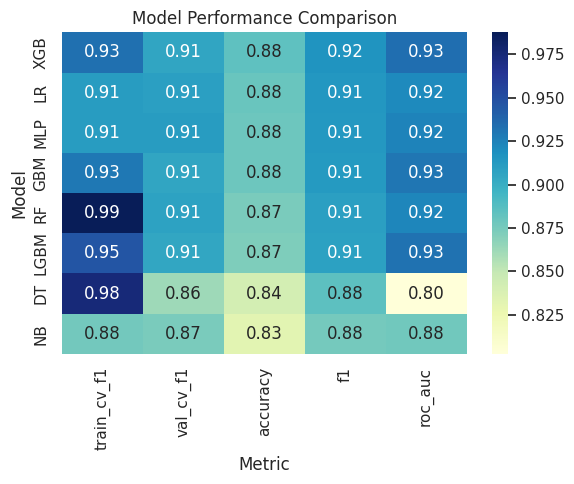

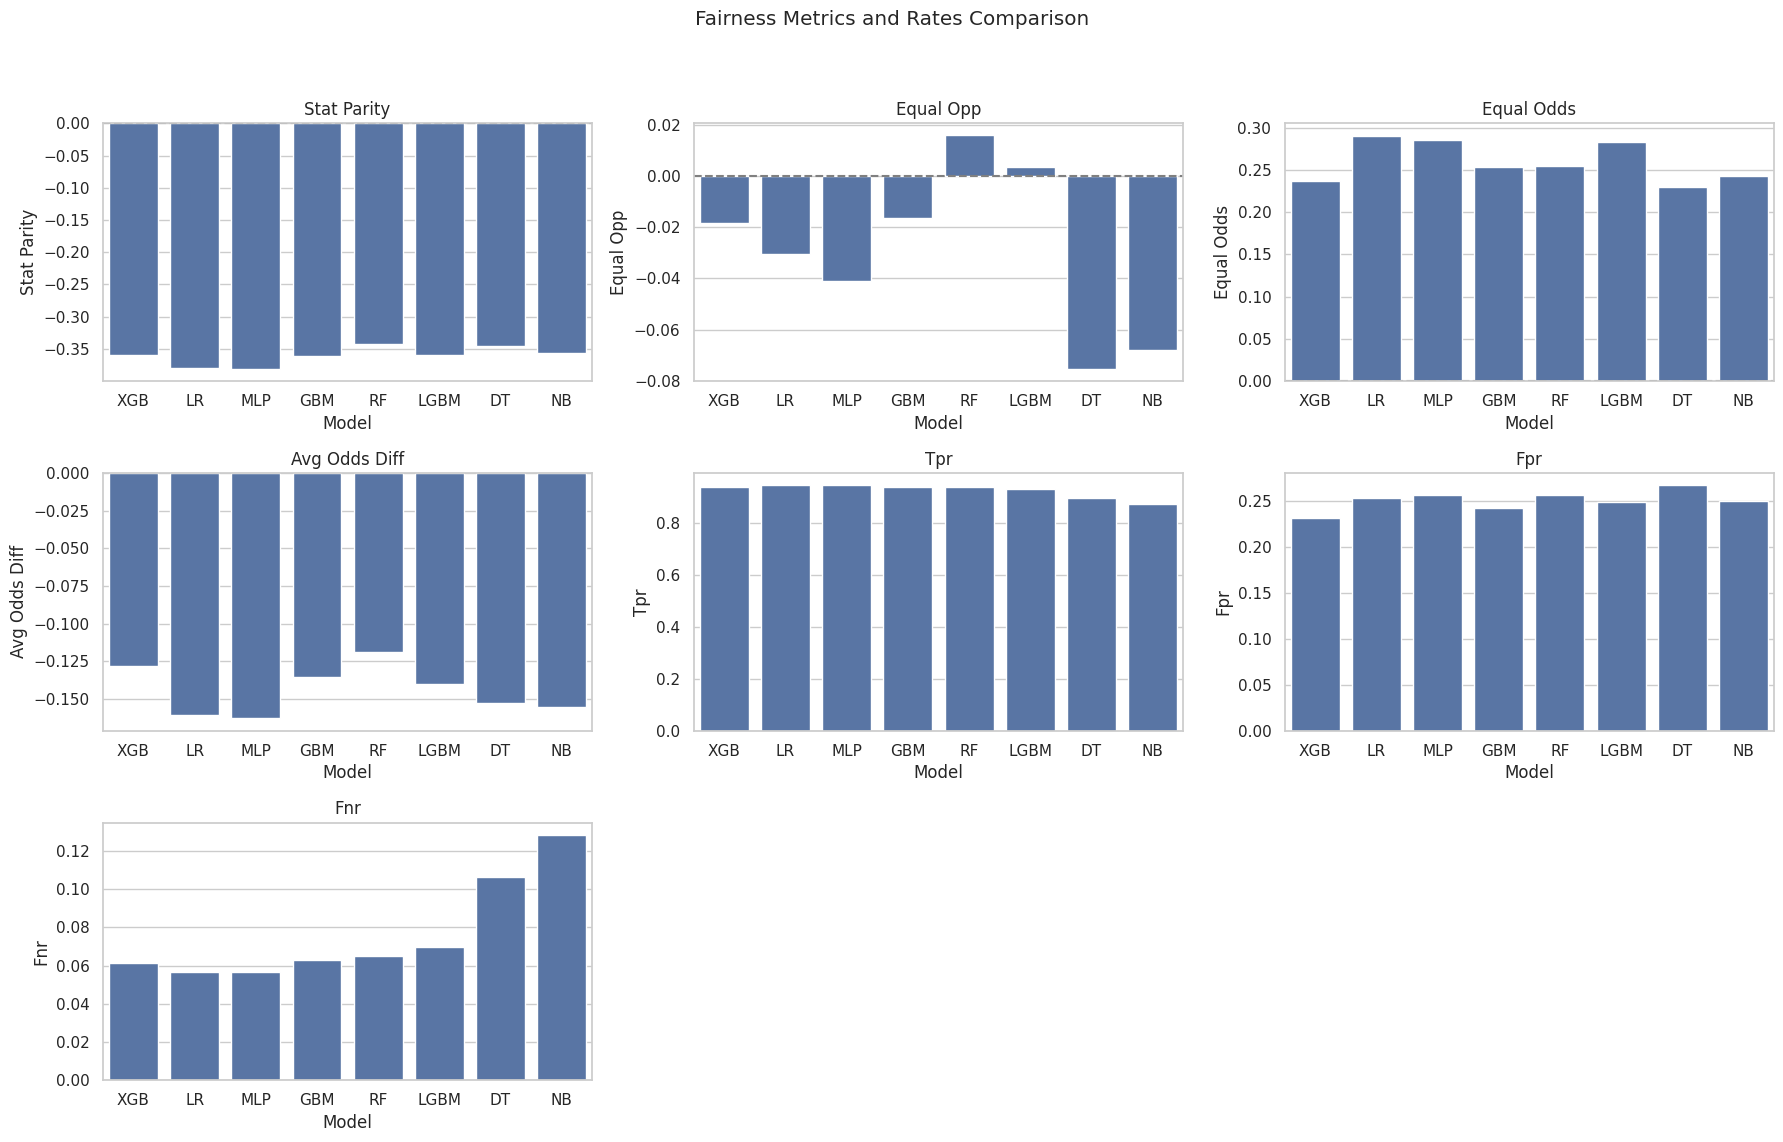

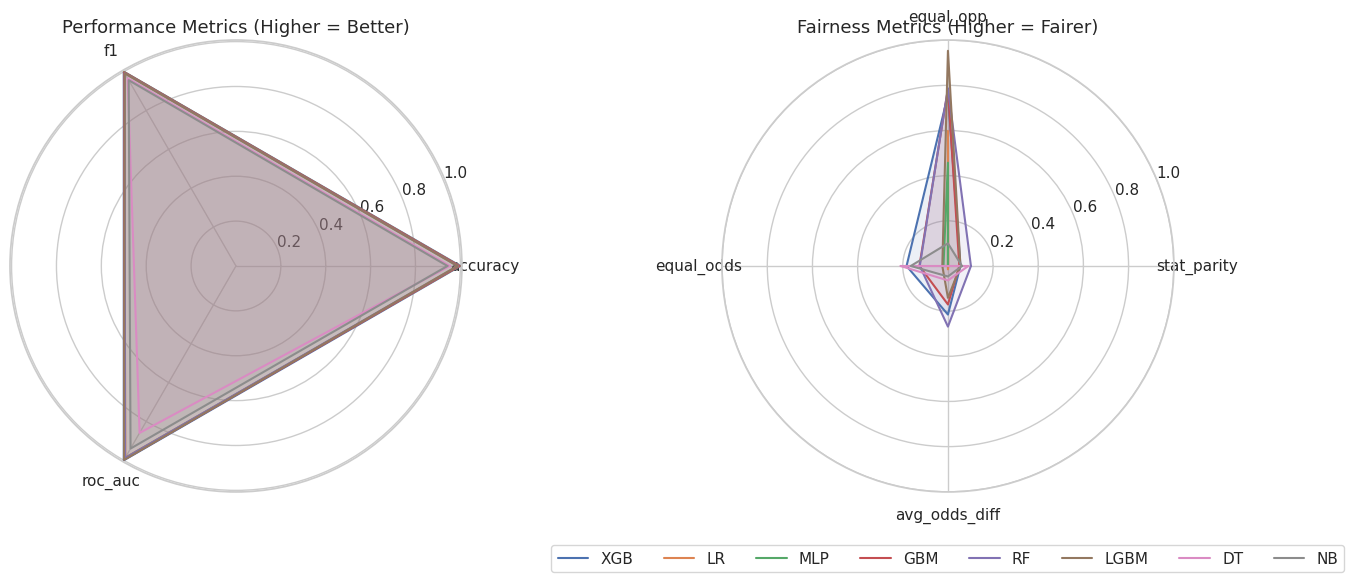

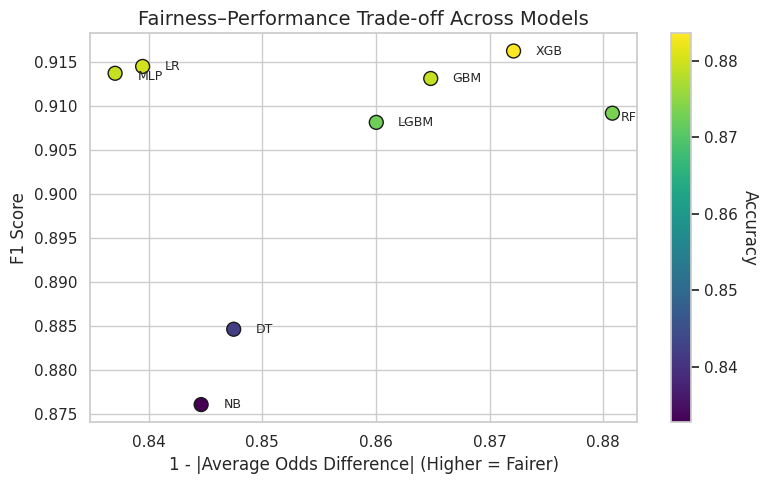

Balanced Best Model: XGB
Model parameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 57, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:19:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:19:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11

epoch 0; iter: 0; batch classifier loss: 0.673386; batch adversarial loss: 0.778186
epoch 1; iter: 0; batch classifier loss: 0.303207; batch adversarial loss: 0.734925
epoch 2; iter: 0; batch classifier loss: 0.309469; batch adversarial loss: 0.679066
epoch 3; iter: 0; batch classifier loss: 0.318022; batch adversarial loss: 0.661799
epoch 4; iter: 0; batch classifier loss: 0.374543; batch adversarial loss: 0.557802
epoch 5; iter: 0; batch classifier loss: 0.238030; batch adversarial loss: 0.473035
epoch 6; iter: 0; batch classifier loss: 0.396740; batch adversarial loss: 0.505229
epoch 7; iter: 0; batch classifier loss: 0.272804; batch adversarial loss: 0.577267
epoch 8; iter: 0; batch classifier loss: 0.213571; batch adversarial loss: 0.449453
epoch 9; iter: 0; batch classifier loss: 0.216352; batch adversarial loss: 0.623824
epoch 0; iter: 0; batch classifier loss: 0.673386; batch adversarial loss: 0.778186
epoch 1; iter: 0; batch classifier loss: 0.303207; batch adversarial loss: 0

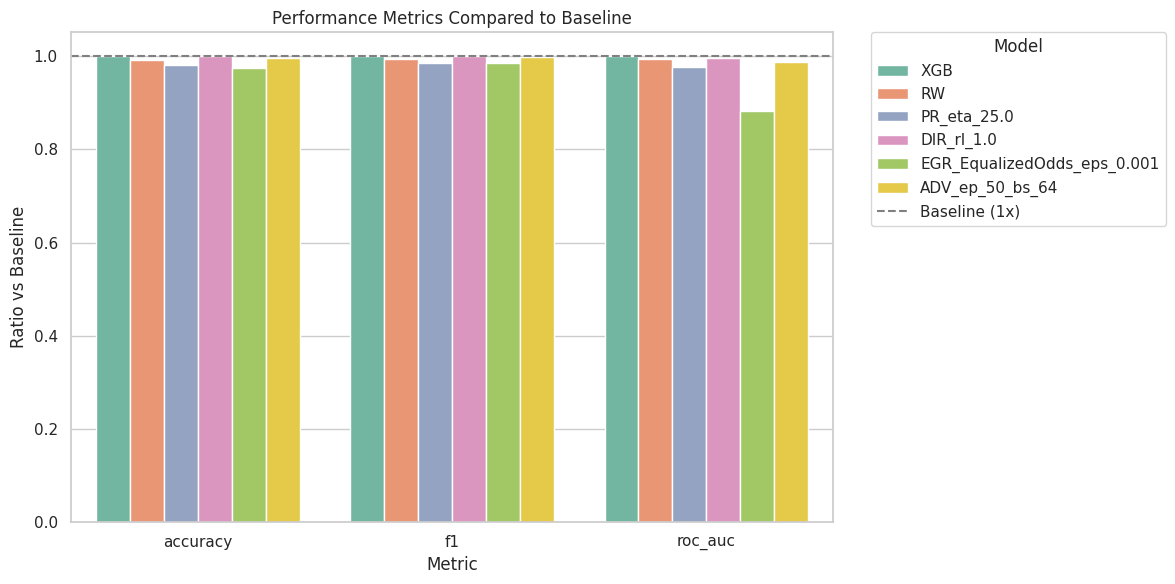

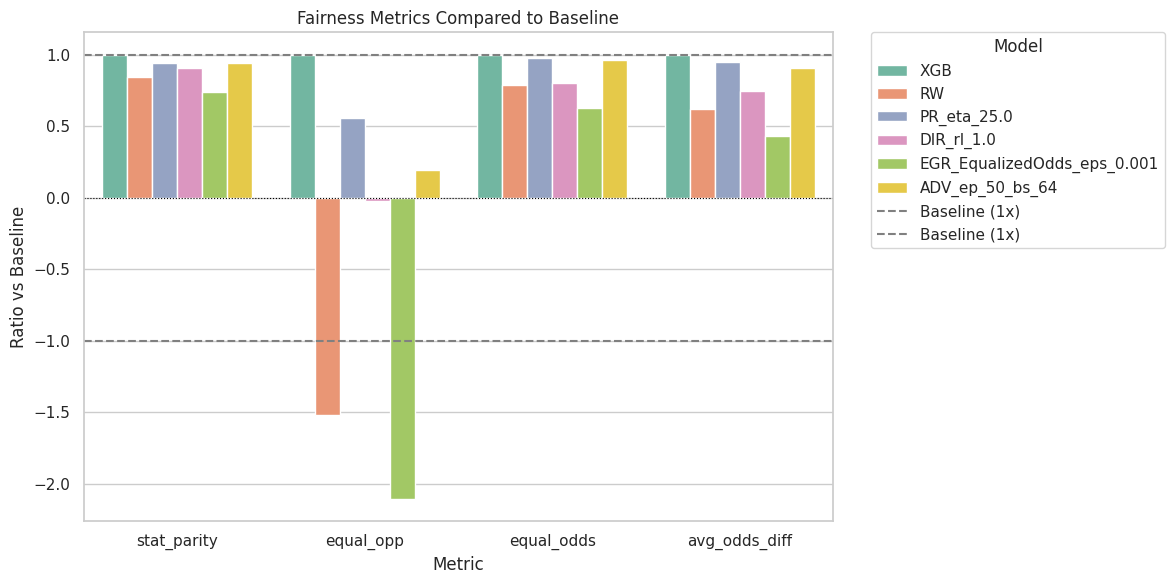

/tmp/ipython-input-2097818403.py:84: RuntimeWarning: invalid value encountered in scalar divide
  n_fav
/tmp/ipython-input-2097818403.py:89: RuntimeWarning: invalid value encountered in scalar divide
  n_unfav
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:20:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


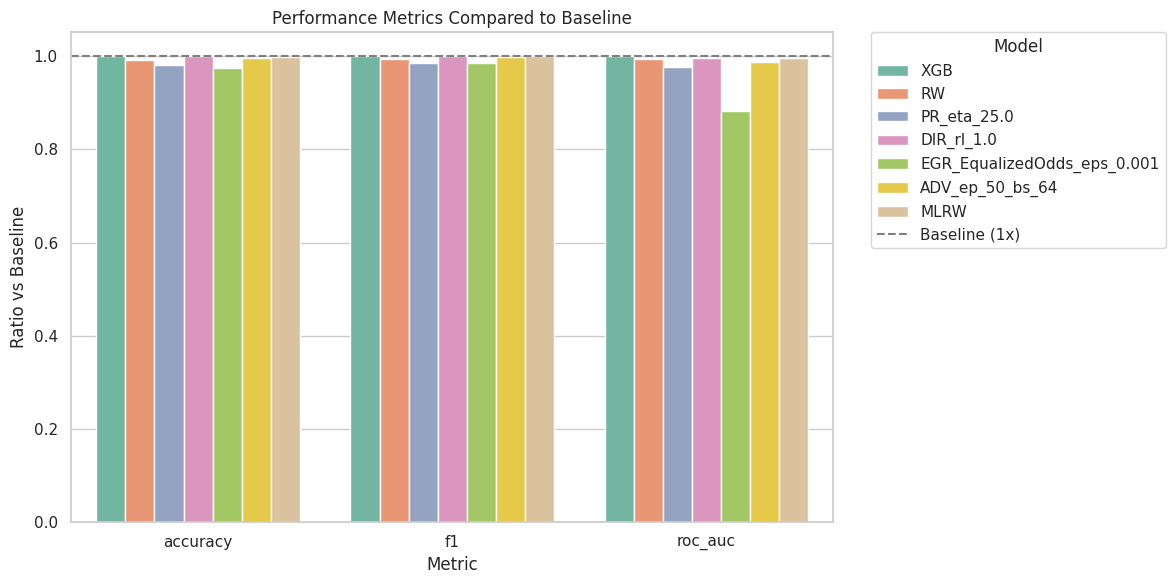

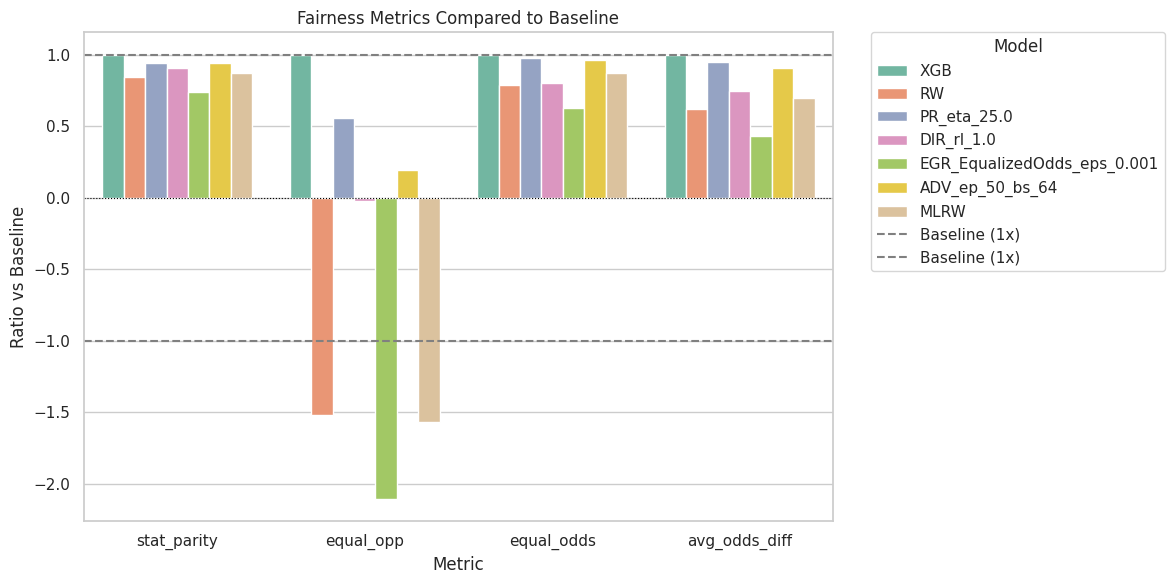

In [ ]:
combined_results, combined_final = run_fair_ml_pipeline(
    data=data,
    target=target,
    sensitive_feature=sensitive_feature,
    param_grid=param_grid
)

In [ ]:
combined_final.style.apply(
    highlight_max, subset=['accuracy', 'f1', 'roc_auc', 'tpr']).apply(
        highlight_min_abs, subset=['stat_parity', 'equal_opp', 'equal_odds', 'avg_odds_diff', 'fpr', 'fnr'])

In [ ]:
# Export the results DataFrame to a CSV file
combined_final.to_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/Student/Student_Age_original.csv')

### Old codes to run individually

In [ ]:
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.Session()

combined_results = run_all_fairness_methods(best_name, X_train, y_train, X_test, y_test, target, sensitive_feature, results_df, results_dict)

TypeError: run_all_fairness_methods() missing 1 required positional argument: 'results_dict'

In [ ]:
combined_results

train_cv_f1 val_cv_f1  accuracy        f1   roc_auc stat_parity equal_opp  \
RF     0.804809  0.667149  0.857048  0.684553   0.91028   -0.182704 -0.089811   
RW          NaN       NaN  0.855832  0.675137   0.90899   -0.155315 -0.027315   
PR          NaN       NaN   0.76639  0.117008  0.728538   -0.020816 -0.048045   
DIR         NaN       NaN  0.858043  0.693848  0.910556   -0.195656 -0.104597   
EGR         NaN       NaN  0.847098  0.663422  0.766927    0.000798  0.017884   
ADV         NaN       NaN  0.850304  0.671837  0.904188     0.01079  0.031539   

    equal_odds avg_odds_diff       tpr       fpr       fnr  \
RF    0.106125     -0.082544  0.627539  0.067476  0.372461   
RW    0.056027     -0.041671  0.604371  0.061296  0.395629   
PR    0.048045     -0.025309  0.062444  0.001617  0.937556   
DIR   0.104597     -0.094391  0.648974  0.073056  0.351026   
EGR   0.017884      0.005906  0.607939  0.074085  0.392061   
ADV   0.031539      0.017111  0.618198  0.073203  0.381802   

                                            best_model  
RF   (MinMaxScaler(), (DecisionTreeClassifier(max_d...  
RW   (MinMaxScaler(), (DecisionTreeClassifier(max_d...  
PR   <aif360.algorithms.inprocessing.prejudice_remo...  
DIR  (MinMaxScaler(), (DecisionTreeClassifier(max_d...  
EGR  ExponentiatedGradient(constraints=<fairlearn.r...  
ADV  <aif360.algorithms.inprocessing.adversarial_de...

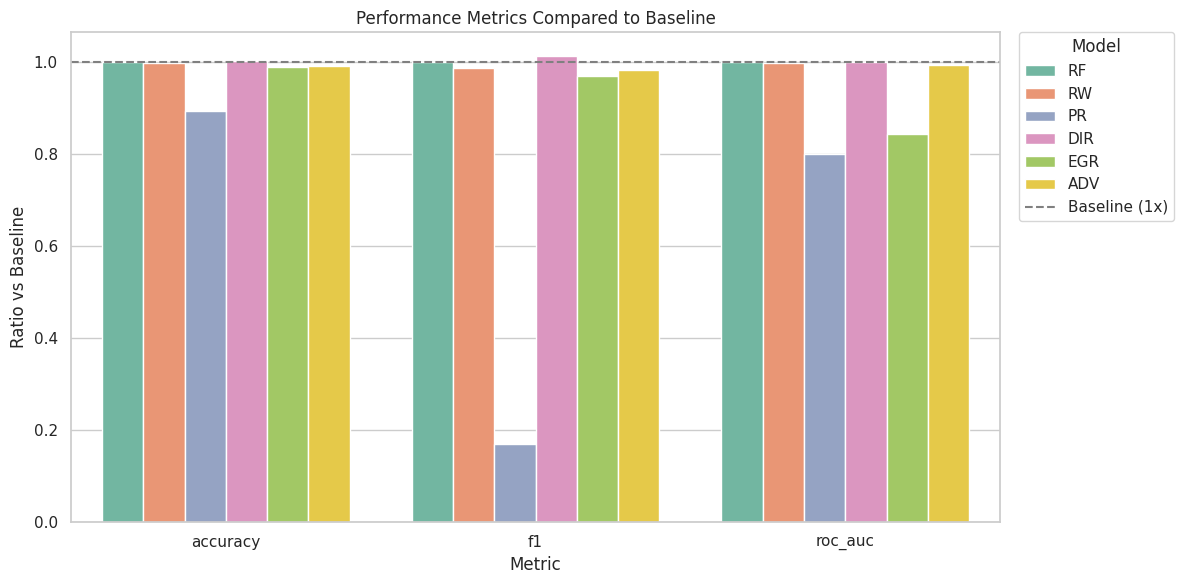

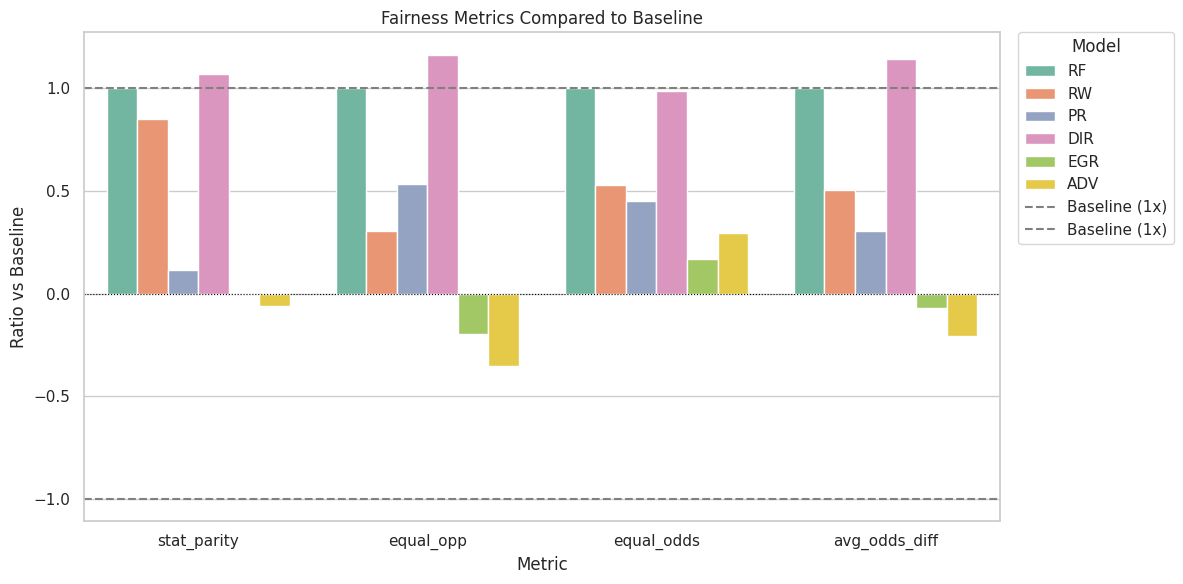

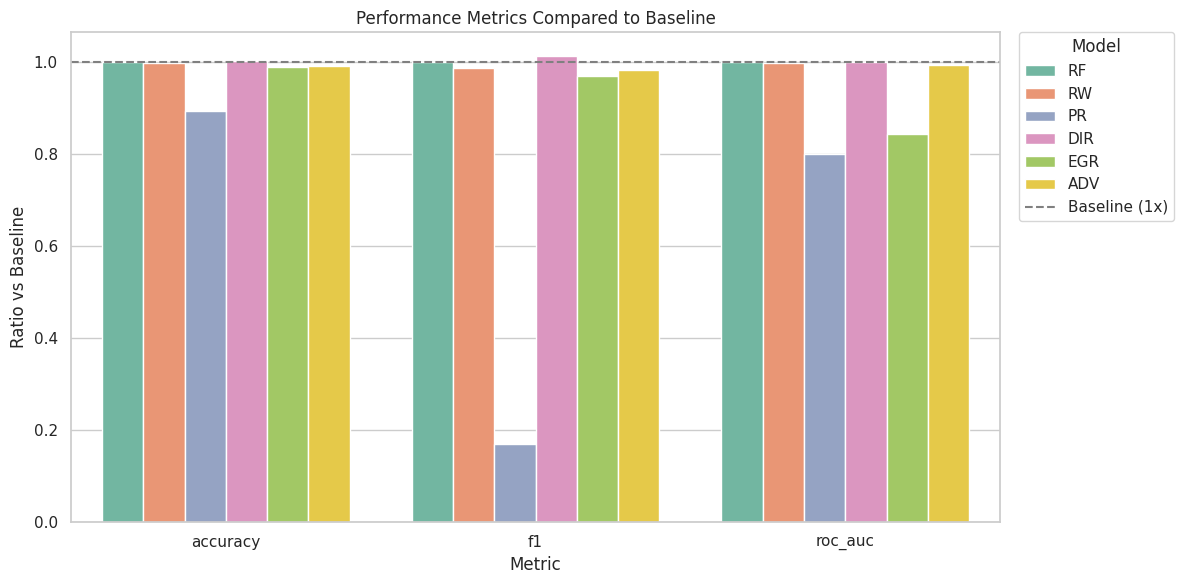

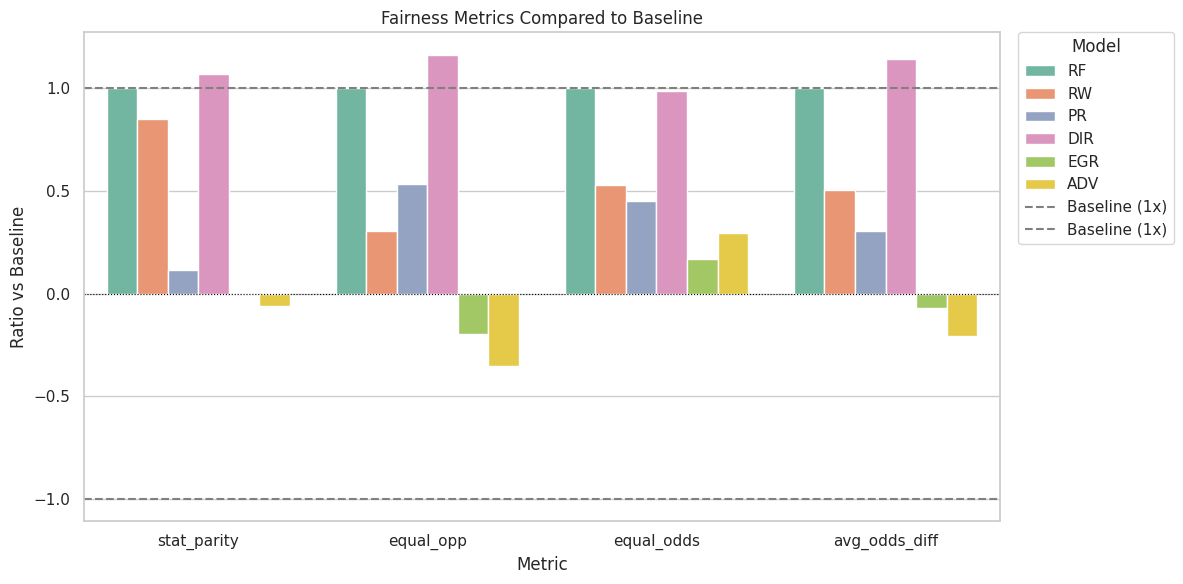

In [ ]:
plot_comparison(combined_results)

In [ ]:
mlrw_results = mlrw(best_name, X_train, y_train, X_test, y_test, results_dict)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [ ]:
mlrw_results

accuracy        f1   roc_auc stat_parity equal_opp equal_odds  \
MLRW  0.855721  0.675454  0.908886   -0.160028 -0.032462   0.060739   

     avg_odds_diff       tpr       fpr       fnr  \
MLRW     -0.046601  0.605709  0.061884  0.394291   

                                             best_model  
MLRW  (MinMaxScaler(), (DecisionTreeClassifier(max_d...

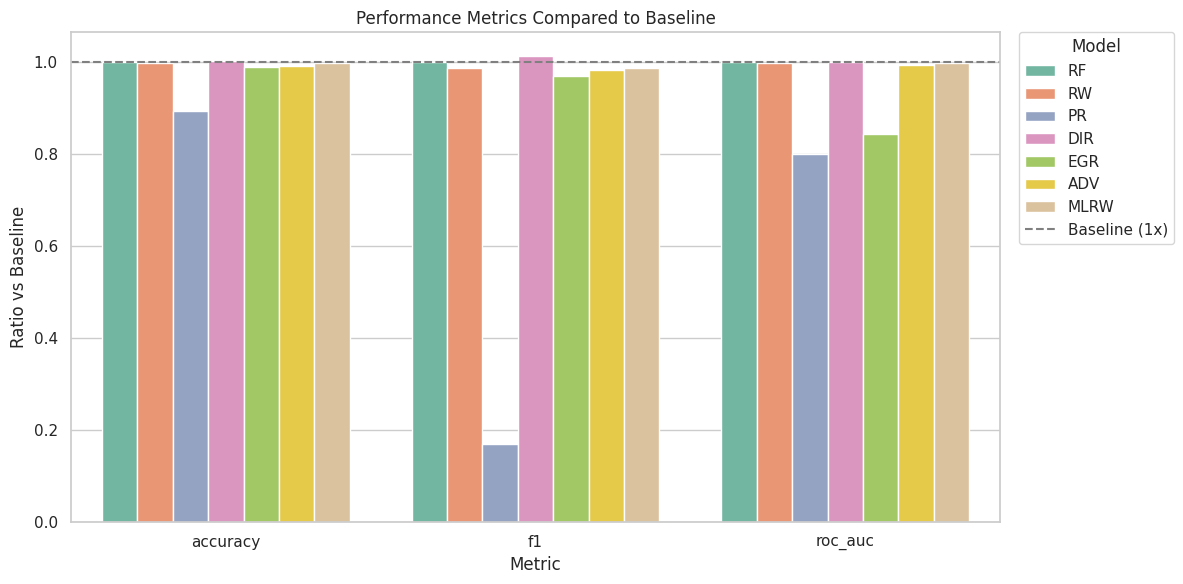

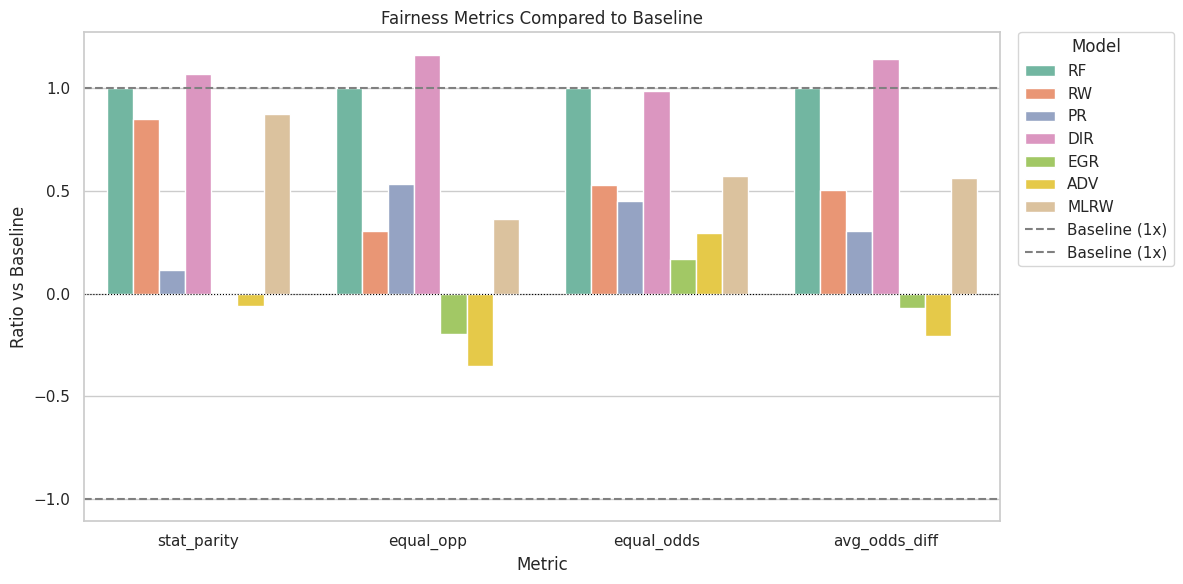

In [ ]:
combined_final = pd.concat([combined_results, mlrw_results], axis=0)
plot_comparison(combined_final)

In [ ]:
combined_final.style.apply(
    highlight_max, subset=['accuracy', 'f1', 'roc_auc', 'tpr']).apply(
        highlight_min_abs, subset=['stat_parity', 'equal_opp', 'equal_odds', 'avg_odds_diff', 'fpr', 'fnr'])

##Modifications to Datasets

### Modification and Visualisation Functions

In [ ]:
def flip_and_adjust_features(df, label_col, sensitive_col, flip_fraction):
    """
    Flip a fraction of privileged group labels and adjust selected features
    to better resemble those from the unprivileged label=1 group.
    """
    # Identify privileged group with label=1
    privileged = (df[sensitive_col] == 1) & (df[label_col] == 1)
    candidates = df[privileged].copy()

    # Randomly select subset to flip
    flip_count = int(flip_fraction * len(candidates))
    to_flip = candidates.sample(flip_count, random_state=random_seed)
    flip_indices = to_flip.index

    # Flip labels
    df.loc[flip_indices, label_col] = 0

    # Reference group for feature adjustment (same sensitive group, opposite label)
    reference_group = df[(df[sensitive_col] == 1) & (df[label_col] == 0)]

    # Define features to adjust
    features_to_adjust = ['Previous qualification',
                          'Previous qualification (grade)', 'Nacionality',
                          "Mother's qualification", "Father's qualification",
                          'Admission grade', 'Course',
                          'Displaced', 'Educational special needs',
                          'Tuition fees up to date', 'Scholarship holder',
                          'Curricular units 1st sem (approved)',
                          'Curricular units 1st sem (grade)',
                          'Curricular units 2nd sem (enrolled)',
                          'Curricular units 2nd sem (evaluations)',
                          'Curricular units 2nd sem (approved)',
                          'Curricular units 2nd sem (grade)',
                          ]

    for feature in features_to_adjust:
        valid_values = reference_group[feature].dropna().values
        if len(valid_values) == 0:
            continue  # skip if reference has no valid data

        # Sample same number of values as number of flipped records
        sampled_values = np.random.choice(valid_values, size=flip_count, replace=True)

        # Assign values row by row to avoid shape mismatches
        for idx, val in zip(flip_indices, sampled_values):
            df.at[idx, feature] = val

    return df

In [ ]:
def flip_and_adjust_unprivileged(df, label_col, sensitive_col, flip_fraction):
    """
    Promote a fraction of underprivileged group with label=0 to label=1,
    and adjust their features to resemble label=1 examples.
    """
    # Identify underprivileged group with label=0
    underprivileged = (df[sensitive_col] == 0) & (df[label_col] == 0)
    candidates = df[underprivileged].copy()

    # Determine number to flip
    flip_count = int(flip_fraction * len(candidates))
    to_flip = candidates.sample(flip_count, random_state=random_seed)
    flip_indices = to_flip.index

    # Flip labels to 1
    df.loc[flip_indices, label_col] = 1

    # Reference group for feature adjustment (same sensitive group, opposite label)
    reference_group = df[((df[sensitive_col] == 0) & (df[label_col] == 1))]

    features_to_adjust = ['Previous qualification',
                          'Previous qualification (grade)', 'Nacionality',
                          "Mother's qualification", "Father's qualification",
                          'Admission grade', 'Course',
                          'Displaced', 'Educational special needs',
                          'Tuition fees up to date', 'Scholarship holder',
                          'Curricular units 1st sem (approved)',
                          'Curricular units 1st sem (grade)',
                          'Curricular units 2nd sem (enrolled)',
                          'Curricular units 2nd sem (evaluations)',
                          'Curricular units 2nd sem (approved)',
                          'Curricular units 2nd sem (grade)',
                          ]

    for feature in features_to_adjust:
        valid_values = reference_group[feature].dropna().values
        if len(valid_values) == 0:
            continue  # no reference data

        sampled_values = np.random.choice(valid_values, size=flip_count, replace=True)
        for idx, val in zip(flip_indices, sampled_values):
            df.at[idx, feature] = val

    return df

In [ ]:
def flip_near_boundary(X, y, sensitive_col, label_col, flip_fraction, boundary_width=0.2):
    """
    Flip labels for a fraction of privileged group samples near the decision boundary.

    Returns:
        X_encoded_modified: DataFrame (encoded features with flipped labels)
        y_modified: Series (flipped labels)
        flipped_indices: list (indices of flipped samples)
    """
    # --- Combine X and y ---
    data = X.copy()
    data[label_col] = y.values

    # --- One-hot encode categorical features ---
    X_encoded = pd.get_dummies(data.drop(columns=[label_col]), drop_first=True)
    y_array = data[label_col].values

    # --- Fit logistic regression model ---
    model = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear'))
    model.fit(X_encoded, y_array)

    # --- Predict probabilities ---
    probs = model.predict_proba(X_encoded)[:, 1]

    # --- Identify privileged group with positive labels ---
    # Assuming sensitive_col is binary: 1 = privileged, 0 = unprivileged
    # --- Determine privileged group after encoding ---
    if sensitive_col in X.columns and X[sensitive_col].nunique() == 2:
        # Use raw sensitive column (not yet one-hot encoded)
        is_privileged = (X[sensitive_col] == 1)
    else:
        # Look for encoded version of sensitive column
        sensitive_encoded_cols = [col for col in X_encoded.columns if sensitive_col in col]
        if len(sensitive_encoded_cols) == 1:
            priv_col = sensitive_encoded_cols[0]
            is_privileged = (X_encoded[priv_col] == 1)
        elif any(col.endswith('_1') for col in sensitive_encoded_cols):
            priv_col = [col for col in sensitive_encoded_cols if col.endswith('_1')][0]
            is_privileged = (X_encoded[priv_col] == 1)
        else:
            raise ValueError(f"Could not resolve the encoded privileged column for '{sensitive_col}'. Found: {sensitive_encoded_cols}")

    is_positive = (y_array == 1)

    # --- Identify near-boundary privileged-positive samples ---
    boundary_mask = is_privileged & is_positive & ((probs > 0.5 - boundary_width) & (probs < 0.5 + boundary_width))
    candidates = X_encoded[boundary_mask]

    # --- Randomly select a fraction to flip ---
    n_flip = int(flip_fraction * len(candidates))
    if n_flip == 0:
        print(" No samples selected for flipping. Try increasing flip_fraction or boundary_width.")
        return X_encoded, pd.Series(y_array, index=X_encoded.index), []

    flipped_indices = candidates.sample(n=n_flip, random_state=42).index

    # --- Flip labels ---
    y_modified = pd.Series(y_array, index=X_encoded.index)
    y_modified.loc[flipped_indices] = 0

    print(f" Flipped {len(flipped_indices)} privileged labels near boundary from 1 to 0.")

    return X_encoded, y_modified, flipped_indices

In [ ]:
def flip_near_boundary_underprivileged(X, y, sensitive_col, label_col, flip_fraction, boundary_width=0.2):
    """
    Flip labels for a fraction of underprivileged group samples near the decision boundary,
    promoting from 0 → 1 to simulate upward mobility.

    Returns:
        X_encoded_modified: DataFrame (encoded features with flipped labels)
        y_modified: Series (flipped labels)
        flipped_indices: list (indices of flipped samples)
    """
    data = X.copy()
    data[label_col] = y.values

    # Encode categorical features
    X_encoded = pd.get_dummies(data.drop(columns=[label_col]), drop_first=True)
    y_array = data[label_col].values

    # Train classifier
    model = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear'))
    model.fit(X_encoded, y_array)

    probs = model.predict_proba(X_encoded)[:, 1]

    # Identify underprivileged group (assumes 0 = underprivileged)
    if sensitive_col in X.columns and X[sensitive_col].nunique() == 2:
        is_underprivileged = (X[sensitive_col] == 0)
    else:
        # Check encoded sensitive col
        sensitive_encoded_cols = [col for col in X_encoded.columns if sensitive_col in col]
        if len(sensitive_encoded_cols) == 1:
            under_col = sensitive_encoded_cols[0]
            is_underprivileged = (X_encoded[under_col] == 1)
        elif any(col.endswith('_0') for col in sensitive_encoded_cols):
            under_col = [col for col in sensitive_encoded_cols if col.endswith('_0')][0]
            is_underprivileged = (X_encoded[under_col] == 1)
        else:
            raise ValueError(f"Could not resolve encoded underprivileged group for '{sensitive_col}'. Found: {sensitive_encoded_cols}")

    is_negative = (y_array == 0)

    # Candidates: underprivileged group with label=0 near boundary
    boundary_mask = is_underprivileged & is_negative & ((probs > 0.5 - boundary_width) & (probs < 0.5 + boundary_width))
    candidates = X_encoded[boundary_mask]

    n_flip = int(flip_fraction * len(candidates))
    if n_flip == 0:
        print(" No samples selected for flipping. Try increasing flip_fraction or boundary_width.")
        return X_encoded, pd.Series(y_array, index=X_encoded.index), []

    flipped_indices = candidates.sample(n=n_flip, random_state=42).index

    y_modified = pd.Series(y_array, index=X_encoded.index)
    y_modified.loc[flipped_indices] = 1  # promote: 0 → 1

    print(f" Flipped {len(flipped_indices)} underprivileged labels near boundary from 0 to 1.")

    return X_encoded, y_modified, flipped_indices

In [ ]:
def compare_multiple_feature_distributions(original_df, flipped_df, features, figsize=(15, 10), ncols=3):
    """
    Compare KDE distributions of multiple features between original and flipped datasets in a grid of subplots,
    and annotate each plot with the KS-test p-value.

    Args:
        original_df (pd.DataFrame): Original dataset.
        flipped_df (pd.DataFrame): Flipped/modified dataset.
        features (list): List of features to compare.
        figsize (tuple): Size of the overall figure.
        ncols (int): Number of columns in the subplot grid.
    """
    n_features = len(features)
    nrows = (n_features + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    for idx, feature in enumerate(features):
        ax = axes[idx]

        # Plot KDE
        sns.kdeplot(original_df[feature], fill=True, label='Original', color='blue', ax=ax)
        sns.kdeplot(flipped_df[feature], fill=True, label='Flipped', color='orange', ax=ax)

        # Perform KS test
        ks_stat, p_value = ks_2samp(original_df[feature].dropna(), flipped_df[feature].dropna())

        # Annotate with p-value
        ax.set_title(f"{feature}\nKS D={ks_stat:.3f}, p={p_value:.4f}")
        ax.legend()

    # Remove empty subplots
    for i in range(n_features, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_biased_data_comparison(datasets, sensitive_feature, label_col):
    """
    Compare class distributions across multiple datasets grouped by a sensitive feature.

    Args:
        datasets (list of tuples): [(DataFrame, "Label"), ...]
        sensitive_feature (str): Column name of the sensitive feature (e.g., 'sex')
        label_col (str): Target label column name (e.g., 'income')
    """
    # Preserve the source order from the input
    source_order = [label for _, label in datasets]

    # Tag and combine
    combined_list = []
    for df, source_name in datasets:
        df_copy = df.copy()
        df_copy['Source'] = source_name
        combined_list.append(df_copy)

    combined_df = pd.concat(combined_list, axis=0)

    # Compute proportions
    grouped = (
        combined_df
        .groupby(['Source', sensitive_feature])[label_col]
        .value_counts(normalize=True)
        .rename("Proportion")
        .reset_index()
    )

    # Ensure Source has a defined order
    grouped['Source'] = pd.Categorical(grouped['Source'], categories=source_order, ordered=True)

    # Create a new x-label combining group and source in a consistent order
    grouped['Group'] = grouped[sensitive_feature].astype(str) + " (" + grouped['Source'].astype(str) + ")"

    # Sort by Source and then Group to ensure correct plotting order
    grouped = grouped.sort_values(by=['Source', 'Group'])

    # Plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=grouped, x='Group', y='Proportion', hue=label_col, palette='Set2')

    # Add percentage text on each bar
    for container in ax.containers:
        ax.bar_label(container, labels=[f'{p.get_height()*100:.1f}%' for p in container],
                     label_type='edge', padding=3, fontsize=8)

    plt.title(f'Class Distribution by {sensitive_feature.title()} Across Datasets')
    plt.ylabel("Proportion")
    plt.xlabel(f"{sensitive_feature.title()} Group (by Dataset)")
    plt.xticks(rotation=90)
    plt.legend(
        title=label_col,
        bbox_to_anchor=(1.01, 1),
        loc='upper left',
        borderaxespad=0)
    plt.tight_layout()
    plt.show()

**Statistical Interpretaion:**

* KS Stat near 0: little or no shift.
* Higher KS Stat: stronger difference in distributions.
* Low p-values (< 0.05) suggest that the distributions are significantly different.

In [ ]:
from scipy.stats import ks_2samp

def ks_feature_shift(original_df, flipped_df, features):
    for f in features:
        stat, p = ks_2samp(original_df[f], flipped_df[f])
        print(f"Feature: {f} | KS Stat: {stat:.4f} | p-value: {p:.4f}")

In [ ]:
def ks_feature_shift_table(original_df, modified_datasets, features, alpha=0.05):
    rows = []
    for modified_df, label in modified_datasets:
        for f in features:
            try:
                stat, p = ks_2samp(original_df[f].dropna(), modified_df[f].dropna())
                rows.append({
                    'Dataset': label,
                    'Feature': f,
                    'KS Stat': stat,
                    'p-value': p,
                    f'Significant (p < {alpha:.2g})': p < alpha
                })
            except Exception as e:
                rows.append({
                    'Dataset': label,
                    'Feature': f,
                    'KS Stat': None,
                    'p-value': None,
                    f'Significant (p < {alpha:.2g})': False
                })

    return pd.DataFrame(rows)

### Dataset Modification - Increase Bias on underprivileged group

In the student dropout dataset, Males (class = 1) are more prone to dropout. Therefore, they would be the Underprivileged group.

Privileged: Females (Class = 0)

Underprivileged: Males (Class = 1)

Flip Labels - Ratio: 0.3 to reduce Priv

In [ ]:
# Flipping the income labels for a fraction of the Privileged group with feature adjustment
# Frac = 0.3
bias_adjust_flip_1 = flip_and_adjust_features(data.copy(), label_col=target, sensitive_col=sensitive_feature, flip_fraction=0.3)

In [ ]:
# save bias_adust_flip_1 to drive
bias_adjust_flip_1.to_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/datasets/Student/Raw/Student_Age_bias1.csv')

In [ ]:
# Flipping the income labels for a fraction of the Privileged group with feature adjustment
# Frac = 0.3
bias_adjust_flip_2 = flip_and_adjust_features(data.copy(), label_col=target, sensitive_col=sensitive_feature, flip_fraction=0.5)

In [ ]:
# save bias_adust_flip_2 to drive
bias_adjust_flip_2.to_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/datasets/Student/Raw/Student_Age_bias2.csv')

In [ ]:
# Flipping the income labels for a fraction of the Privileged Group at boundary cases
# Frac = 0.5, boundary_width=0.2 (fixed in flip_near_boundary function)
X_flipped, y_flipped, flipped_idx = flip_near_boundary(
    X=data.drop(columns=target),
    y=data[target],
    sensitive_col=sensitive_feature,
    label_col=target,
    flip_fraction=0.5
)

 Flipped 114 privileged labels near boundary from 1 to 0.


In [ ]:
# Ratio of flipped_indices (boundary cases) against the privileged, high income population
print("Percentage of boundary cases flipped upon Privileged group population:")
print(f"{len(flipped_idx) / len(X_flipped[X_flipped[sensitive_feature] == 1])*100:.2f}%")

Percentage of boundary cases flipped upon Privileged group population:
3.37%


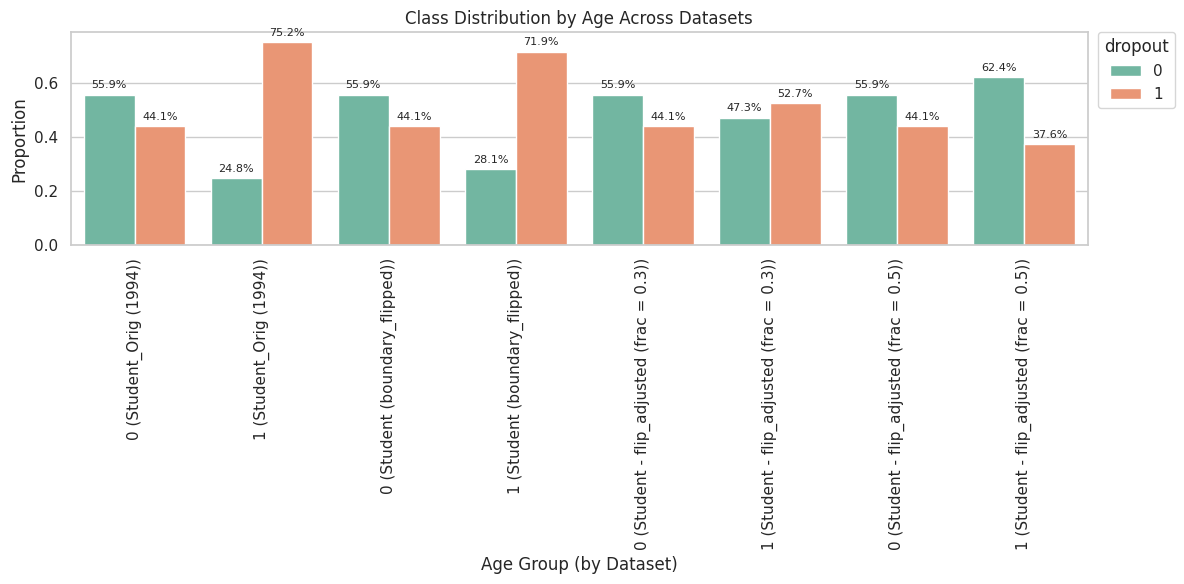

In [ ]:
# Transform X_flipped to be used in plot_biased_data_comparison, including y_flipped
X_flipped.insert(0, target, y_flipped)

# Show comparison of datasets (income labels for privileged and underprivileged groups)
plot_biased_data_comparison(
    datasets=[
        (data, "Student_Orig (1994)"),
        (X_flipped, "Student (boundary_flipped)"),
        (bias_adjust_flip_1, "Student - flip_adjusted (frac = 0.3)"),
        (bias_adjust_flip_2, "Student - flip_adjusted (frac = 0.5)")
    ],
    sensitive_feature=sensitive_feature,
    label_col=target
)

In [ ]:
datasets=[
        (data, "Student_Orig (1994)"),
        (X_flipped, "Student (boundary_flipped)"),
        (bias_adjust_flip_1, "Student - flip_adjusted (frac = 0.3)"),
        (bias_adjust_flip_2, "Student - flip_adjusted (frac = 0.5)")
    ]
features_to_compare = ['Previous qualification',
                       'Previous qualification (grade)', 'Nacionality',
                       "Mother's qualification", "Father's qualification",
                       'Admission grade', 'Course',
                       'Displaced', 'Educational special needs',
                       'Tuition fees up to date', 'Scholarship holder',
                       'Curricular units 1st sem (approved)',
                       'Curricular units 1st sem (grade)',
                       'Curricular units 2nd sem (enrolled)',
                       'Curricular units 2nd sem (evaluations)',
                       'Curricular units 2nd sem (approved)',
                       'Curricular units 2nd sem (grade)',
                       ]

# Generate table
ks_table = ks_feature_shift_table(data, datasets, features_to_compare)

# Define column name for significance
signif_col = [col for col in ks_table.columns if col.startswith("Significant")][0]

# Define highlighter
def highlight_significant(row):
    if pd.isnull(row['KS Stat']) or pd.isnull(row['p-value']):
        return [''] * len(row)
    color = 'background-color: lightgreen' if row[signif_col] and row['KS Stat'] > 0.01 else ''
    return [color if col in ['KS Stat', 'p-value'] else '' for col in ks_table.columns]

# Apply styling
ks_table_sorted = ks_table.sort_values(by=['Feature', 'Dataset'])
ks_table_sorted.style \
    .apply(highlight_significant, axis=1) \
    .format({
        "KS Stat": "{:.3f}",
        "p-value": "{:.4f}"
    })

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


### Flip Label frac=0.3/0.5 improve UnderPriv (bias_adjust_flip_3, bias_adjust_flip_4)

**Flip labels**

Increasing favourable outcomes for UnderPrivileged Group
Randomly flip income <=50K labels to >50K in the underprivileged group (e.g. sex = Female or race = non-white).

In [ ]:
# Flipping the income labels for a fraction of the Under-Privileged group with feature adjustment
# Frac = 0.3
bias_adjust_flip_3 = flip_and_adjust_unprivileged(data.copy(), label_col=target, sensitive_col=sensitive_feature, flip_fraction=0.3)

In [ ]:
# save bias_adust_flip_3 to drive
bias_adjust_flip_3.to_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/datasets/Student/Raw/Student_Age_bias3.csv')

In [ ]:
# Flipping the income labels for a fraction of the Under-Privileged group with feature adjustment
# Frac = 0.5
bias_adjust_flip_4 = flip_and_adjust_unprivileged(data.copy(), label_col=target, sensitive_col=sensitive_feature, flip_fraction=0.5)

In [ ]:
# save bias_adust_flip_4 to drive
bias_adjust_flip_4.to_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/datasets/Student/Raw/Student_Age_bias4.csv')

In [ ]:
# Flipping the income labels for a fraction of the Under-Privileged Group at boundary cases
# Frac = 0.5, boundary_width=0.2 (fixed in flip_near_boundary function)
X_flipped_UP, y_flipped_UP, flipped_idx_UP = flip_near_boundary_underprivileged(
    X=data.drop(columns=target),
    y=data[target],
    sensitive_col=sensitive_feature,
    label_col=target,
    flip_fraction=0.5
)

 Flipped 40 underprivileged labels near boundary from 0 to 1.


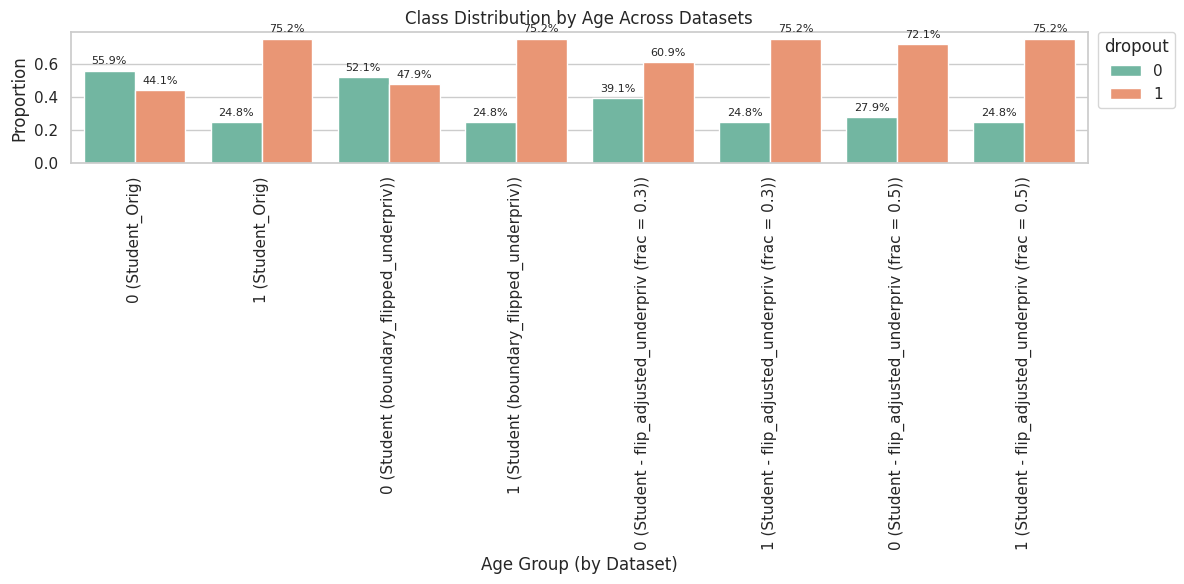

In [ ]:
# Transform X_flipped to be used in plot_biased_data_comparison, including y_flipped
X_flipped_UP.insert(0, target, y_flipped_UP)

# Show comparison of datasets (income labels for privileged and underprivileged groups)
plot_biased_data_comparison(
    datasets=[
        (data, "Student_Orig"),
        (X_flipped_UP, "Student (boundary_flipped_underpriv)"),
        (bias_adjust_flip_3, "Student - flip_adjusted_underpriv (frac = 0.3)"),
        (bias_adjust_flip_4, "Student - flip_adjusted_underpriv (frac = 0.5)")
    ],
    sensitive_feature=sensitive_feature,
    label_col=target
)

In [ ]:
datasets=[
        (data, "Student_Orig"),
        (X_flipped_UP, "Student (boundary_flipped_underpriv)"),
        (bias_adjust_flip_3, "Student - flip_adjusted_underpriv (frac = 0.3)"),
        (bias_adjust_flip_4, "Student - flip_adjusted_underpriv (frac = 0.5)")
    ]

features_to_compare = ['Previous qualification',
                       'Previous qualification (grade)', 'Nacionality',
                       "Mother's qualification", "Father's qualification",
                       'Admission grade', 'Course',
                       'Displaced', 'Educational special needs',
                       'Tuition fees up to date', 'Scholarship holder',
                       'Curricular units 1st sem (approved)',
                       'Curricular units 1st sem (grade)',
                       'Curricular units 2nd sem (enrolled)',
                       'Curricular units 2nd sem (evaluations)',
                       'Curricular units 2nd sem (approved)',
                       'Curricular units 2nd sem (grade)',
                       ]

# Generate table
ks_table = ks_feature_shift_table(data, datasets, features_to_compare)

# Define column name for significance
signif_col = [col for col in ks_table.columns if col.startswith("Significant")][0]

# Define highlighter
def highlight_significant(row):
    if pd.isnull(row['KS Stat']) or pd.isnull(row['p-value']):
        return [''] * len(row)
    color = 'background-color: lightgreen' if row[signif_col] and row['KS Stat'] > 0.01 else ''
    return [color if col in ['KS Stat', 'p-value'] else '' for col in ks_table.columns]

# Apply styling
ks_table_sorted = ks_table.sort_values(by=['Feature', 'Dataset'])
ks_table_sorted.style \
    .apply(highlight_significant, axis=1) \
    .format({
        "KS Stat": "{:.3f}",
        "p-value": "{:.4f}"
    })

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


### Genetic Algorithm Modification

In [ ]:
df_unfair = pd.read_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/datasets/Student/Raw/Student_GenAlgo_Age.csv')

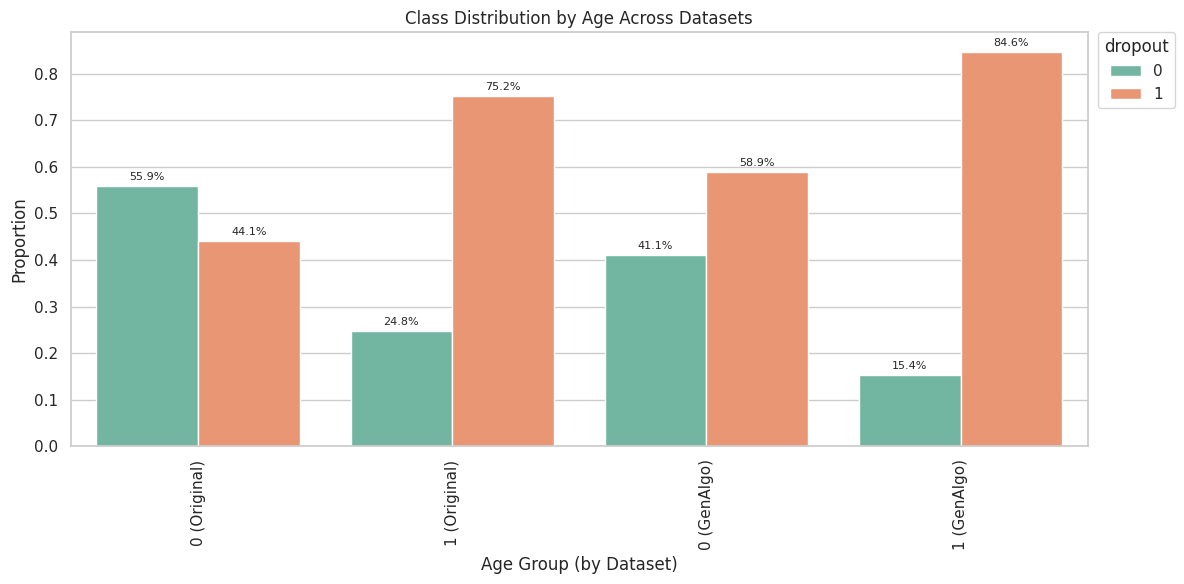

In [ ]:
plot_biased_data_comparison(
    datasets=[
        (data, "Original"),
        (df_unfair, "GenAlgo")
    ],
    sensitive_feature=sensitive_feature,
    label_col=target
)

### Compare all modifications for Adult

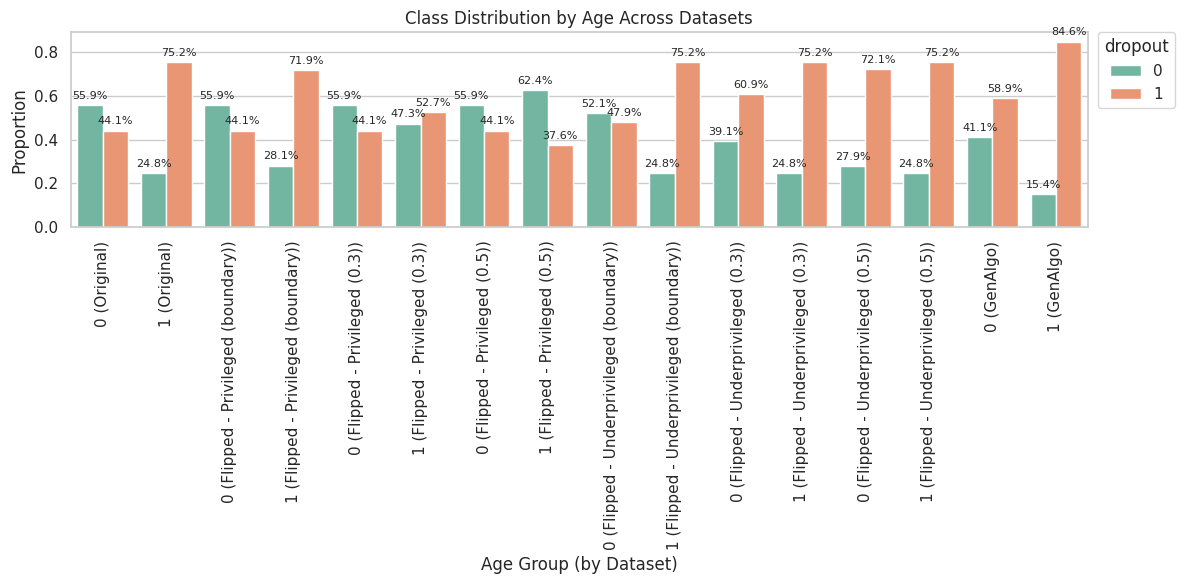

In [ ]:
plot_biased_data_comparison(
    datasets=[
        (data, "Original"),
        (X_flipped, "Flipped - Privileged (boundary)"),
        (bias_adjust_flip_1, "Flipped - Privileged (0.3)"),
        (bias_adjust_flip_2, "Flipped - Privileged (0.5)"),
        (X_flipped_UP, "Flipped - Underprivileged (boundary)"),
        (bias_adjust_flip_3, "Flipped - Underprivileged (0.3)"),
        (bias_adjust_flip_4, "Flipped - Underprivileged (0.5)"),
        (df_unfair, "GenAlgo")
    ],
    sensitive_feature=sensitive_feature,
    label_col=target
)

### Final Runs for all biased_df (individual model selection)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:30:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 1793, number of negative: 1746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1232
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506640 -> initscore=0.026563
[LightGBM] [Info] Start training from score 0.026563


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

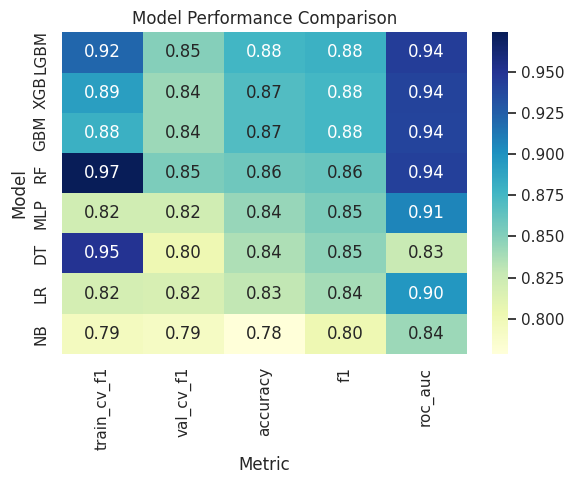

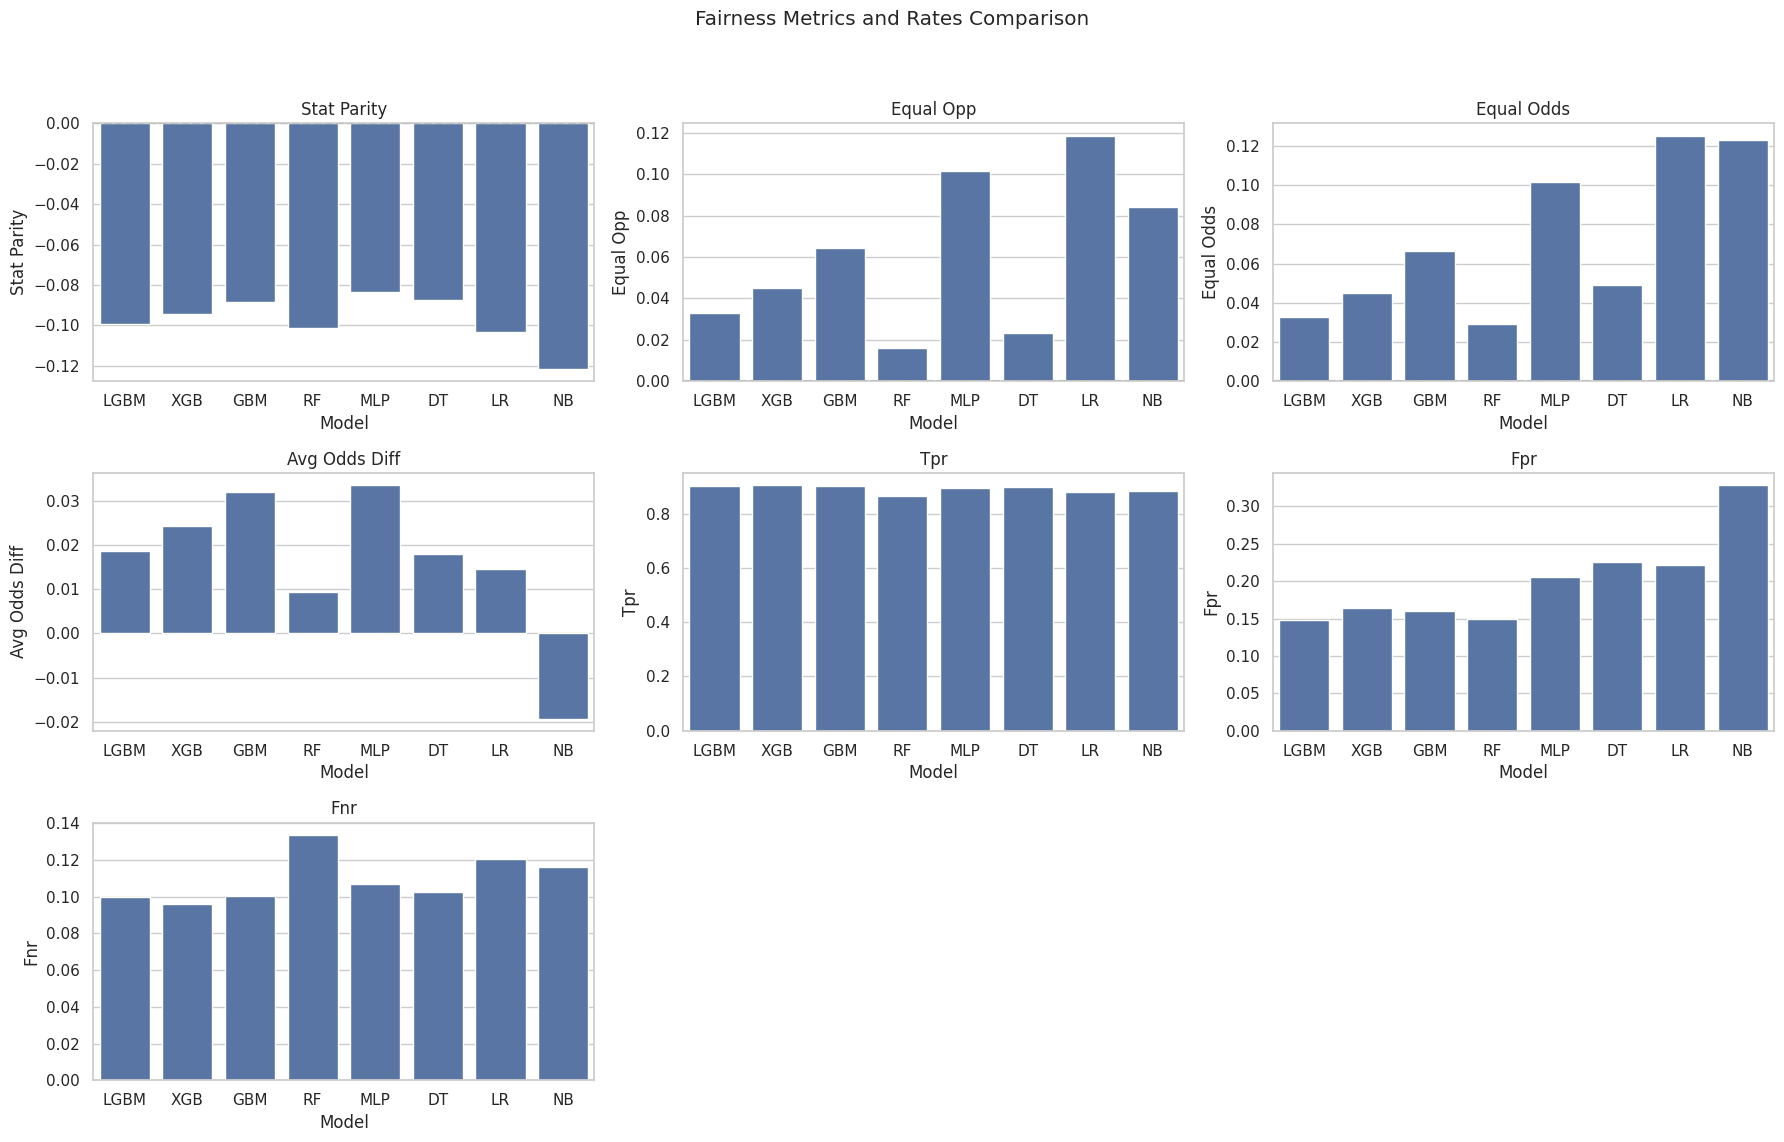

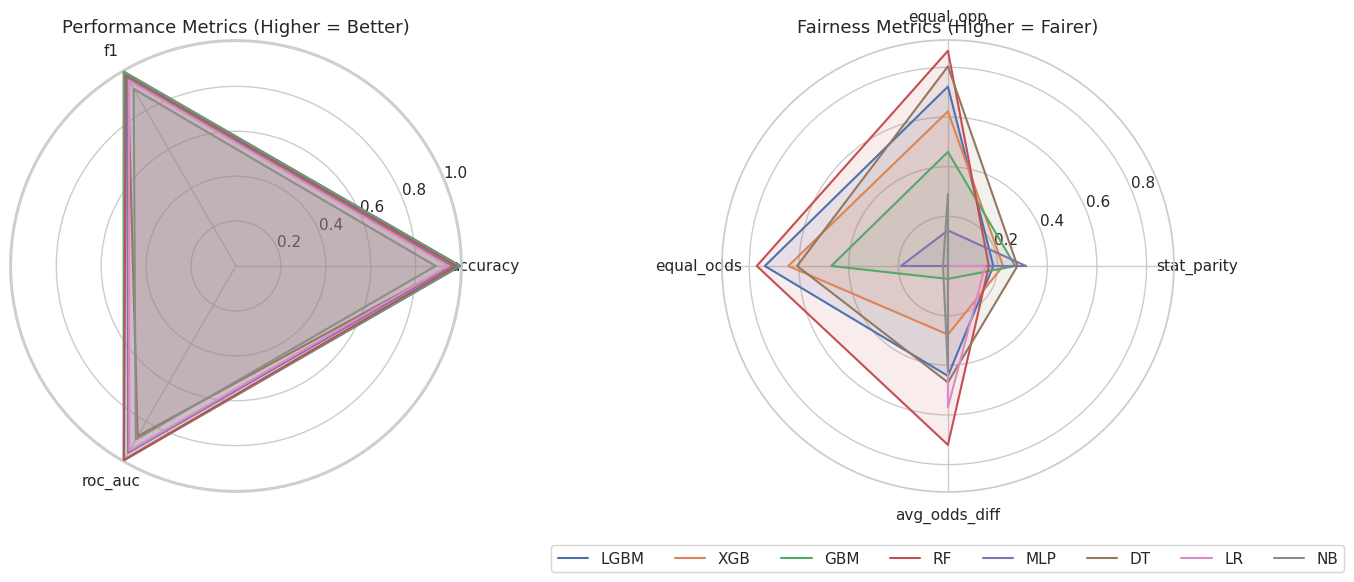

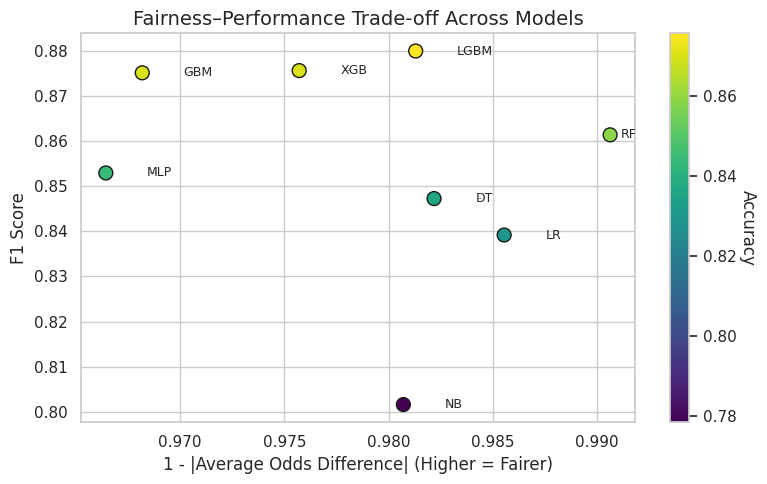

Balanced Best Model: LGBM
Model parameters:
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 20, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 57, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
[LightGBM] [Info] Number of positive: 1793, number of negative: 1746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1232
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506640 -> initscore=0.026563
[LightGBM] [Info] Start training from scor

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1793, number of negative: 1746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1233
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506640 -> initscore=0.026563
[LightGBM] [Info] Start training from score 0.026563


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1793, number of negative: 1746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1230
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506640 -> initscore=0.026563
[LightGBM] [Info] Start training from score 0.026563


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1793, number of negative: 1746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506640 -> initscore=0.026563
[LightGBM] [Info] Start training from score 0.026563


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1793, number of negative: 1746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1147
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506640 -> initscore=0.026563
[LightGBM] [Info] Start training from score 0.026563


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1793, number of negative: 1746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506640 -> initscore=0.026563
[LightGBM] [Info] Start training from score 0.026563


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


epoch 0; iter: 0; batch classifier loss: 0.681795; batch adversarial loss: 0.785344
epoch 1; iter: 0; batch classifier loss: 0.477799; batch adversarial loss: 0.716943
epoch 2; iter: 0; batch classifier loss: 0.666854; batch adversarial loss: 0.650009
epoch 3; iter: 0; batch classifier loss: 0.386569; batch adversarial loss: 0.605868
epoch 4; iter: 0; batch classifier loss: 0.426896; batch adversarial loss: 0.580625
epoch 5; iter: 0; batch classifier loss: 0.541622; batch adversarial loss: 0.549138
epoch 6; iter: 0; batch classifier loss: 0.604585; batch adversarial loss: 0.537451
epoch 7; iter: 0; batch classifier loss: 0.376845; batch adversarial loss: 0.461306
epoch 8; iter: 0; batch classifier loss: 0.567119; batch adversarial loss: 0.589779
epoch 9; iter: 0; batch classifier loss: 0.360508; batch adversarial loss: 0.553687
epoch 0; iter: 0; batch classifier loss: 0.681795; batch adversarial loss: 0.785344
epoch 1; iter: 0; batch classifier loss: 0.477799; batch adversarial loss: 0

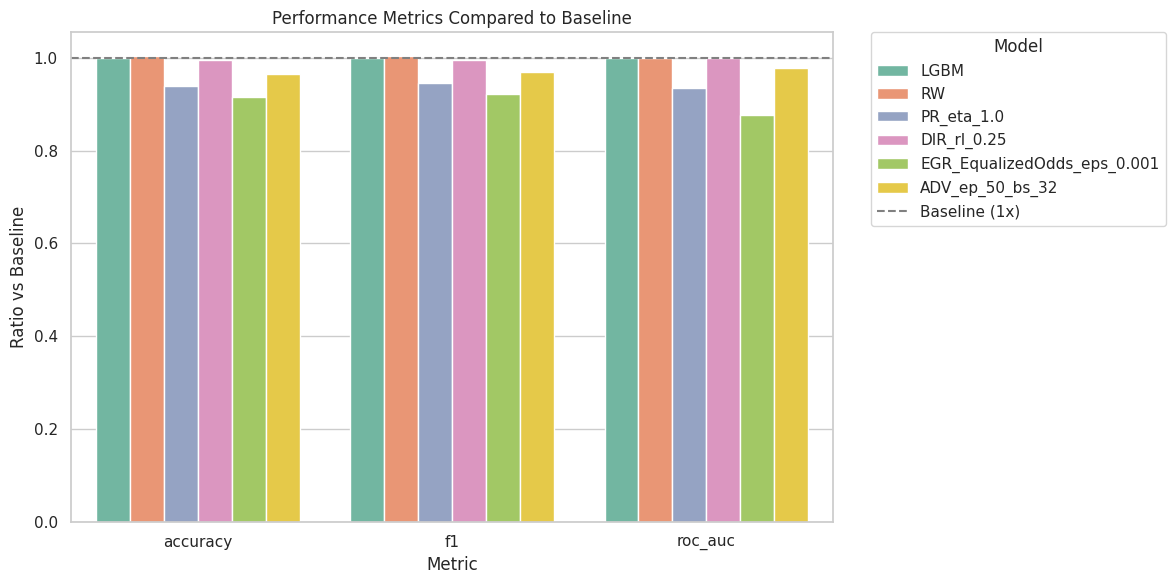

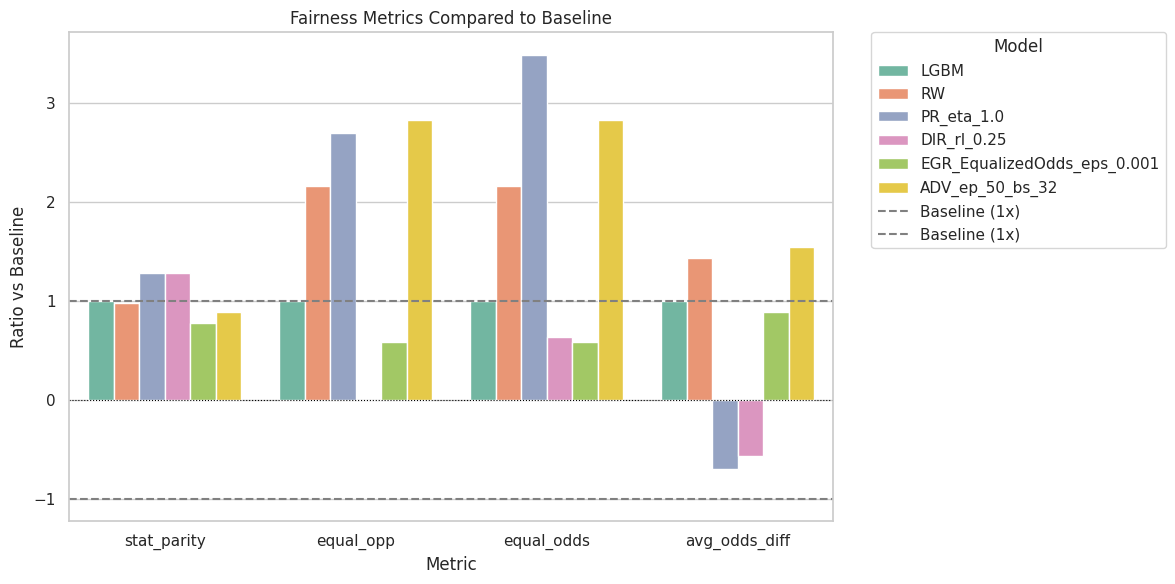

/tmp/ipython-input-2097818403.py:84: RuntimeWarning: invalid value encountered in scalar divide
  n_fav
/tmp/ipython-input-2097818403.py:89: RuntimeWarning: invalid value encountered in scalar divide
  n_unfav
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1793, number of negative: 1746
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1232
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506640 -> initscore=0.026563
[LightGBM] [Info] Start training from score 0.026563


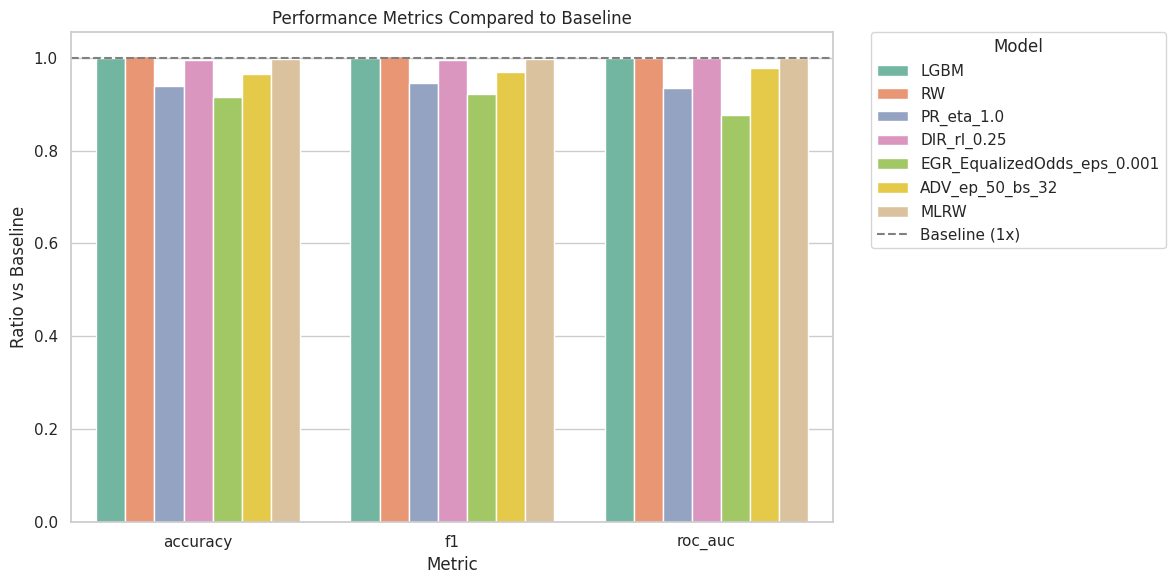

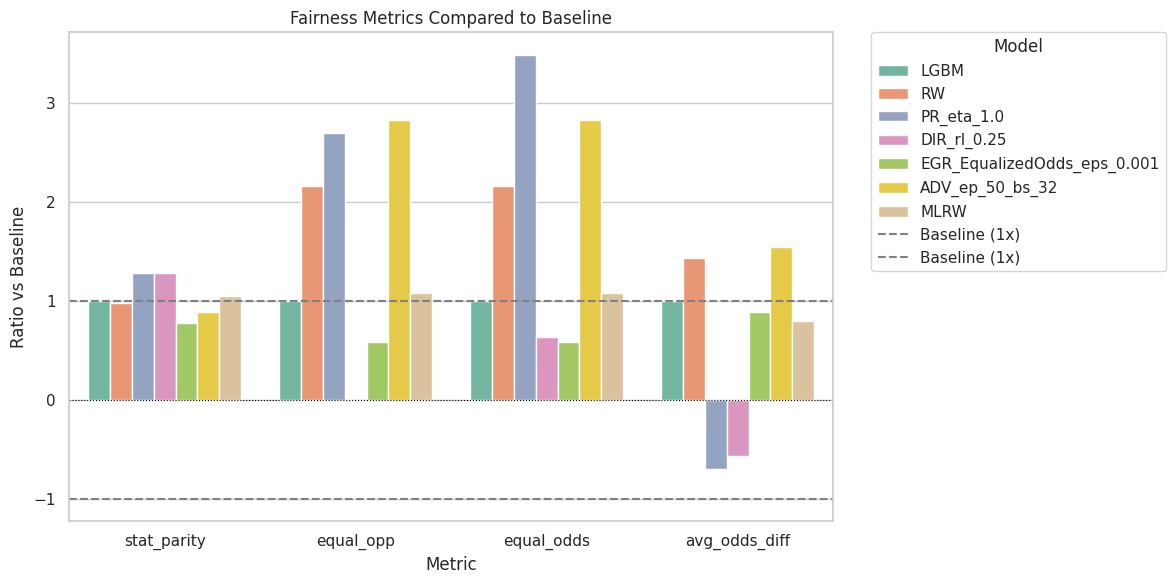

In [ ]:
combined_results_flip_1, combined_final_flip_1 = run_fair_ml_pipeline(
    data=bias_adjust_flip_1,
    target=target,
    sensitive_feature=sensitive_feature,
    param_grid=param_grid
)

In [ ]:
combined_final_flip_1.style.apply(
    highlight_max, subset=['accuracy', 'f1', 'roc_auc', 'tpr']).apply(
        highlight_min_abs, subset=['stat_parity', 'equal_opp', 'equal_odds', 'avg_odds_diff', 'fpr', 'fnr'])

In [ ]:
# Export the results DataFrame to a CSV file
combined_final_flip_1.to_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/Student/Student_Age_Flip1.csv')

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:39:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 1386, number of negative: 2153
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1229
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.391636 -> initscore=-0.440440
[LightGBM] [Info] Start training from score -0.440440
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

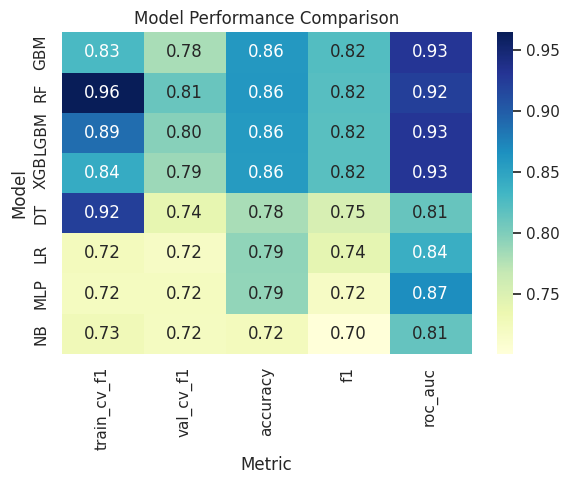

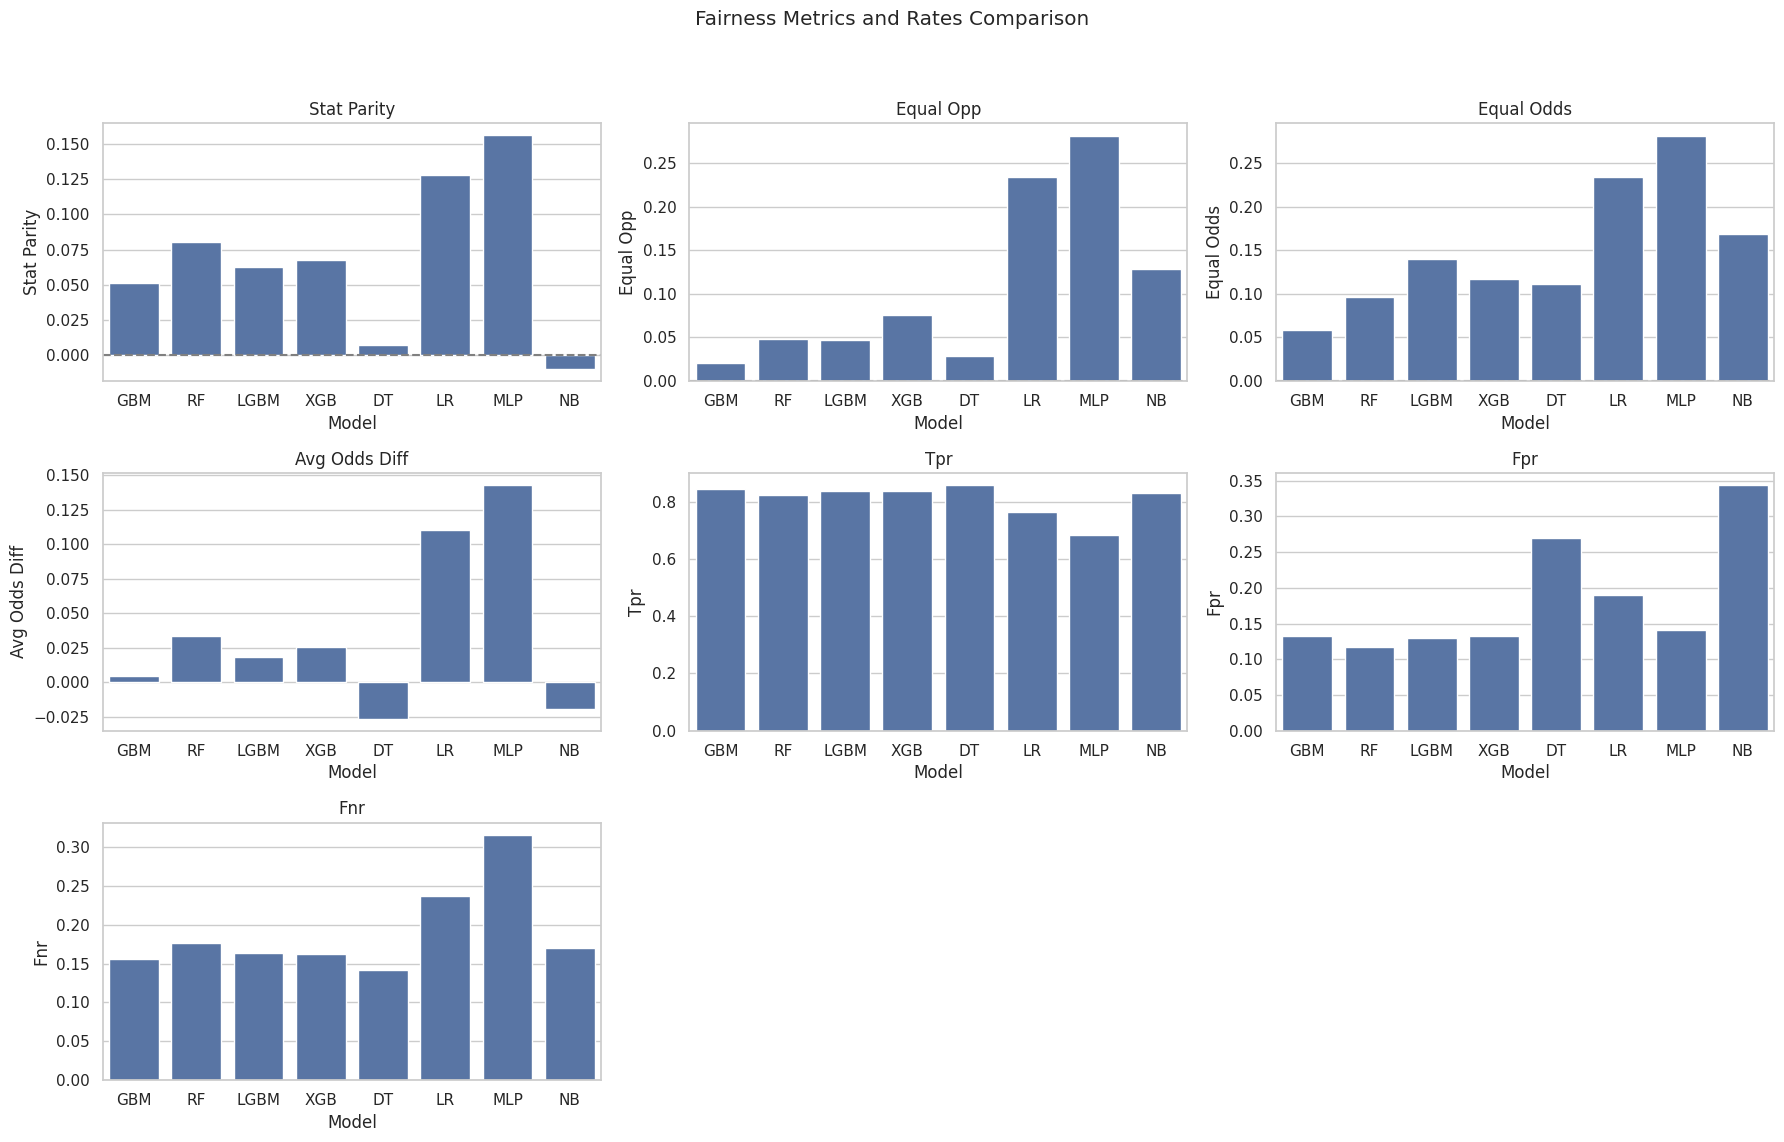

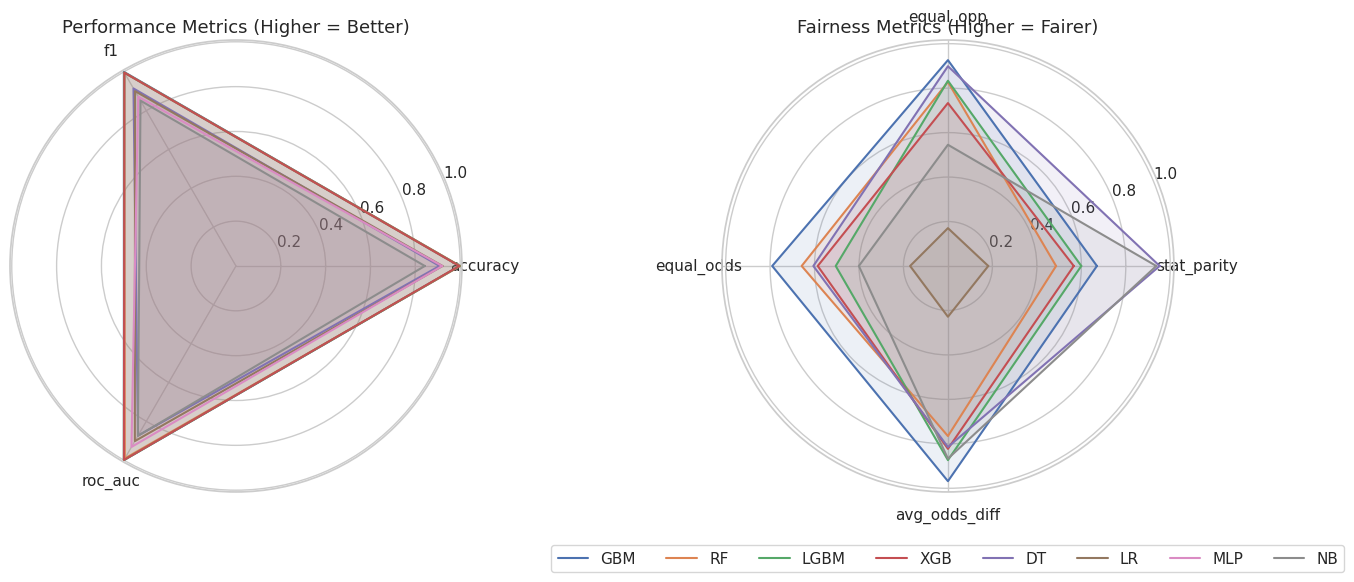

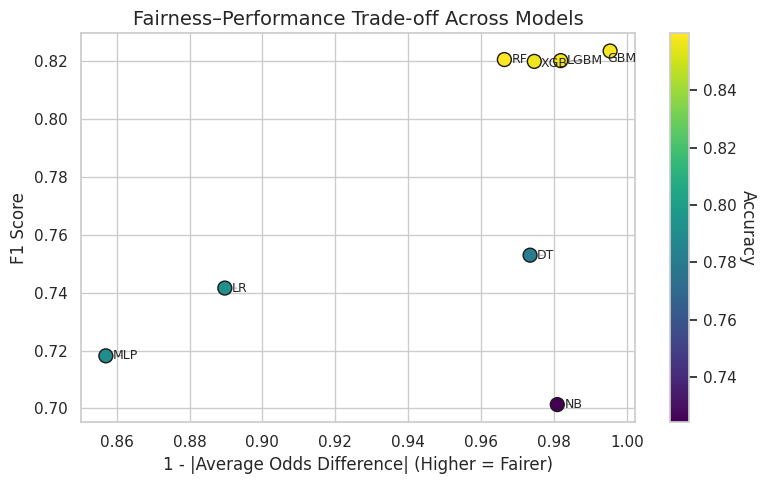

Balanced Best Model: GBM
Model parameters:
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 57, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler 

epoch 0; iter: 0; batch classifier loss: 0.701747; batch adversarial loss: 0.777091
epoch 1; iter: 0; batch classifier loss: 0.443719; batch adversarial loss: 0.660037
epoch 2; iter: 0; batch classifier loss: 0.591779; batch adversarial loss: 0.635129
epoch 3; iter: 0; batch classifier loss: 0.546602; batch adversarial loss: 0.614252
epoch 4; iter: 0; batch classifier loss: 0.482383; batch adversarial loss: 0.594647
epoch 5; iter: 0; batch classifier loss: 0.666663; batch adversarial loss: 0.605477
epoch 6; iter: 0; batch classifier loss: 0.505761; batch adversarial loss: 0.620351
epoch 7; iter: 0; batch classifier loss: 0.362684; batch adversarial loss: 0.550098
epoch 8; iter: 0; batch classifier loss: 0.494013; batch adversarial loss: 0.568343
epoch 9; iter: 0; batch classifier loss: 0.419156; batch adversarial loss: 0.583976
epoch 0; iter: 0; batch classifier loss: 0.701747; batch adversarial loss: 0.777091
epoch 1; iter: 0; batch classifier loss: 0.443719; batch adversarial loss: 0

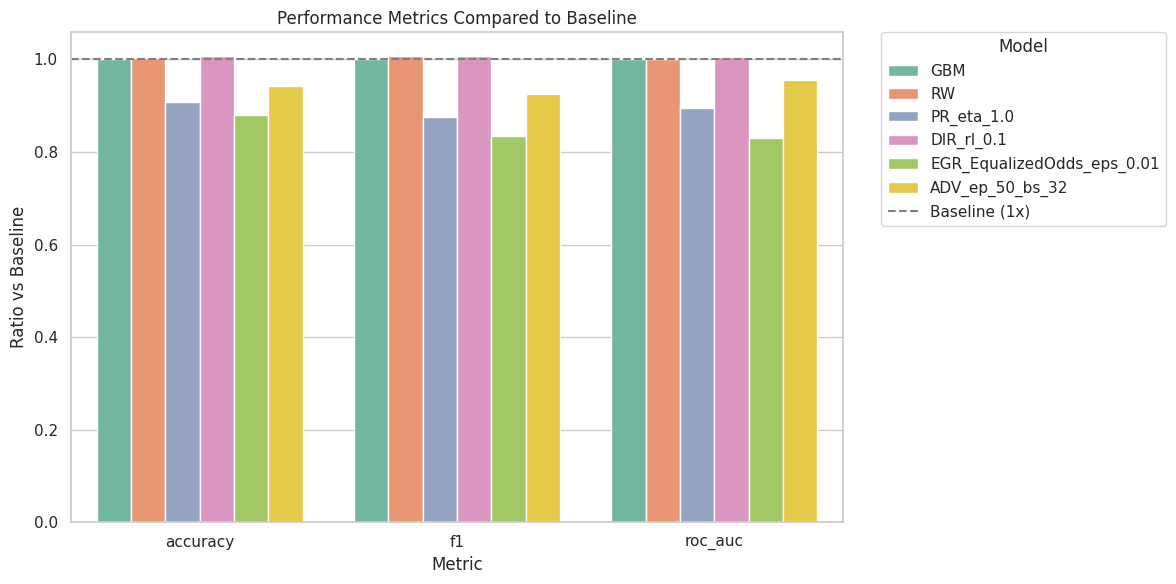

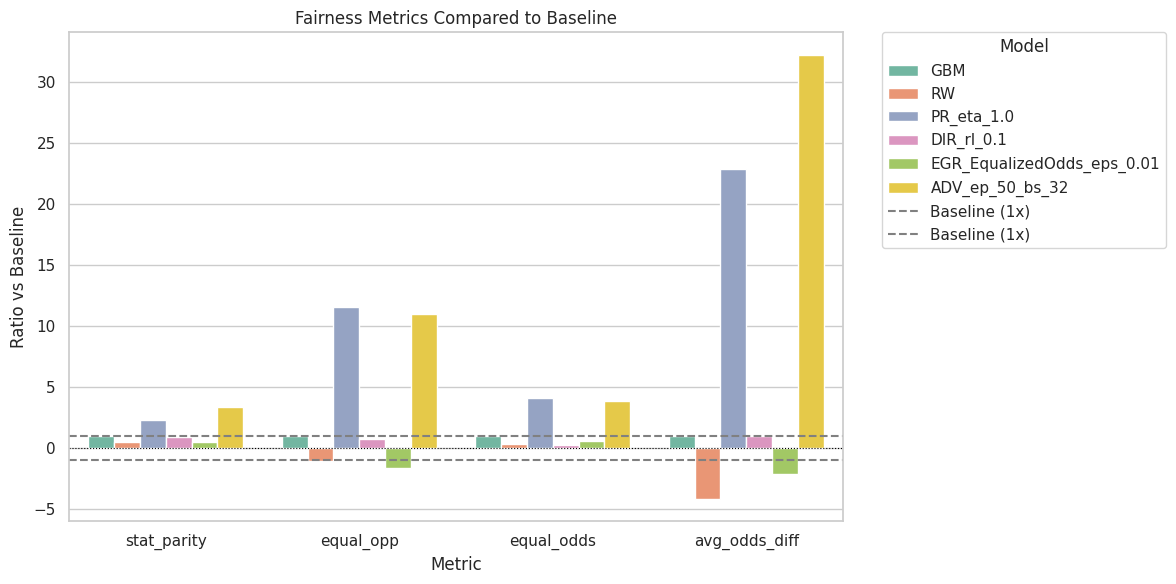

/tmp/ipython-input-2097818403.py:84: RuntimeWarning: invalid value encountered in scalar divide
  n_fav
/tmp/ipython-input-2097818403.py:89: RuntimeWarning: invalid value encountered in scalar divide
  n_unfav
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


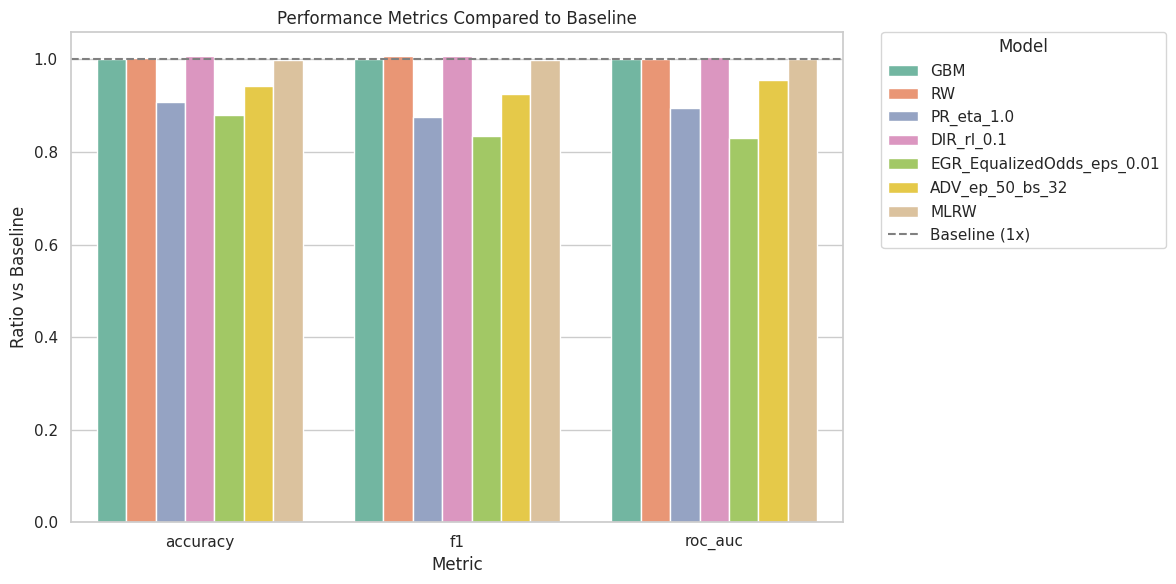

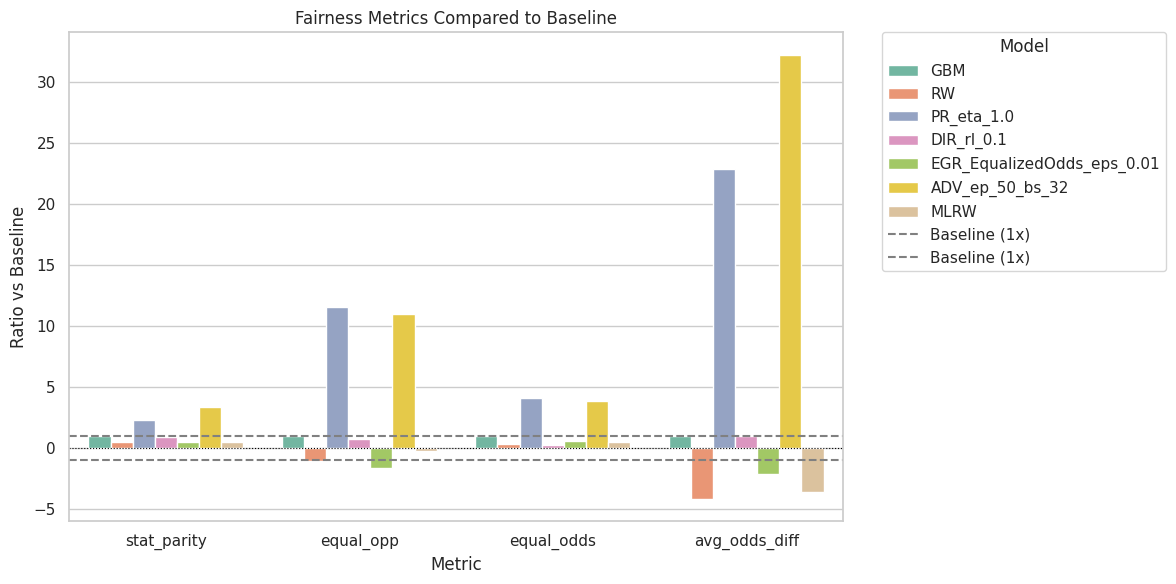

In [ ]:
combined_results_flip_2, combined_final_flip_2 = run_fair_ml_pipeline(
    data=bias_adjust_flip_2,
    target=target,
    sensitive_feature=sensitive_feature,
    param_grid=param_grid
)

In [ ]:
combined_final_flip_2.style.apply(
    highlight_max, subset=['accuracy', 'f1', 'roc_auc', 'tpr']).apply(
        highlight_min_abs, subset=['stat_parity', 'equal_opp', 'equal_odds', 'avg_odds_diff', 'fpr', 'fnr'])

In [ ]:
# Export the results DataFrame to a CSV file
combined_final_flip_2.to_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/Student/Student_Age_Flip2.csv')

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:52:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 2542, number of negative: 997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1236
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.718282 -> initscore=0.935956
[LightGBM] [Info] Start training from score 0.935956


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

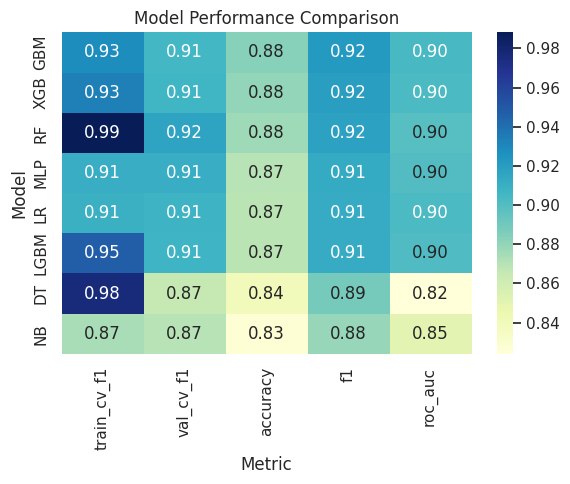

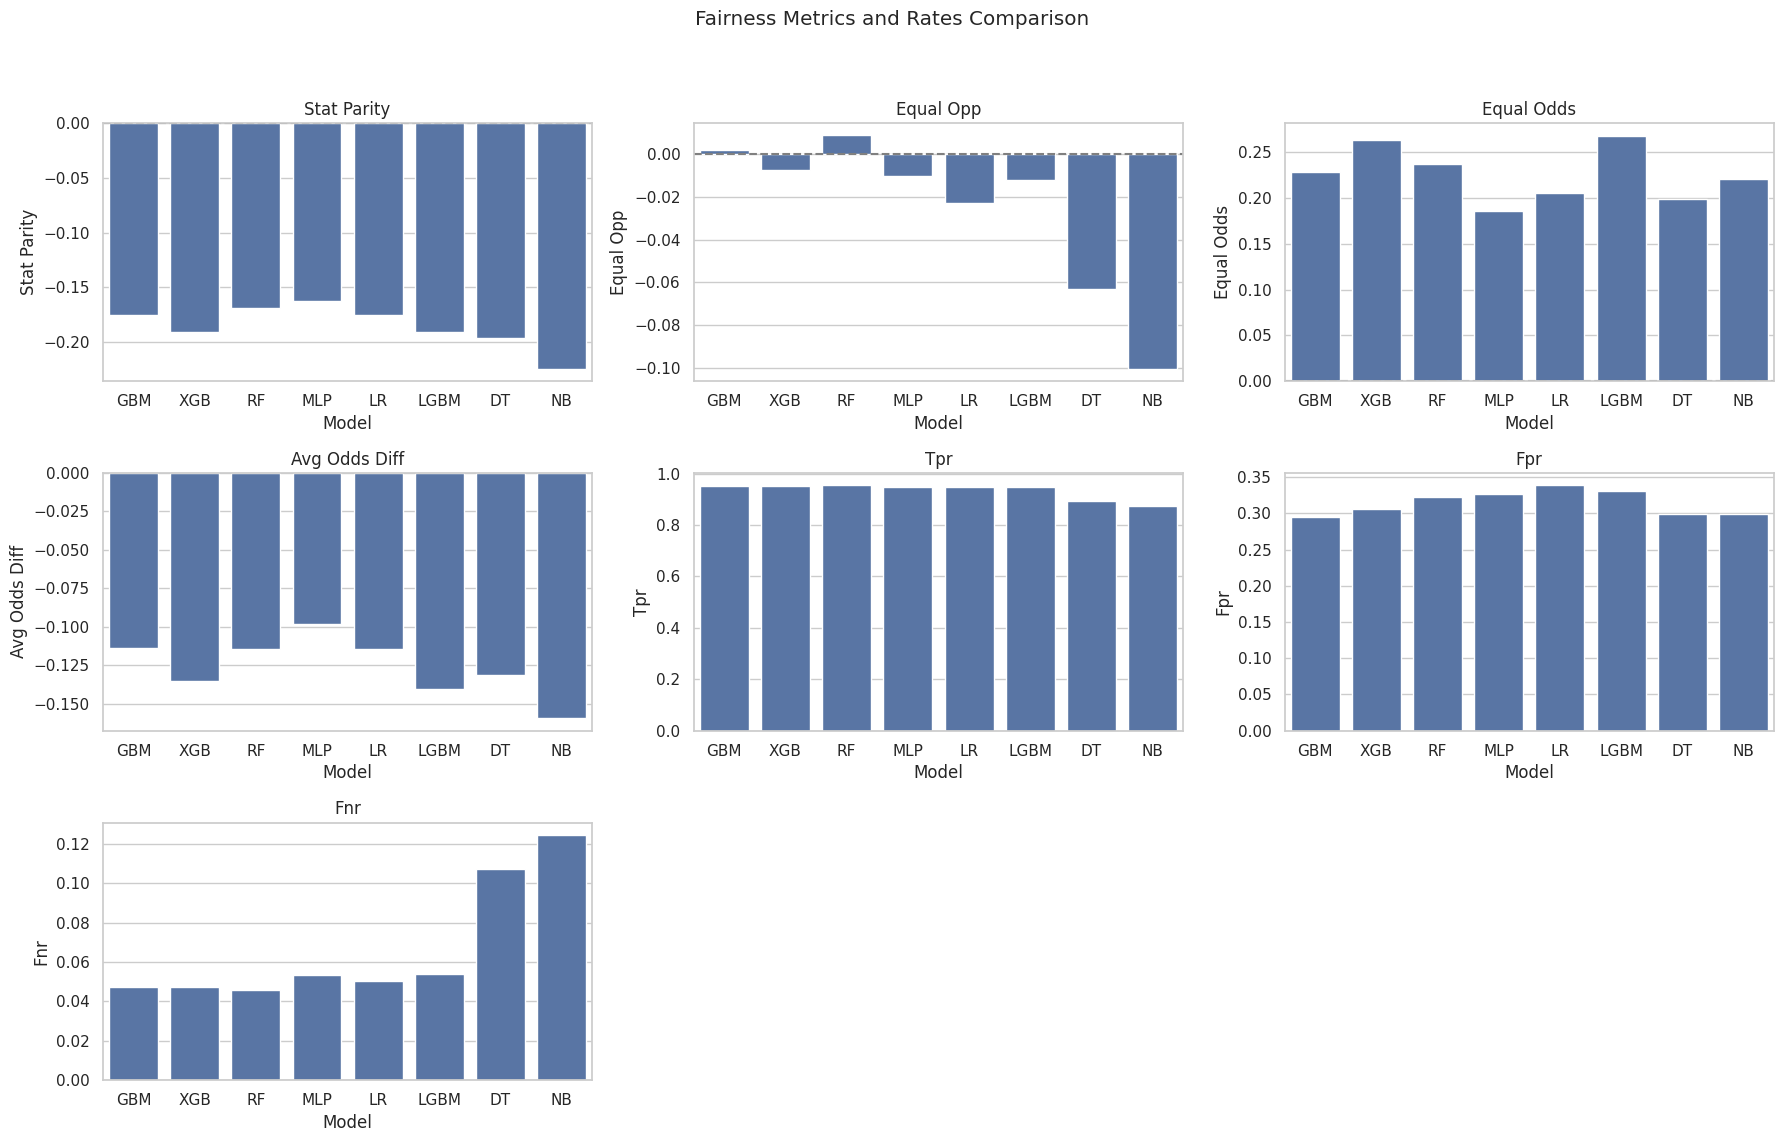

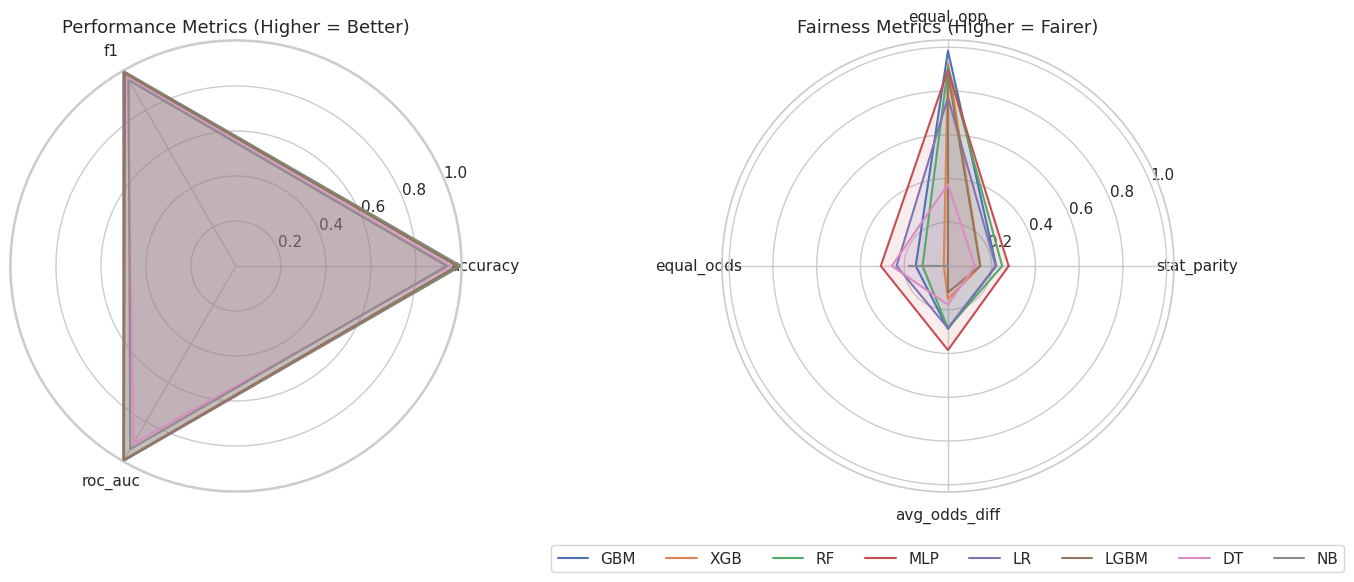

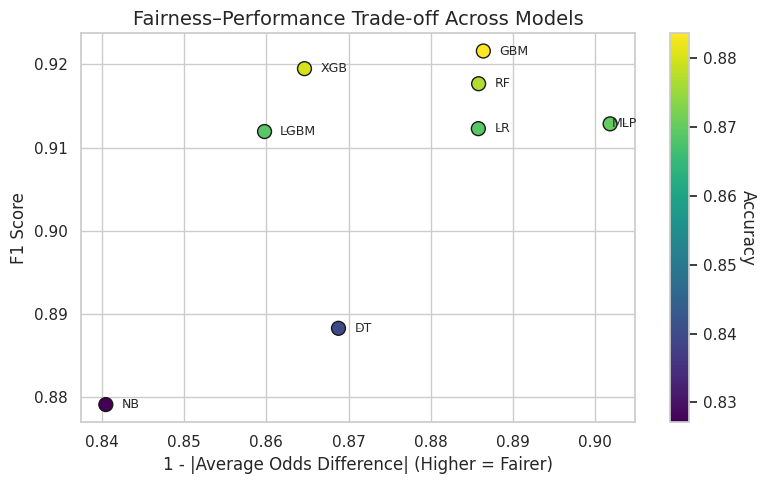

Balanced Best Model: MLP
Model parameters:
{'batch_size': 64, 'epochs': 20, 'hidden_dim': 64, 'input_dim': 36, 'lr': 0.001, 'random_state': 42}
epoch 0; iter: 0; batch classifier loss: 0.602163; batch adversarial loss: 0.827160
epoch 1; iter: 0; batch classifier loss: 0.499258; batch adversarial loss: 0.711793
epoch 2; iter: 0; batch classifier loss: 0.339330; batch adversarial loss: 0.687333
epoch 3; iter: 0; batch classifier loss: 0.216718; batch adversarial loss: 0.601106
epoch 4; iter: 0; batch classifier loss: 0.409862; batch adversarial loss: 0.678346
epoch 5; iter: 0; batch classifier loss: 0.337122; batch adversarial loss: 0.609950
epoch 6; iter: 0; batch classifier loss: 0.409163; batch adversarial loss: 0.536553
epoch 7; iter: 0; batch classifier loss: 0.232240; batch adversarial loss: 0.685082
epoch 8; iter: 0; batch classifier loss: 0.168695; batch adversarial loss: 0.500380
epoch 9; iter: 0; batch classifier loss: 0.411517; batch adversarial loss: 0.496129
epoch 0; iter: 0

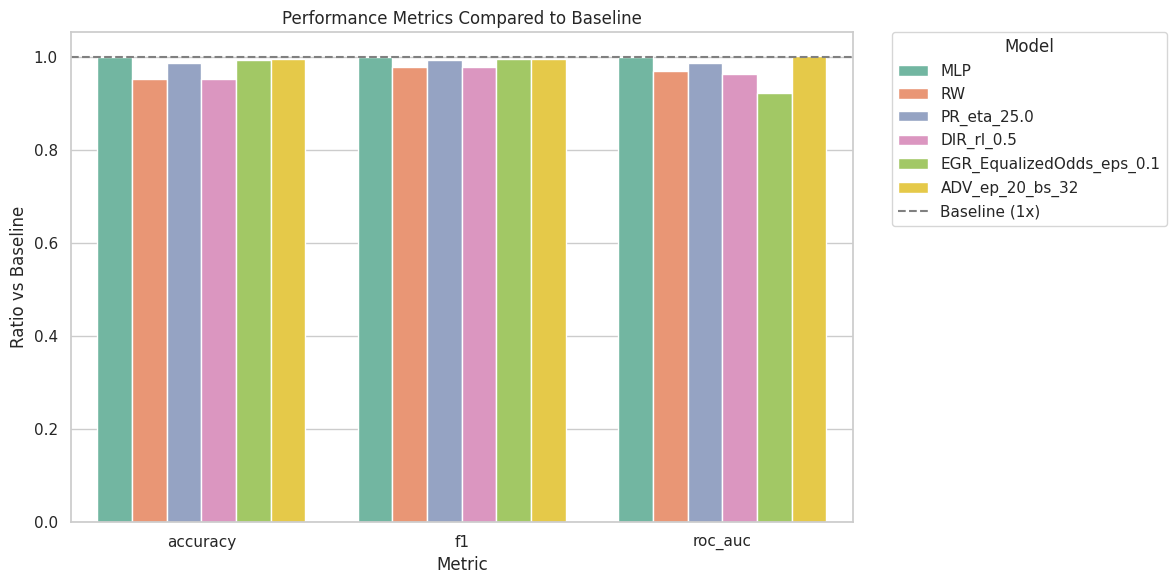

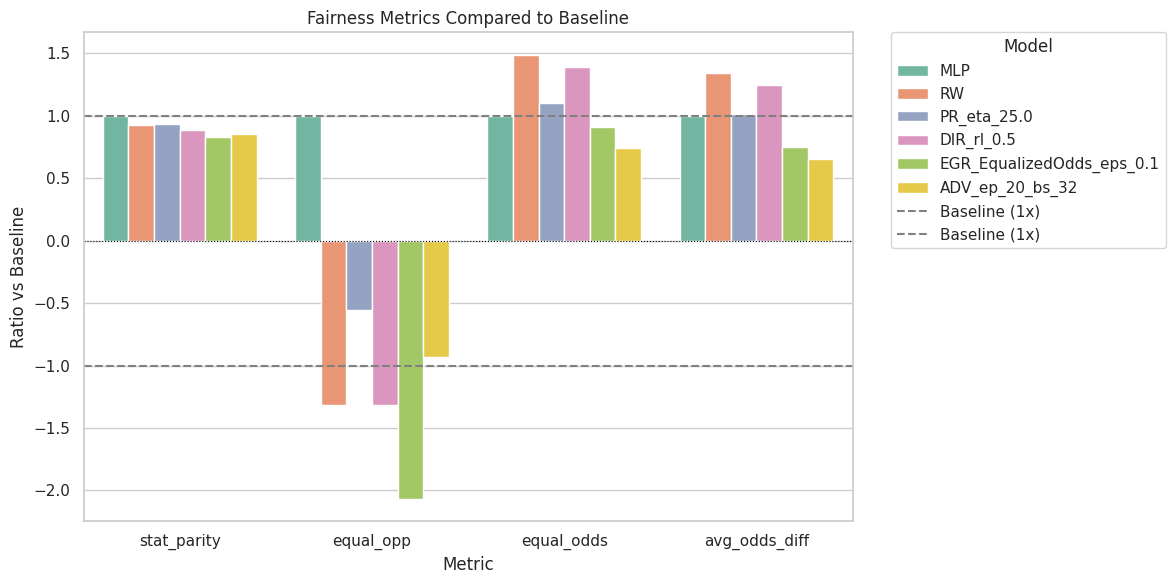

/tmp/ipython-input-2097818403.py:84: RuntimeWarning: invalid value encountered in scalar divide
  n_fav
/tmp/ipython-input-2097818403.py:89: RuntimeWarning: invalid value encountered in scalar divide
  n_unfav


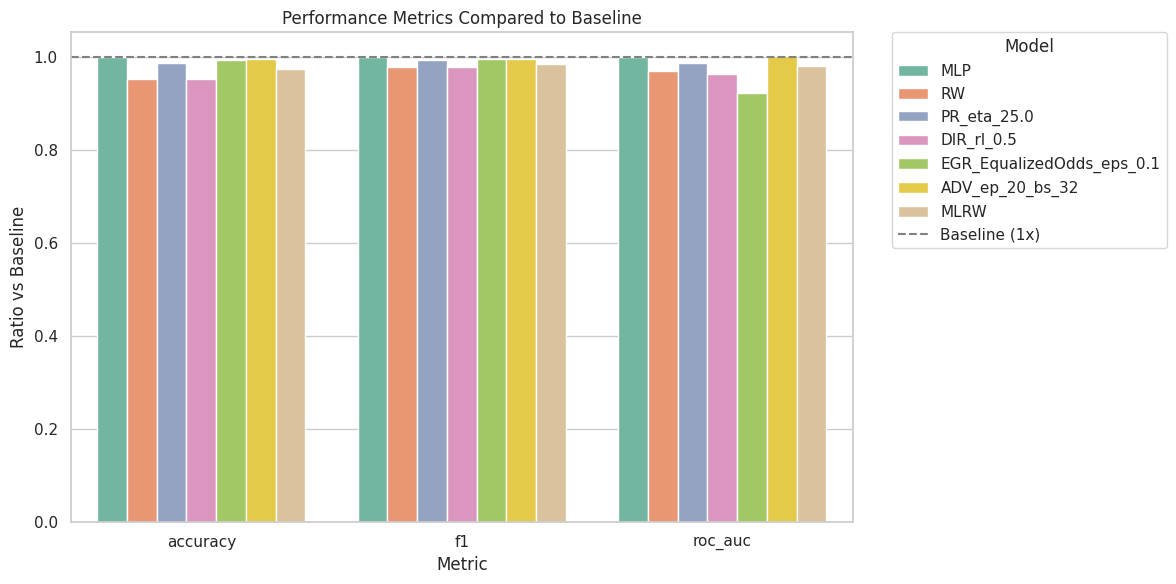

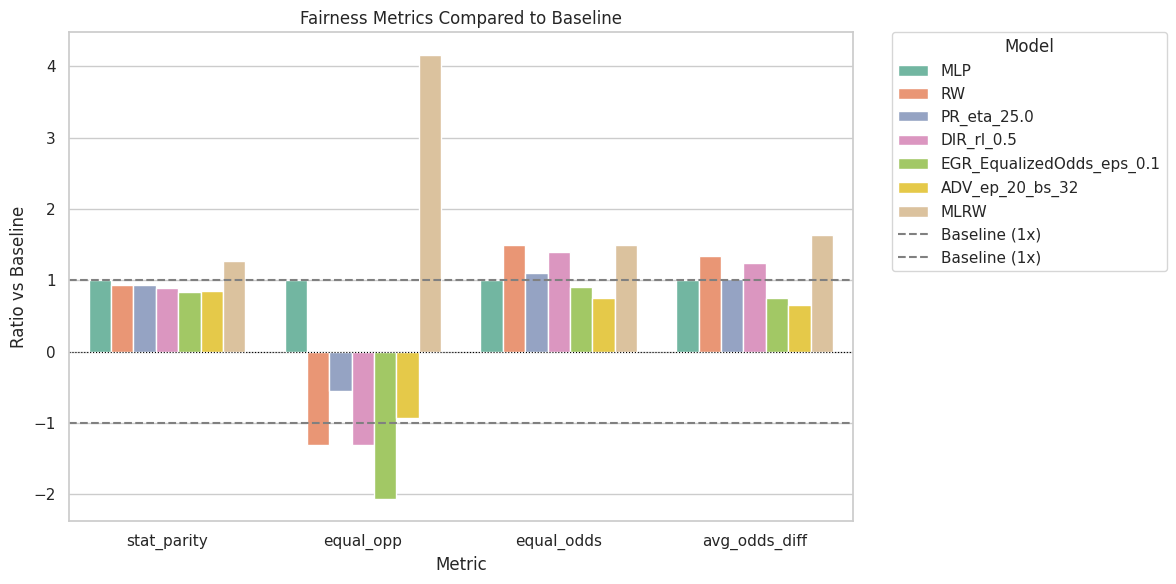

In [ ]:
combined_results_flip_3, combined_final_flip_3 = run_fair_ml_pipeline(
    data=bias_adjust_flip_3,
    target=target,
    sensitive_feature=sensitive_feature,
    param_grid=param_grid
)

In [ ]:
combined_final_flip_3.style.apply(
    highlight_max, subset=['accuracy', 'f1', 'roc_auc', 'tpr']).apply(
        highlight_min_abs, subset=['stat_parity', 'equal_opp', 'equal_odds', 'avg_odds_diff', 'fpr', 'fnr'])

In [ ]:
# Export the results DataFrame to a CSV file
combined_final_flip_3.to_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/Student/Student_Age_Flip3.csv')

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:01:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 2636, number of negative: 903
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1236
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.744843 -> initscore=1.071295
[LightGBM] [Info] Start training from score 1.071295


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

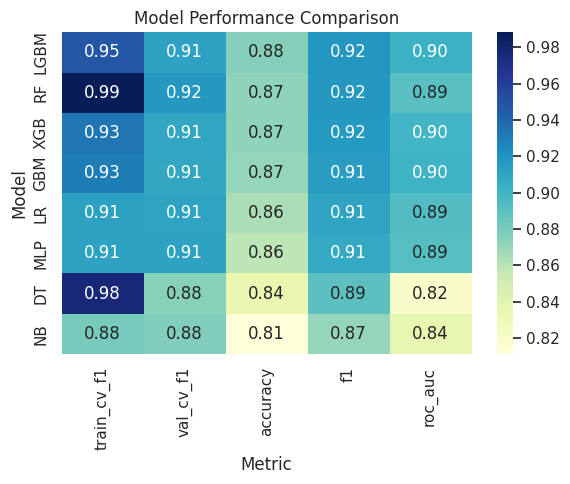

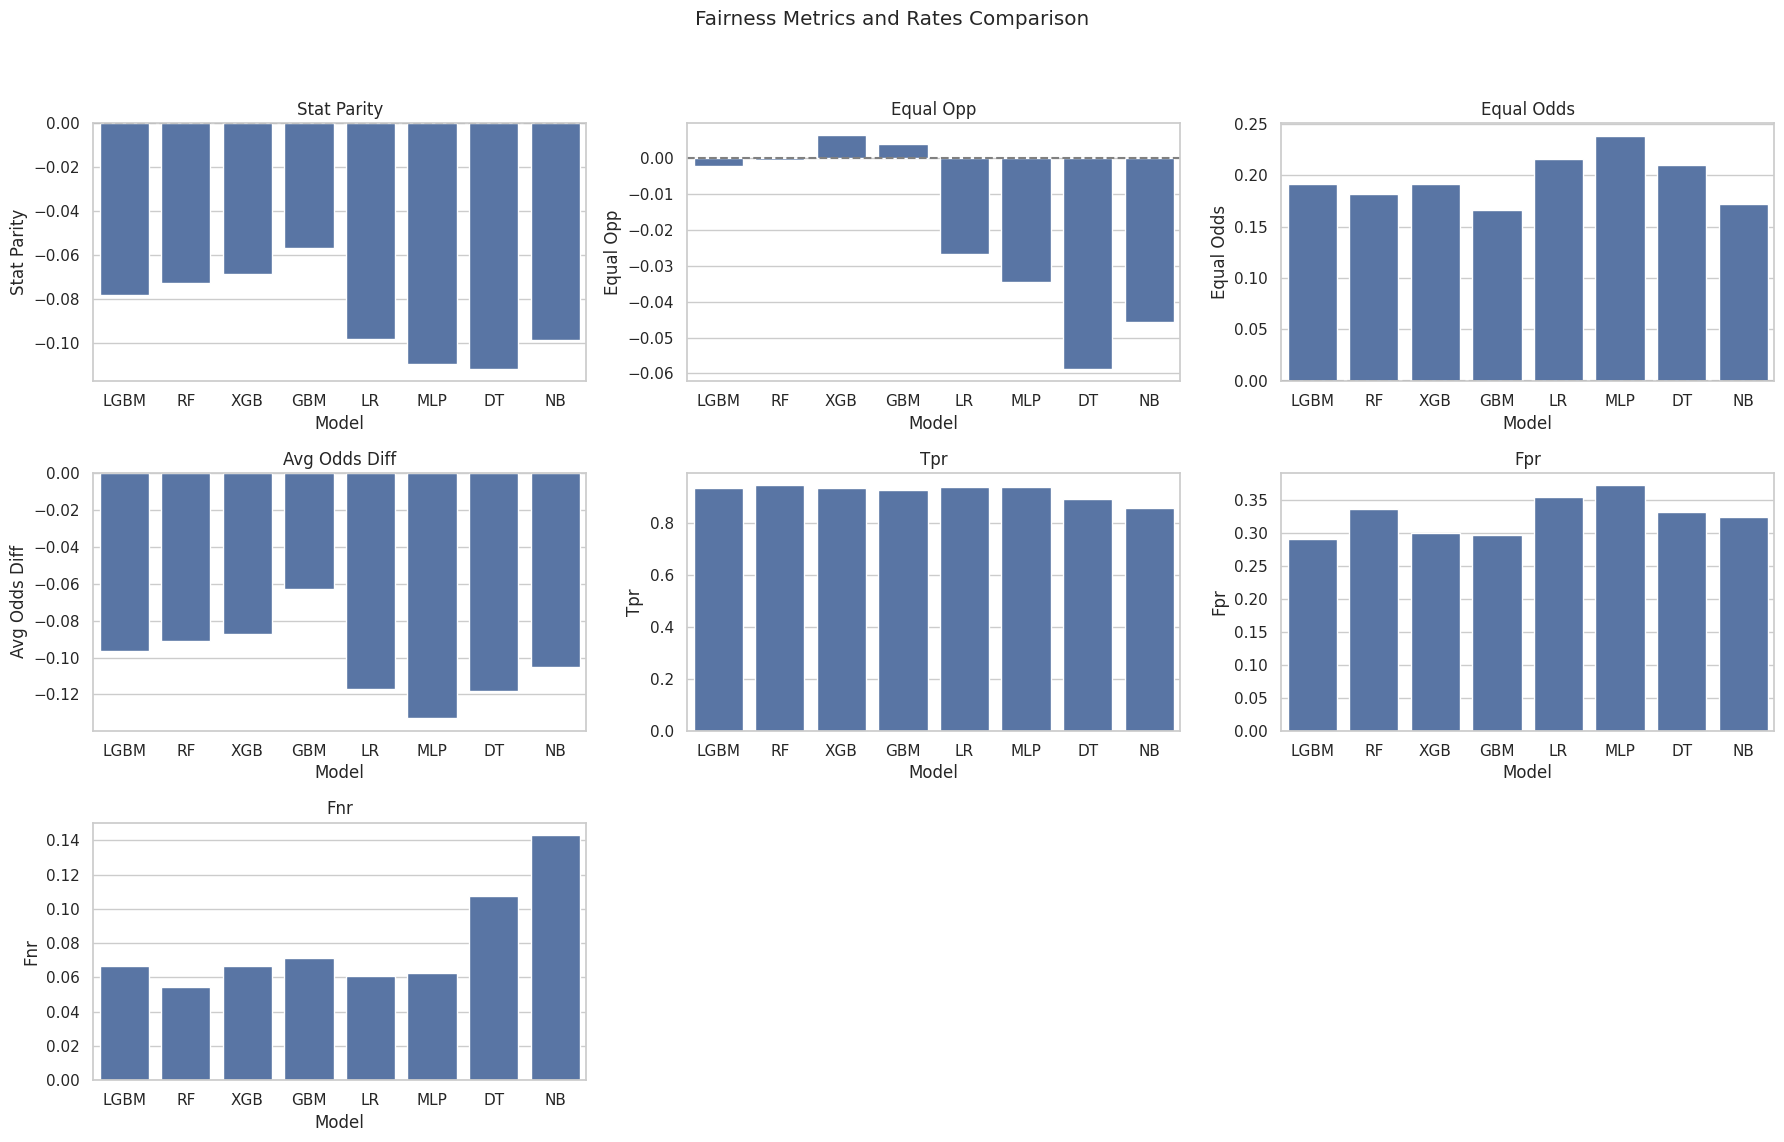

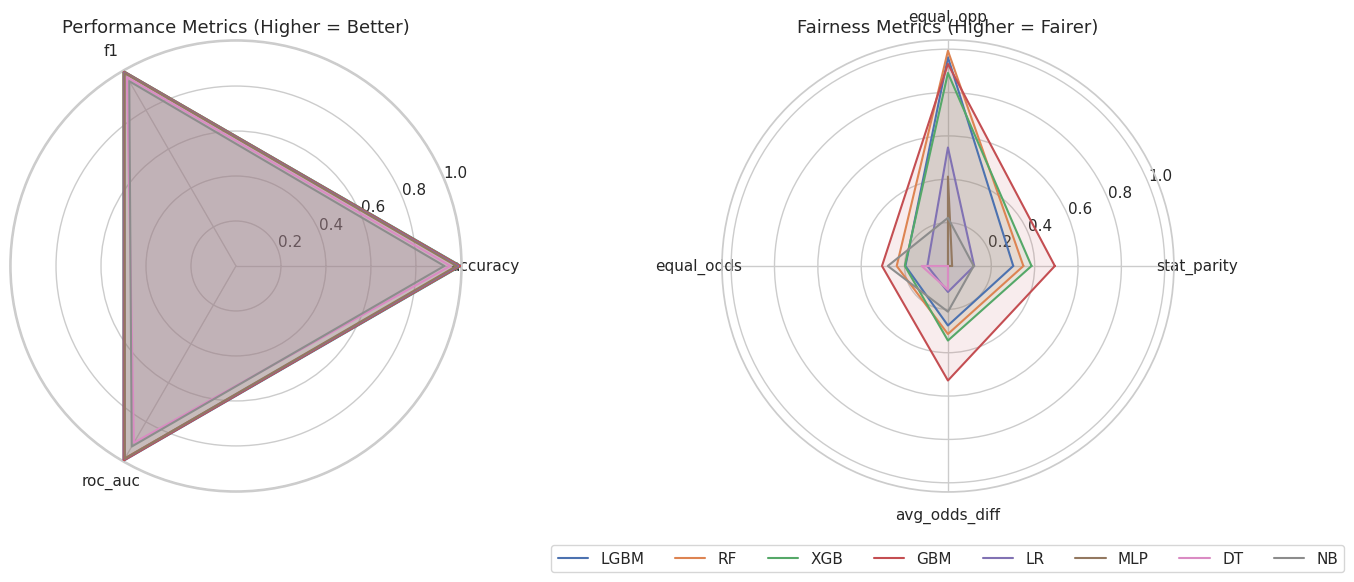

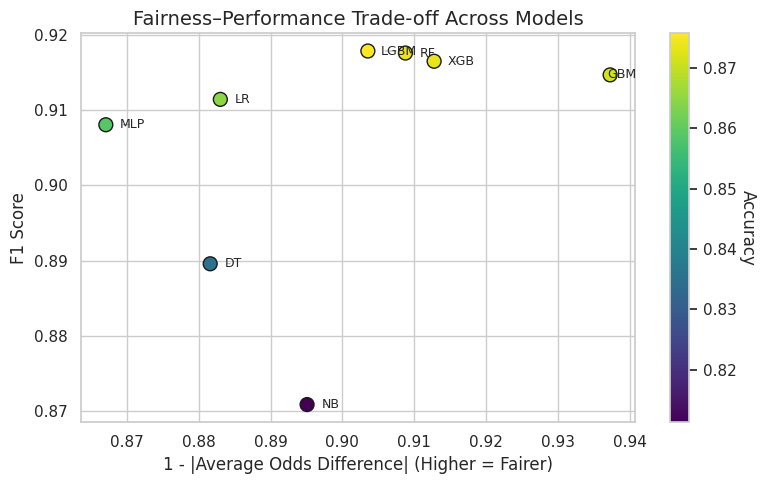

Balanced Best Model: GBM
Model parameters:
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 57, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler 

epoch 0; iter: 0; batch classifier loss: 0.584532; batch adversarial loss: 0.758538
epoch 1; iter: 0; batch classifier loss: 0.470814; batch adversarial loss: 0.731775
epoch 2; iter: 0; batch classifier loss: 0.279704; batch adversarial loss: 0.661223
epoch 3; iter: 0; batch classifier loss: 0.495490; batch adversarial loss: 0.576332
epoch 4; iter: 0; batch classifier loss: 0.227430; batch adversarial loss: 0.552872
epoch 5; iter: 0; batch classifier loss: 0.458225; batch adversarial loss: 0.613448
epoch 6; iter: 0; batch classifier loss: 0.306120; batch adversarial loss: 0.487570
epoch 7; iter: 0; batch classifier loss: 0.266160; batch adversarial loss: 0.616644
epoch 8; iter: 0; batch classifier loss: 0.461405; batch adversarial loss: 0.506528
epoch 9; iter: 0; batch classifier loss: 0.271255; batch adversarial loss: 0.521487
epoch 0; iter: 0; batch classifier loss: 0.584532; batch adversarial loss: 0.758538
epoch 1; iter: 0; batch classifier loss: 0.470814; batch adversarial loss: 0

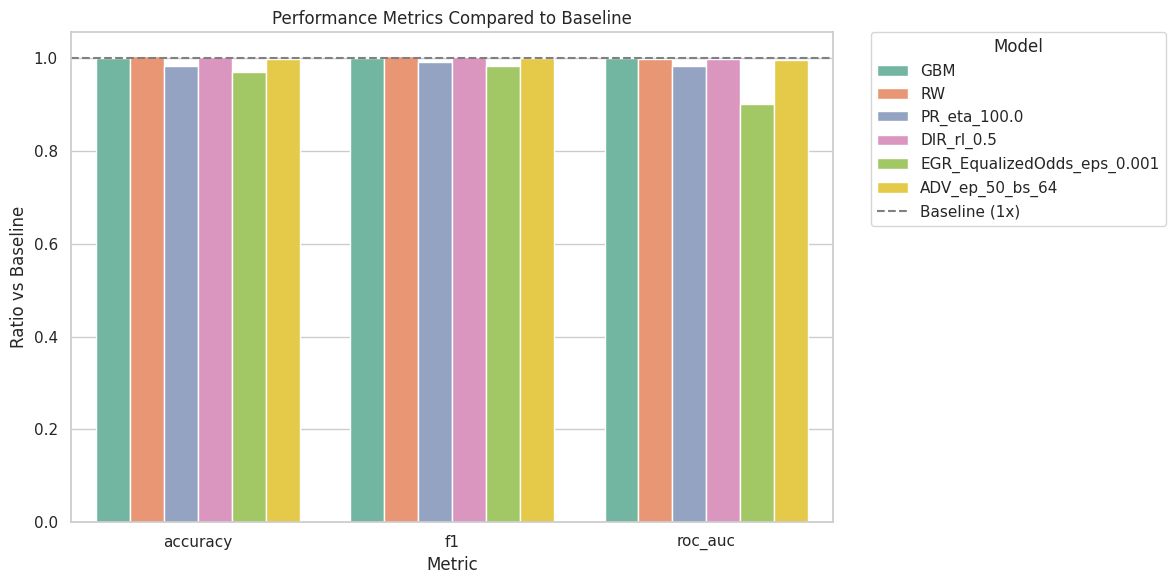

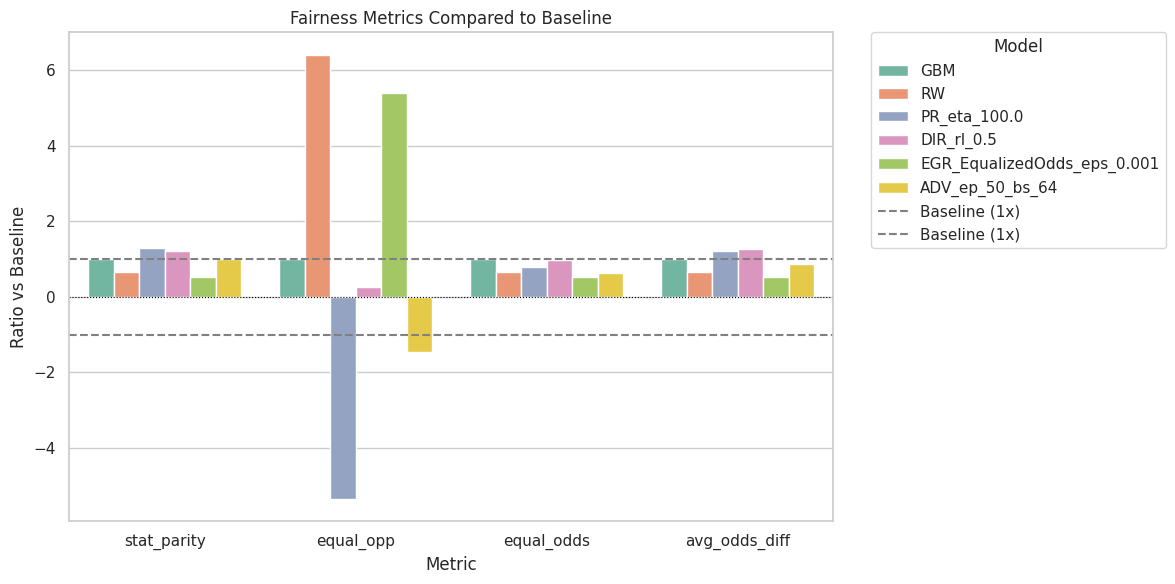

/tmp/ipython-input-2097818403.py:84: RuntimeWarning: invalid value encountered in scalar divide
  n_fav
/tmp/ipython-input-2097818403.py:89: RuntimeWarning: invalid value encountered in scalar divide
  n_unfav
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


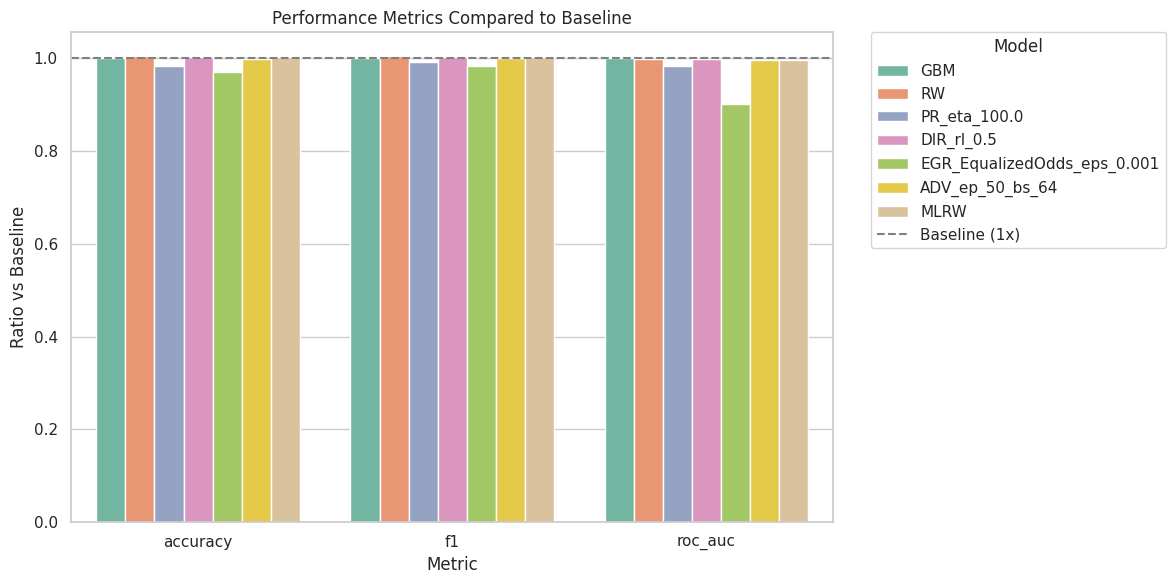

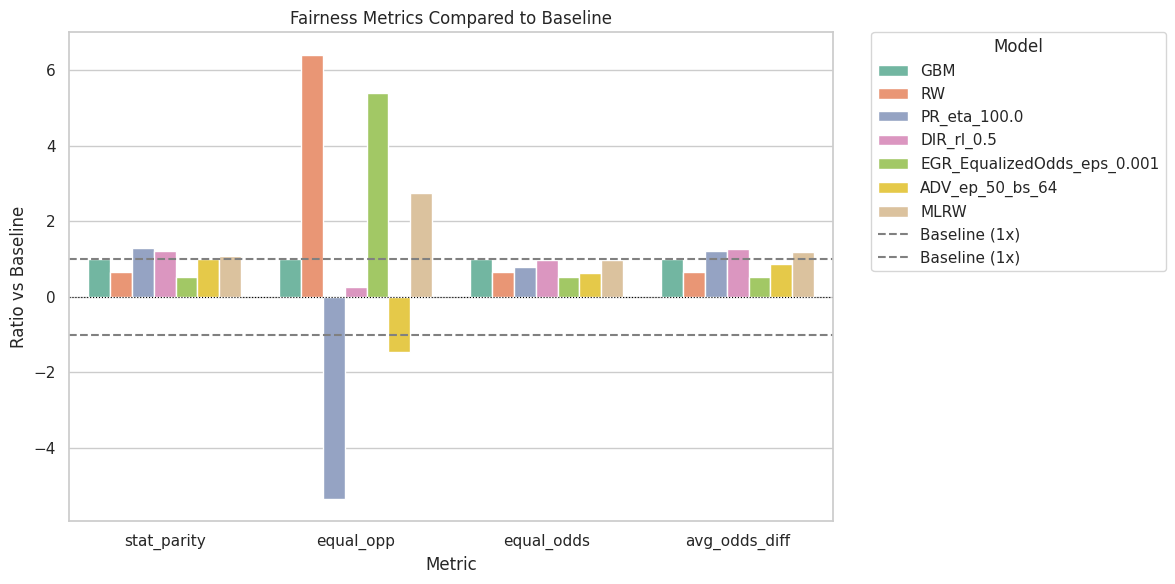

In [ ]:
combined_results_flip_4, combined_final_flip_4 = run_fair_ml_pipeline(
    data=bias_adjust_flip_4,
    target=target,
    sensitive_feature=sensitive_feature,
    param_grid=param_grid
)

In [ ]:
combined_final_flip_4.style.apply(
    highlight_max, subset=['accuracy', 'f1', 'roc_auc', 'tpr']).apply(
        highlight_min_abs, subset=['stat_parity', 'equal_opp', 'equal_odds', 'avg_odds_diff', 'fpr', 'fnr'])

In [ ]:
# Export the results DataFrame to a CSV file
combined_final_flip_4.to_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/Student/Student_Age_Flip4.csv')

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:32:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 2703, number of negative: 836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1229
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.763775 -> initscore=1.173489
[LightGBM] [Info] Start training from score 1.173489


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

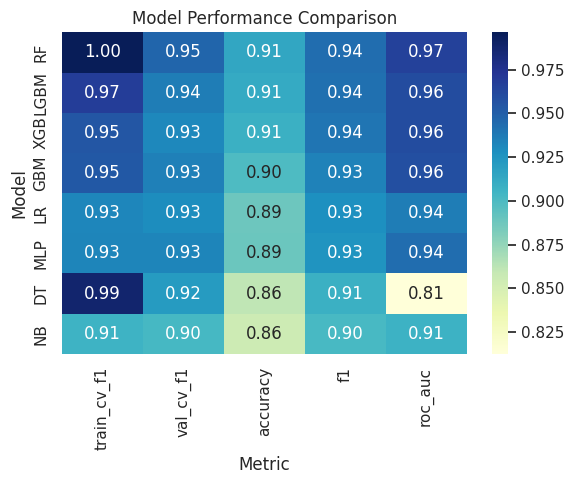

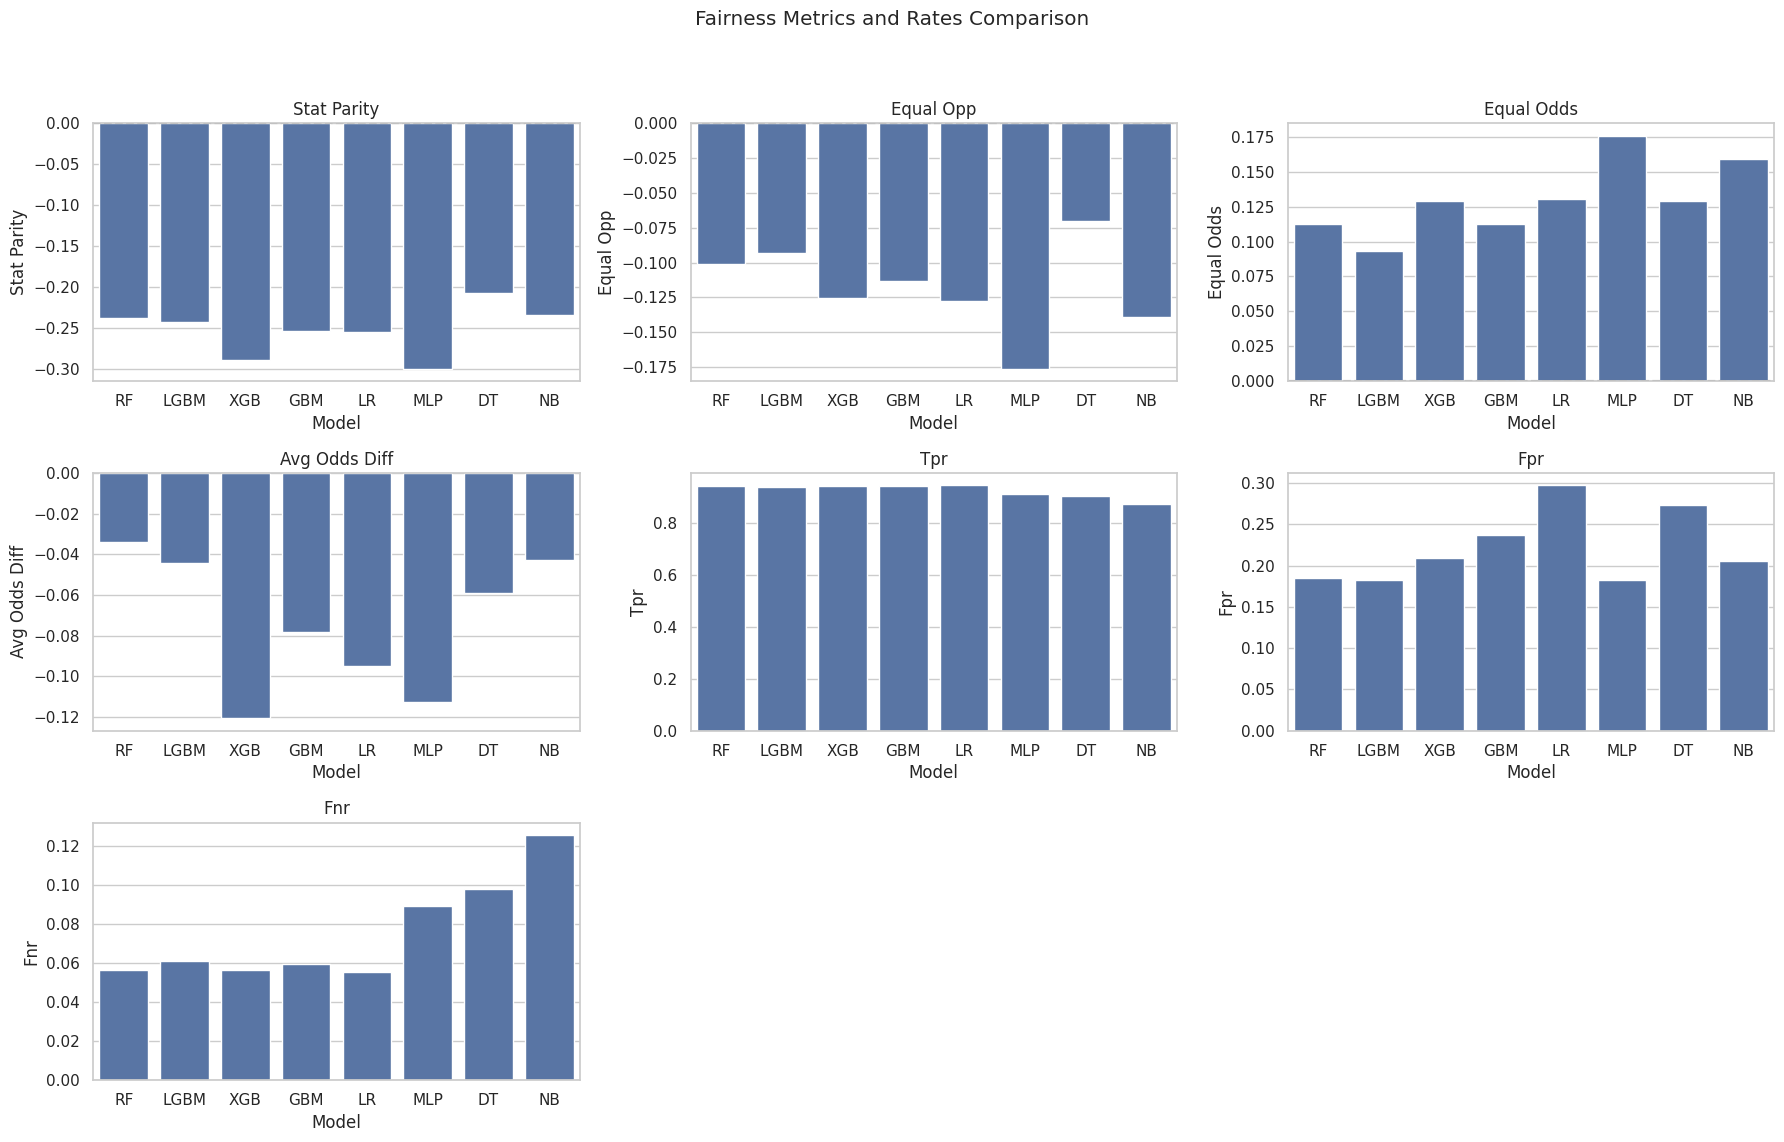

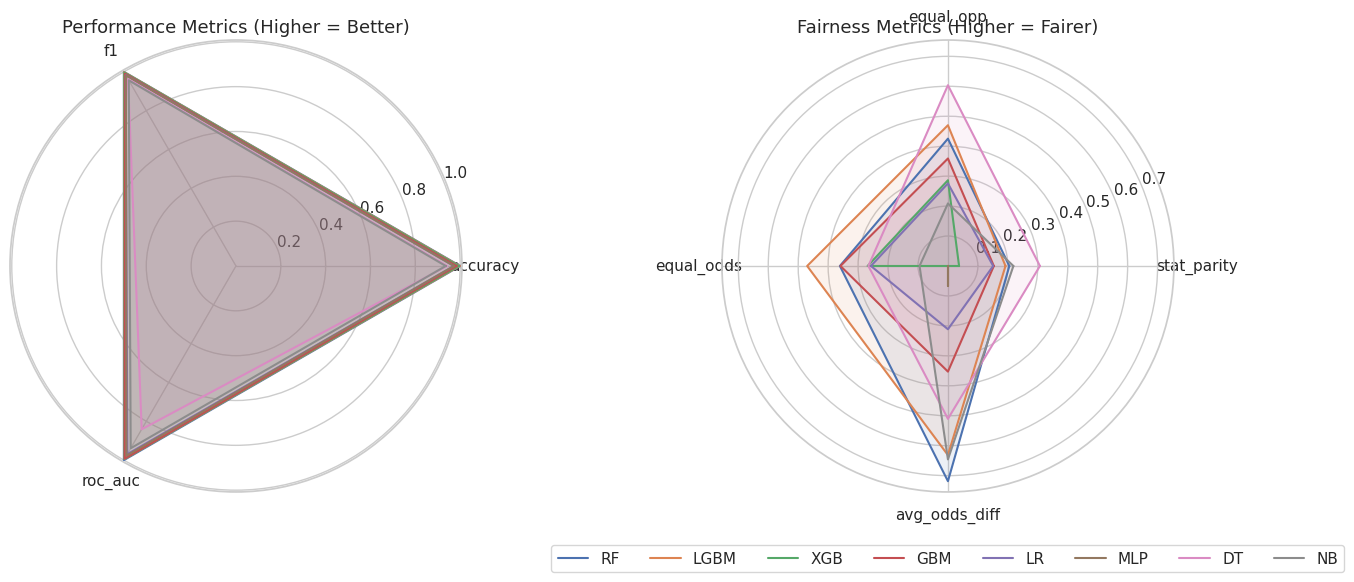

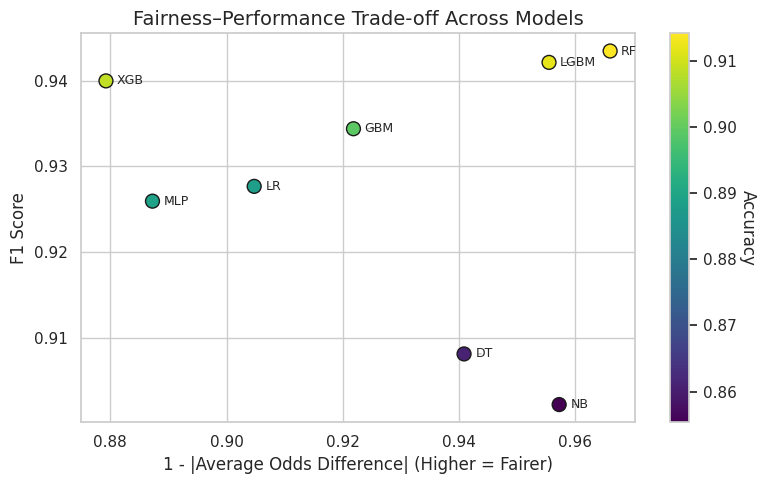

Balanced Best Model: LGBM
Model parameters:
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 20, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 57, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
[LightGBM] [Info] Number of positive: 2703, number of negative: 836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1229
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.763775 -> initscore=1.173489
[LightGBM] [Info] Start training from score

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2703, number of negative: 836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1234
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.763775 -> initscore=1.173489
[LightGBM] [Info] Start training from score 1.173489


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2703, number of negative: 836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1226
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.763775 -> initscore=1.173489
[LightGBM] [Info] Start training from score 1.173489


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2703, number of negative: 836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1209
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.763775 -> initscore=1.173489
[LightGBM] [Info] Start training from score 1.173489


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2703, number of negative: 836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.763775 -> initscore=1.173489
[LightGBM] [Info] Start training from score 1.173489


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2703, number of negative: 836
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.763775 -> initscore=1.173489
[LightGBM] [Info] Start training from score 1.173489


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


epoch 0; iter: 0; batch classifier loss: 0.623672; batch adversarial loss: 0.771468
epoch 1; iter: 0; batch classifier loss: 0.250955; batch adversarial loss: 0.752663
epoch 2; iter: 0; batch classifier loss: 0.303147; batch adversarial loss: 0.686805
epoch 3; iter: 0; batch classifier loss: 0.337431; batch adversarial loss: 0.618554
epoch 4; iter: 0; batch classifier loss: 0.149357; batch adversarial loss: 0.631096
epoch 5; iter: 0; batch classifier loss: 0.280406; batch adversarial loss: 0.656485
epoch 6; iter: 0; batch classifier loss: 0.217652; batch adversarial loss: 0.586630
epoch 7; iter: 0; batch classifier loss: 0.113552; batch adversarial loss: 0.540007
epoch 8; iter: 0; batch classifier loss: 0.274399; batch adversarial loss: 0.521193
epoch 9; iter: 0; batch classifier loss: 0.401547; batch adversarial loss: 0.645038
epoch 0; iter: 0; batch classifier loss: 0.623672; batch adversarial loss: 0.771468
epoch 1; iter: 0; batch classifier loss: 0.250955; batch adversarial loss: 0

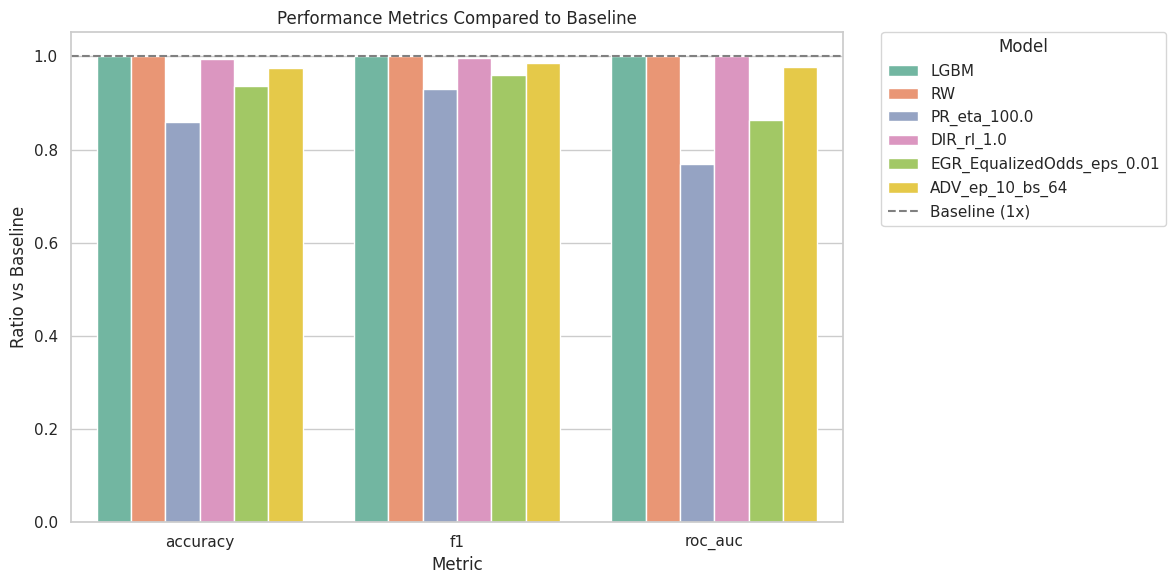

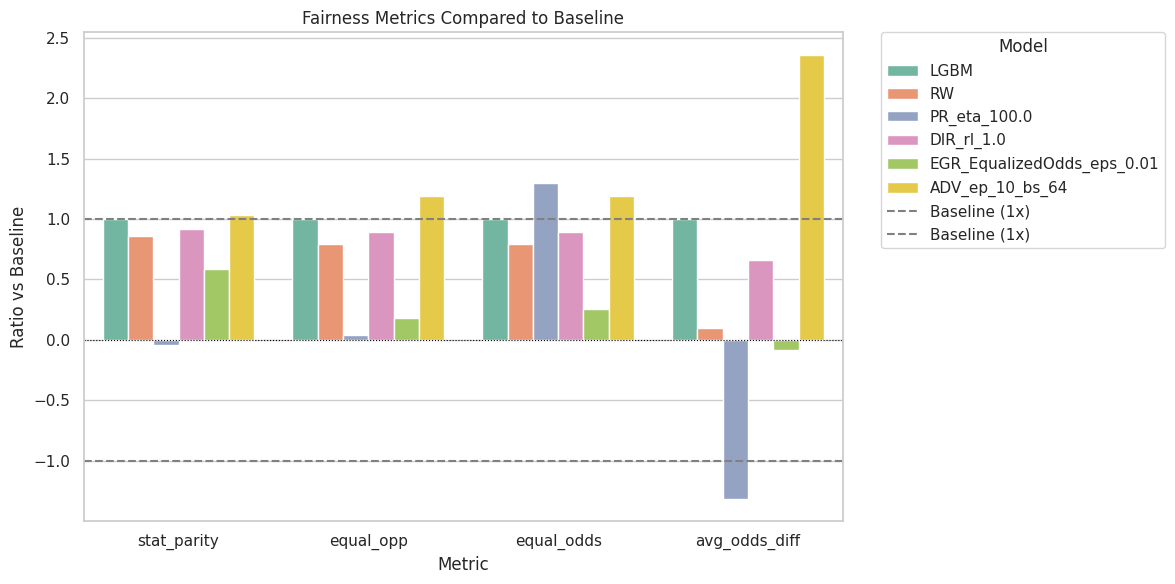

/tmp/ipython-input-2097818403.py:84: RuntimeWarning: invalid value encountered in scalar divide
  n_fav
/tmp/ipython-input-2097818403.py:89: RuntimeWarning: invalid value encountered in scalar divide
  n_unfav
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2703, number of negative: 836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1229
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.763775 -> initscore=1.173489
[LightGBM] [Info] Start training from score 1.173489


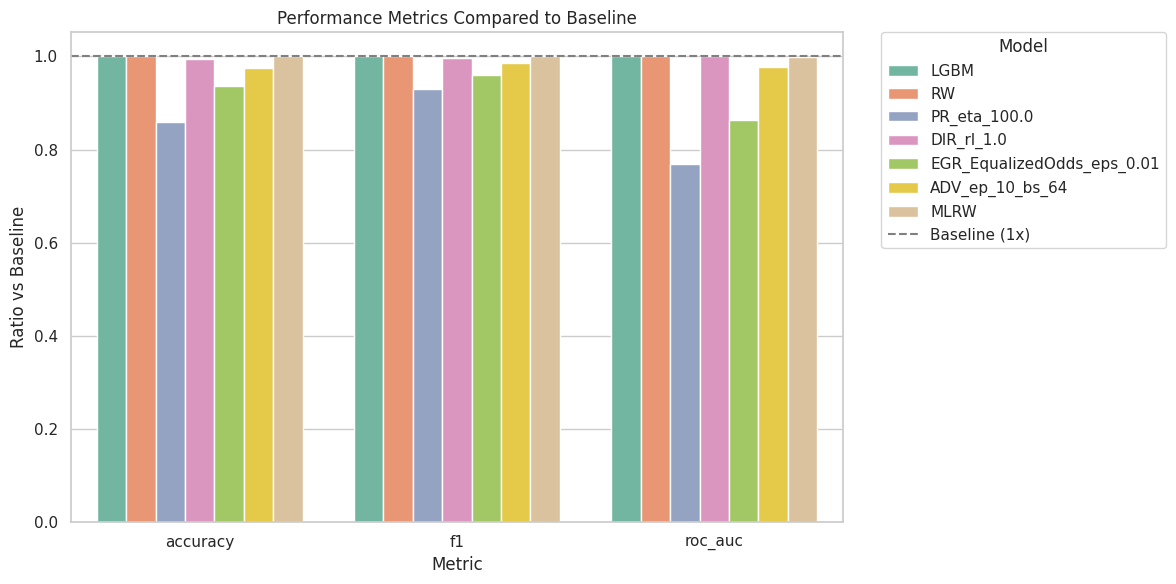

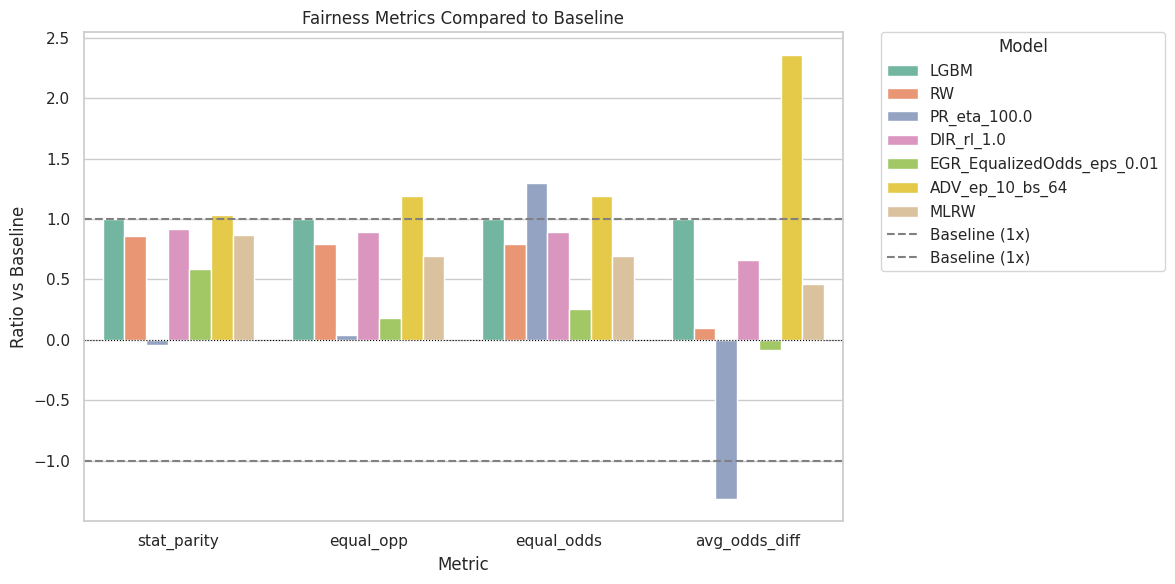

In [ ]:
combined_results_genalgo, combined_final_genalgo = run_fair_ml_pipeline(
    data=df_unfair,
    target=target,
    sensitive_feature=sensitive_feature,
    param_grid=param_grid
)

In [ ]:
combined_final_genalgo.style.apply(
    highlight_max, subset=['accuracy', 'f1', 'roc_auc', 'tpr']).apply(
        highlight_min_abs, subset=['stat_parity', 'equal_opp', 'equal_odds', 'avg_odds_diff', 'fpr', 'fnr'])

In [ ]:
# Export the results DataFrame to a CSV file
combined_final_genalgo.to_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/Student/Student_Age_GenAlgo.csv')

## Run the Boundary Flip Datasets

In [ ]:
X_train_flipped, X_test_flipped, y_train_flipped, y_test_flipped = train_test_split(X_flipped, y_flipped, test_size=0.2, random_state=random_seed, stratify=y_flipped)

In [ ]:
boundary_data = pd.concat([X_train_flipped, y_train_flipped], axis=1)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:42:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 2311, number of negative: 1228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1236
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.653009 -> initscore=0.632294
[LightGBM] [Info] Start training from score 0.632294


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

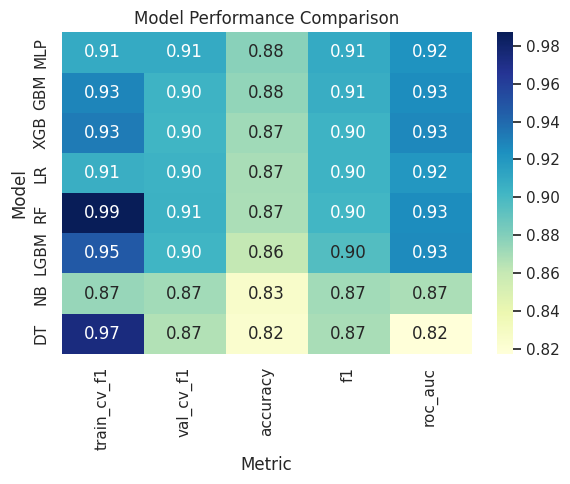

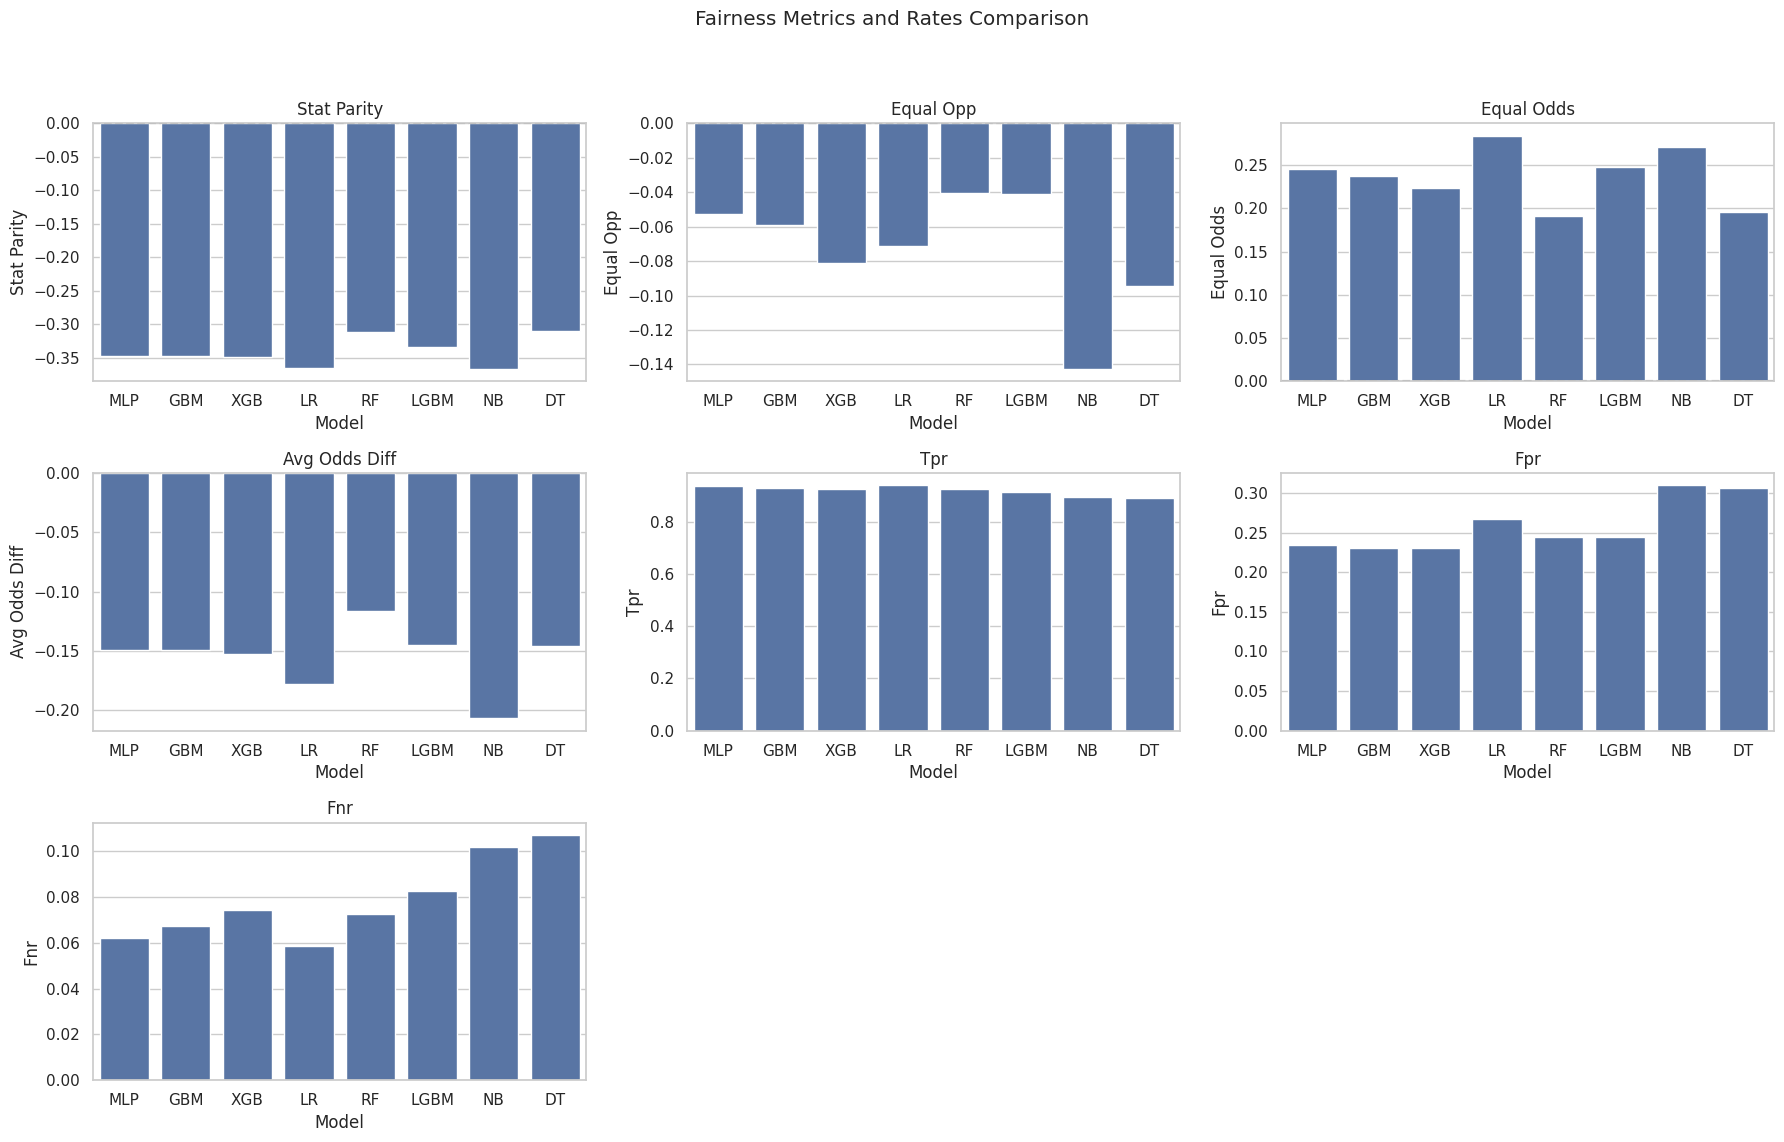

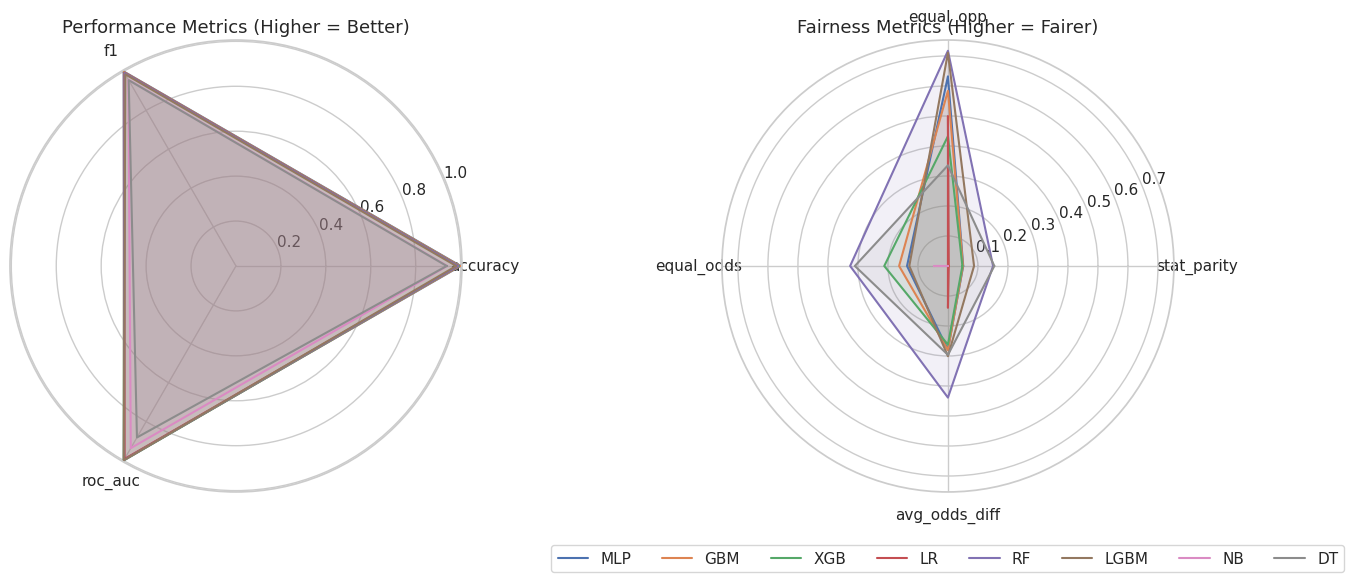

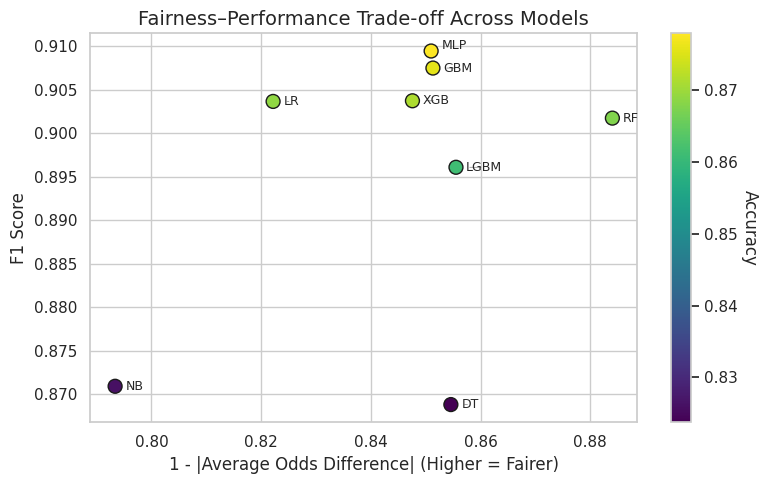

Balanced Best Model: RF
Model parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 57, 'verbose': 0, 'warm_start': False}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler 

epoch 0; iter: 0; batch classifier loss: 0.614679; batch adversarial loss: 0.801219
epoch 1; iter: 0; batch classifier loss: 0.455265; batch adversarial loss: 0.732670
epoch 2; iter: 0; batch classifier loss: 0.412335; batch adversarial loss: 0.670891
epoch 3; iter: 0; batch classifier loss: 0.330680; batch adversarial loss: 0.595785
epoch 4; iter: 0; batch classifier loss: 0.385999; batch adversarial loss: 0.667161
epoch 5; iter: 0; batch classifier loss: 0.430114; batch adversarial loss: 0.623914
epoch 6; iter: 0; batch classifier loss: 0.205122; batch adversarial loss: 0.490016
epoch 7; iter: 0; batch classifier loss: 0.197022; batch adversarial loss: 0.521825
epoch 8; iter: 0; batch classifier loss: 0.256674; batch adversarial loss: 0.578233
epoch 9; iter: 0; batch classifier loss: 0.384783; batch adversarial loss: 0.576751
epoch 0; iter: 0; batch classifier loss: 0.614679; batch adversarial loss: 0.801219
epoch 1; iter: 0; batch classifier loss: 0.455265; batch adversarial loss: 0

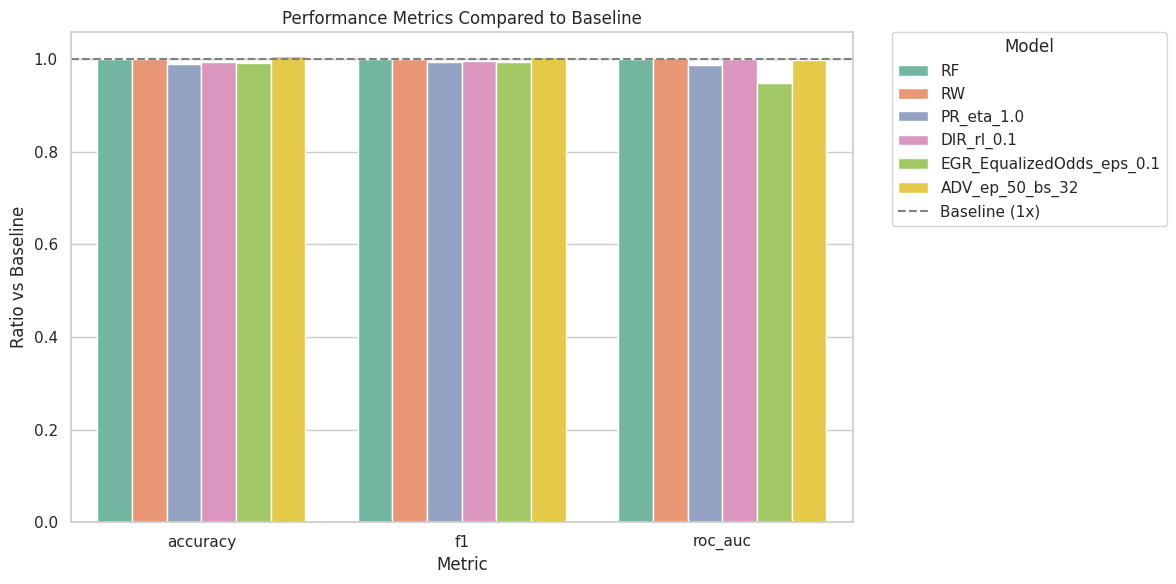

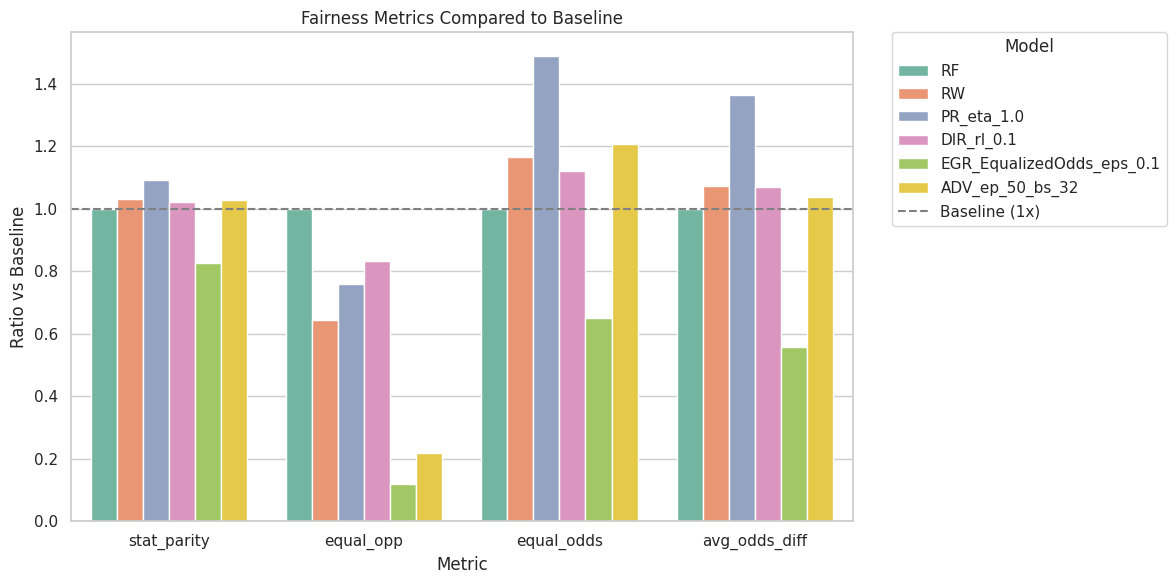

/tmp/ipython-input-2097818403.py:84: RuntimeWarning: invalid value encountered in scalar divide
  n_fav
/tmp/ipython-input-2097818403.py:89: RuntimeWarning: invalid value encountered in scalar divide
  n_unfav
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


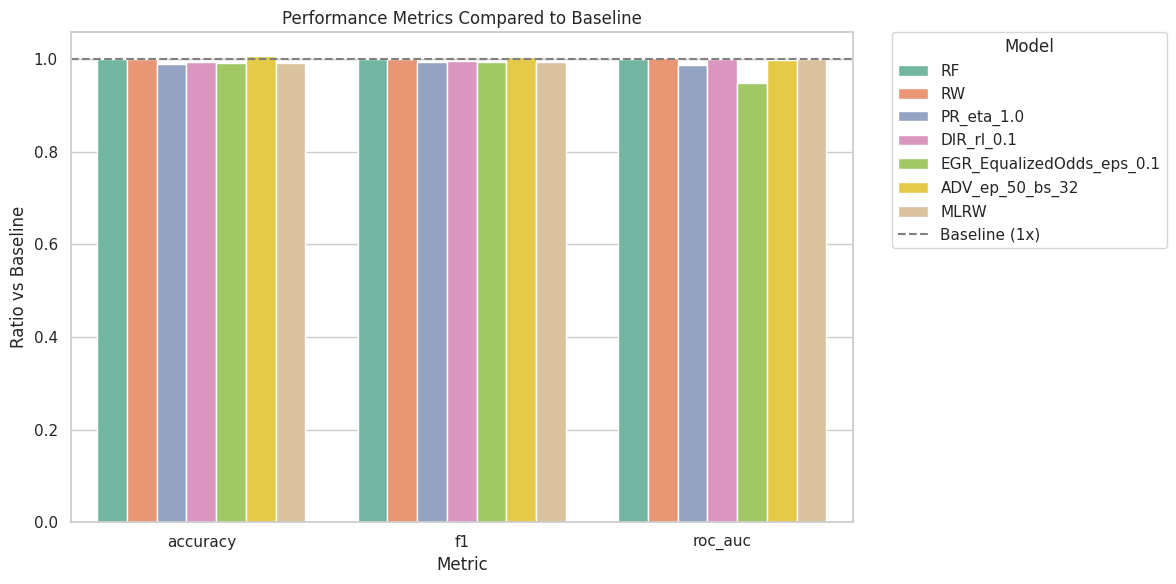

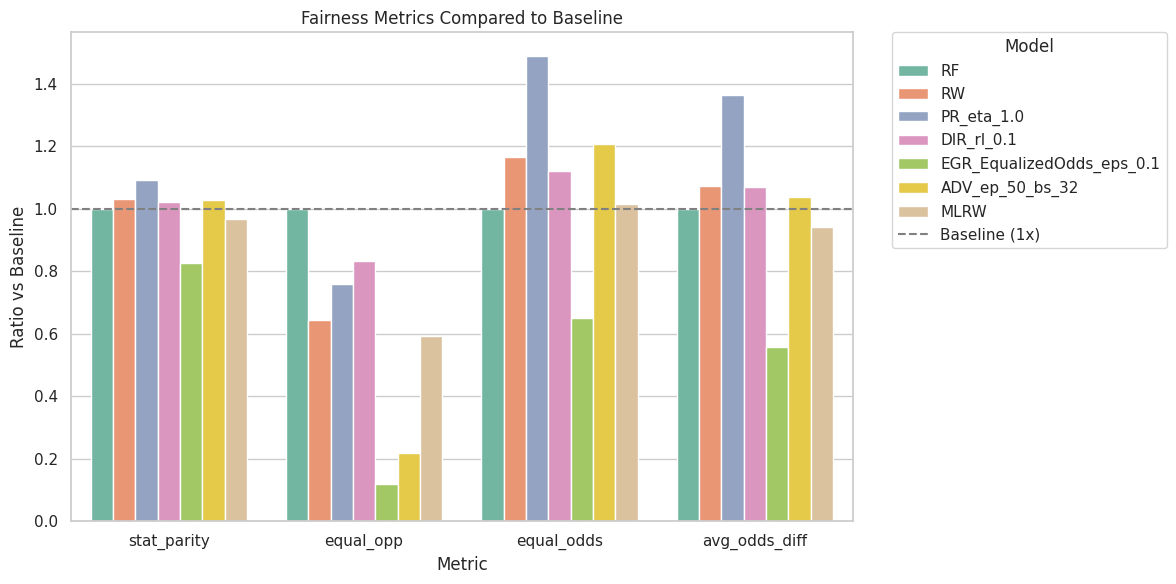

In [ ]:
boundary_results_dict, boundary_result_df = train_evaluate_plot(models, param_grid, X_train_flipped, y_train_flipped, X_test_flipped, y_test_flipped, target, sensitive_feature)

# --- Step 4: Plot Pareto Front ---
pareto_plot(boundary_result_df)

# --- Step 5: Select Best Model by Composite Score ---
best_name_boundary = max(boundary_results_dict, key=lambda x: composite_score(boundary_results_dict[x]))
best_model_boundary = boundary_results_dict[best_name_boundary]['best_model']
print(f"Balanced Best Model: {best_name_boundary}")

# Check if it's a pipeline
if isinstance(best_model_boundary, Pipeline):
    print("Model parameters:")
    print(best_model_boundary.named_steps['clf'].get_params())
else:
    print("Model parameters:")
    print(best_model_boundary.get_params())

# --- Step 6: Run Fairness Mitigation Methods ---
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.Session()
combined_results = run_all_fairness_methods(best_name_boundary, boundary_data, X_train_flipped, y_train_flipped, X_test_flipped, y_test_flipped, target, sensitive_feature, boundary_result_df, boundary_results_dict)

# --- Step 7: Visualise Comparison ---
combined_results.style.apply(highlight_max, subset=['accuracy', 'f1', 'roc_auc']).apply(highlight_min_abs, subset=['stat_parity', 'equal_opp', 'equal_odds', 'avg_odds_diff'])
plot_comparison(combined_results)

# --- Step 8: Apply MultiLevel Reweighing ---
mlrw_results = mlrw(best_name_boundary, boundary_data, X_train_flipped, y_train_flipped, X_test_flipped, y_test_flipped, boundary_results_dict)

# --- Step 9: Visualise Comparison with MRLW ---
combined_final = pd.concat([combined_results, mlrw_results], axis=0)
combined_final.style.apply(highlight_max, subset=['accuracy', 'f1', 'roc_auc']).apply(highlight_min_abs, subset=['stat_parity', 'equal_opp', 'equal_odds', 'avg_odds_diff'])
plot_comparison(combined_final)


In [ ]:
# Export the results DataFrame to a CSV file
combined_final.to_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/Student/Student_Age_Boundary_Priv.csv')

In [ ]:
X_train_flippedUP, X_test_flippedUP, y_train_flippedUP, y_test_flippedUP = train_test_split(X_flipped_UP, y_flipped_UP, test_size=0.2, random_state=random_seed, stratify=y_flipped_UP)

In [ ]:
boundary_data_UP = pd.concat([X_train_flippedUP, y_train_flippedUP], axis=1)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:51:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 2434, number of negative: 1105
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1239
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.687765 -> initscore=0.789691
[LightGBM] [Info] Start training from score 0.789691


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

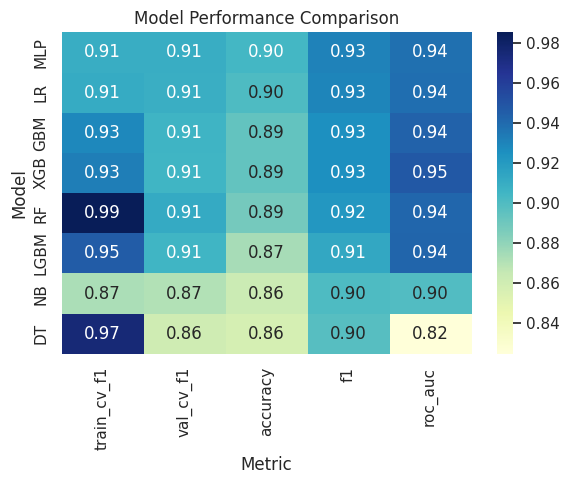

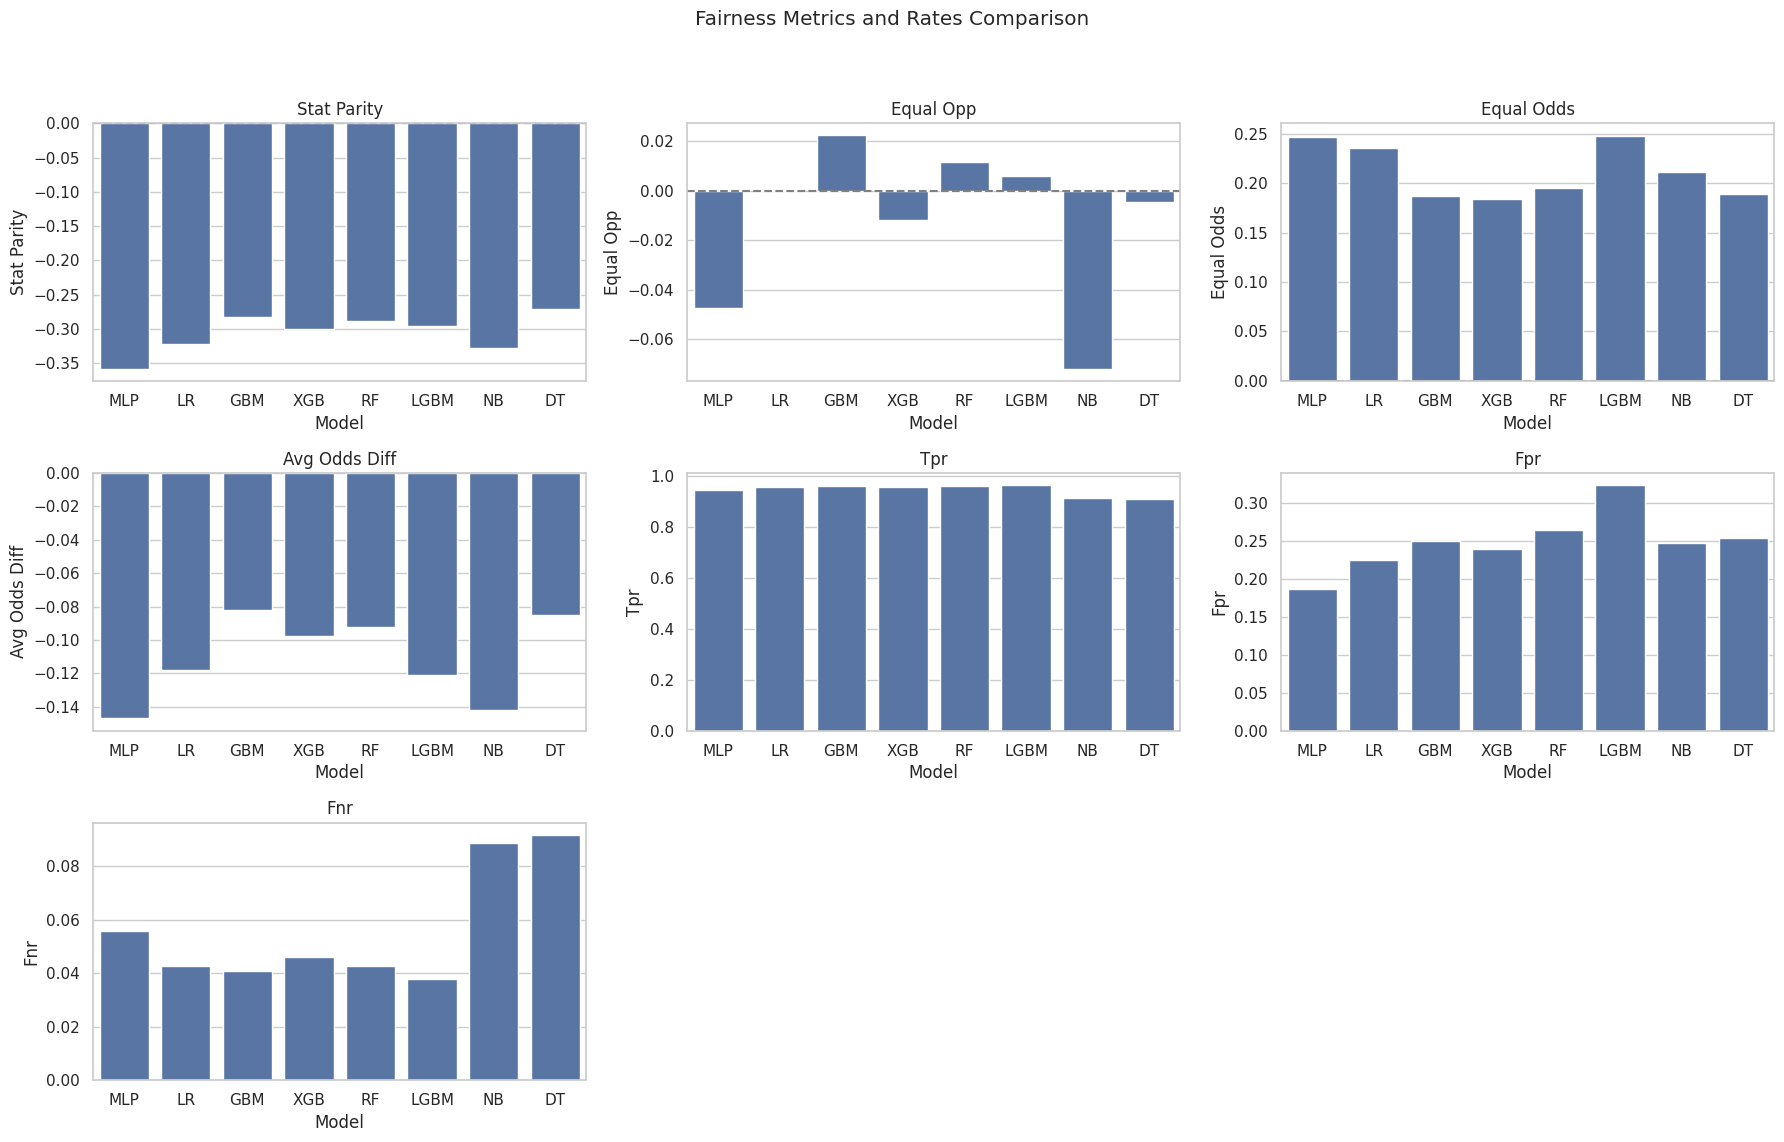

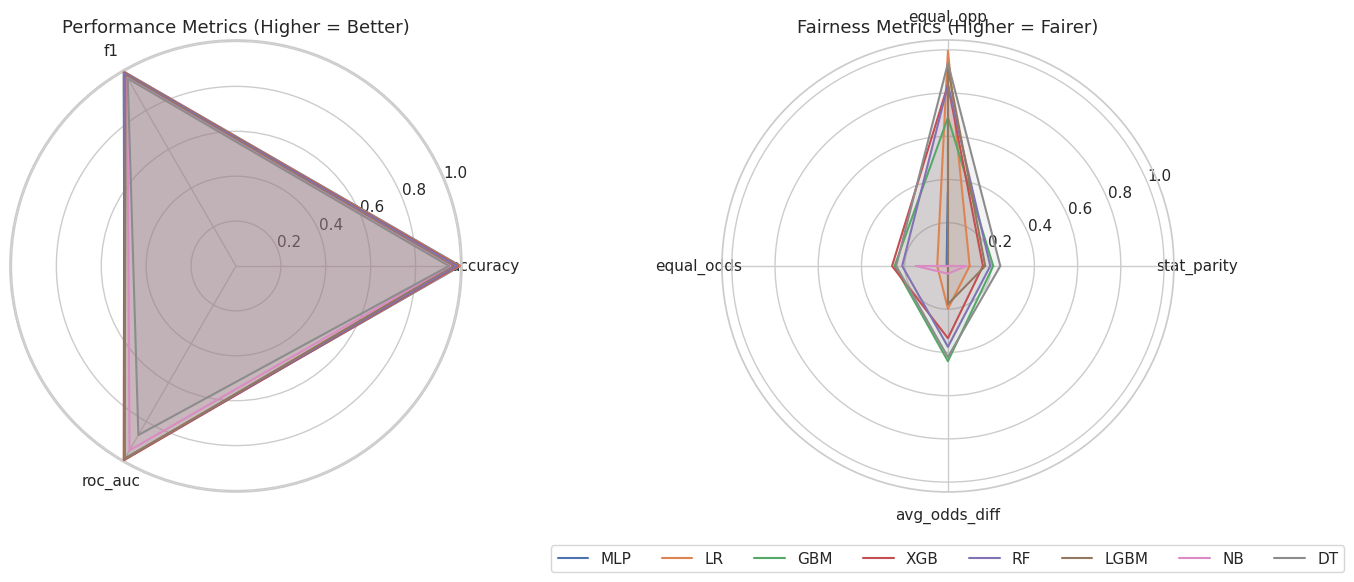

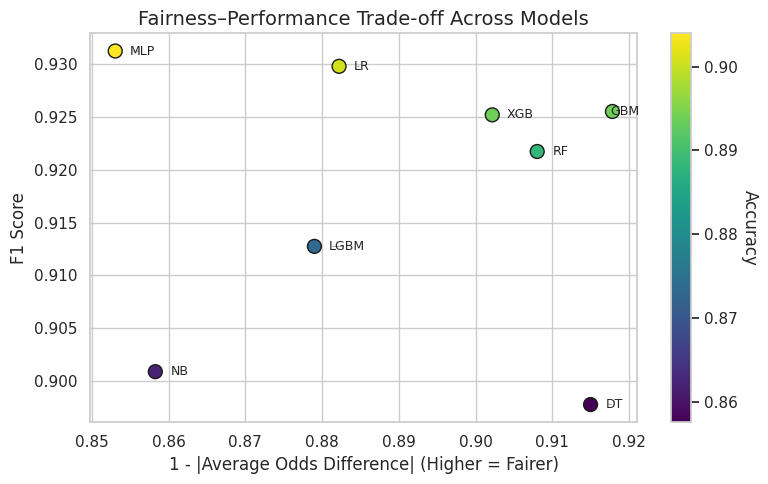

Balanced Best Model: GBM
Model parameters:
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_iter_no_change': None, 'random_state': 57, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler 

epoch 0; iter: 0; batch classifier loss: 0.649572; batch adversarial loss: 0.731002
epoch 1; iter: 0; batch classifier loss: 0.351389; batch adversarial loss: 0.740704
epoch 2; iter: 0; batch classifier loss: 0.271212; batch adversarial loss: 0.659789
epoch 3; iter: 0; batch classifier loss: 0.381697; batch adversarial loss: 0.603649
epoch 4; iter: 0; batch classifier loss: 0.375840; batch adversarial loss: 0.526386
epoch 5; iter: 0; batch classifier loss: 0.260949; batch adversarial loss: 0.524910
epoch 6; iter: 0; batch classifier loss: 0.419947; batch adversarial loss: 0.636431
epoch 7; iter: 0; batch classifier loss: 0.412284; batch adversarial loss: 0.689528
epoch 8; iter: 0; batch classifier loss: 0.343305; batch adversarial loss: 0.505781
epoch 9; iter: 0; batch classifier loss: 0.388794; batch adversarial loss: 0.659346
epoch 0; iter: 0; batch classifier loss: 0.649572; batch adversarial loss: 0.731002
epoch 1; iter: 0; batch classifier loss: 0.351389; batch adversarial loss: 0

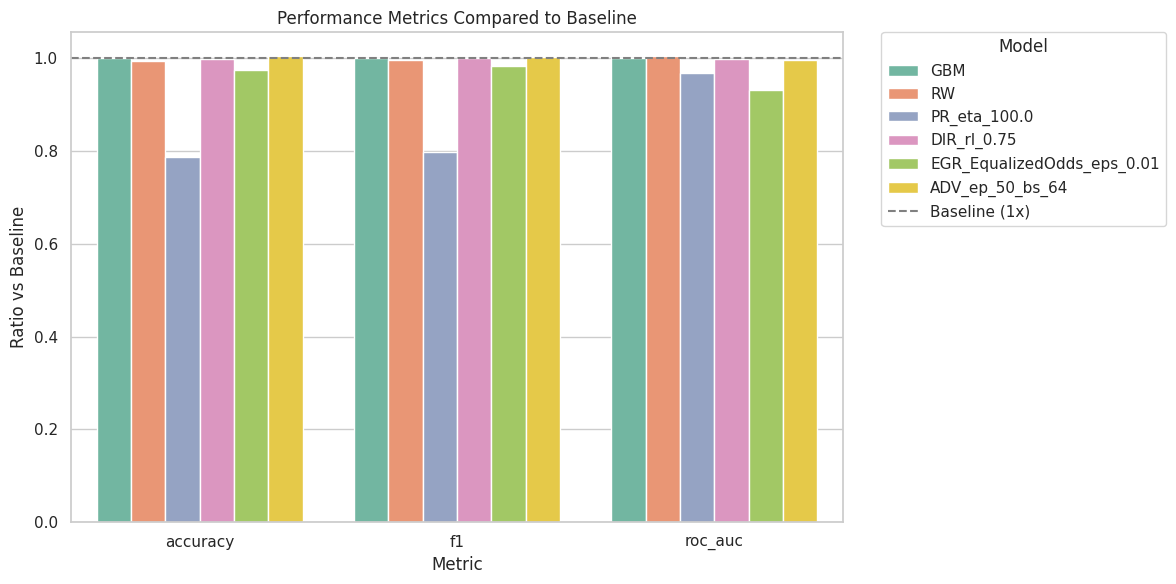

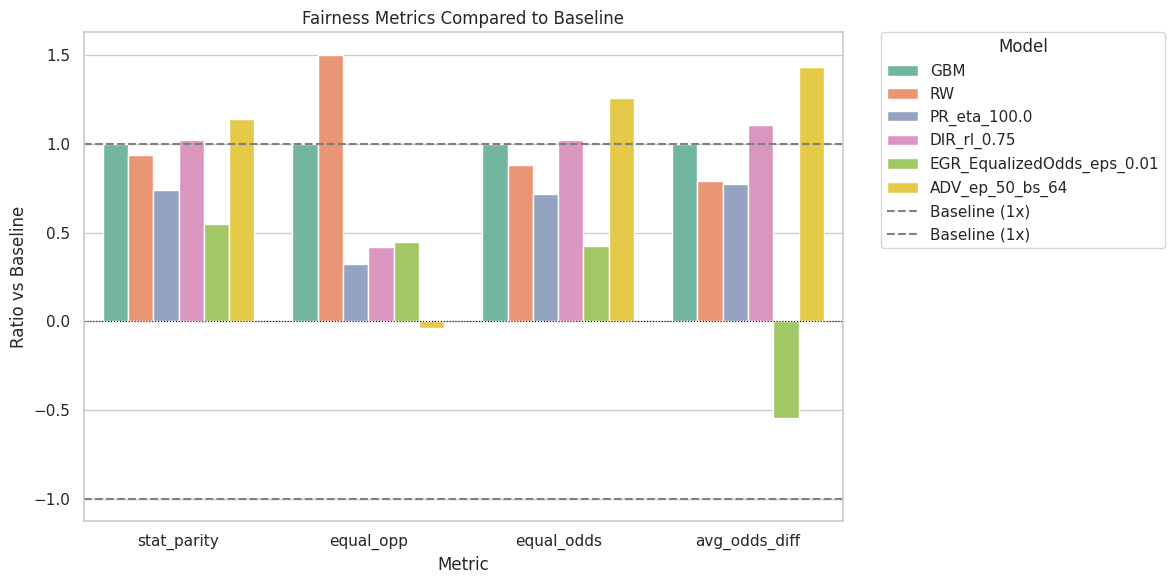

/tmp/ipython-input-2097818403.py:84: RuntimeWarning: invalid value encountered in scalar divide
  n_fav
/tmp/ipython-input-2097818403.py:89: RuntimeWarning: invalid value encountered in scalar divide
  n_unfav
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


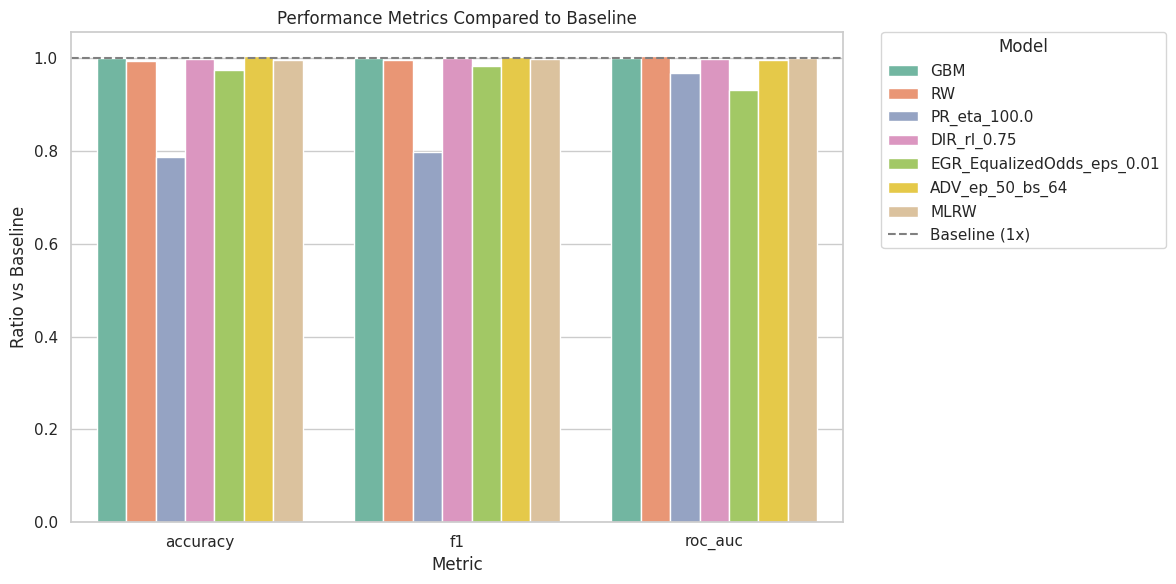

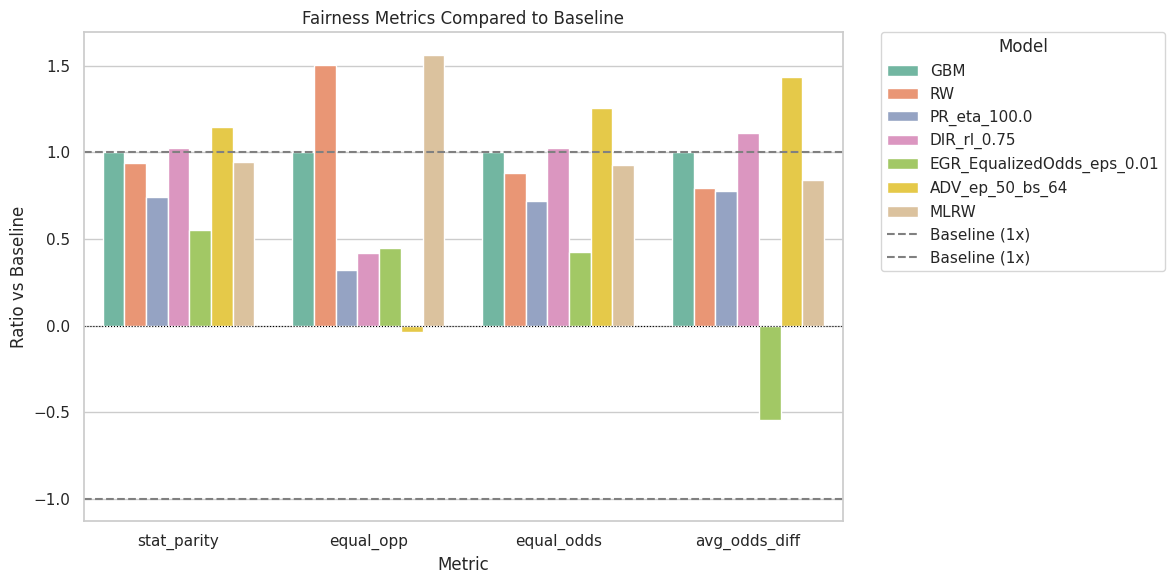

In [ ]:
boundaryUP_results_dict, boundaryUP_result_df = train_evaluate_plot(models, param_grid, X_train_flippedUP, y_train_flippedUP, X_test_flippedUP, y_test_flippedUP, target, sensitive_feature)

# --- Step 4: Plot Pareto Front ---
pareto_plot(boundaryUP_result_df)

# --- Step 5: Select Best Model by Composite Score ---
best_name_boundary = max(boundaryUP_results_dict, key=lambda x: composite_score(boundaryUP_results_dict[x]))
best_model_boundary = boundaryUP_results_dict[best_name_boundary]['best_model']
print(f"Balanced Best Model: {best_name_boundary}")

# Check if it's a pipeline
if isinstance(best_model_boundary, Pipeline):
    print("Model parameters:")
    print(best_model_boundary.named_steps['clf'].get_params())
else:
    print("Model parameters:")
    print(best_model_boundary.get_params())

# --- Step 6: Run Fairness Mitigation Methods ---
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.Session()
combined_results = run_all_fairness_methods(best_name_boundary, boundary_data_UP, X_train_flippedUP, y_train_flippedUP, X_test_flippedUP, y_test_flippedUP, target, sensitive_feature, boundaryUP_result_df, boundaryUP_results_dict)

# --- Step 7: Visualise Comparison ---
combined_results.style.apply(highlight_max, subset=['accuracy', 'f1', 'roc_auc']).apply(highlight_min_abs, subset=['stat_parity', 'equal_opp', 'equal_odds', 'avg_odds_diff'])
plot_comparison(combined_results)

# --- Step 8: Apply MultiLevel Reweighing ---
mlrw_results = mlrw(best_name_boundary, boundary_data_UP, X_train_flippedUP, y_train_flippedUP, X_test_flippedUP, y_test_flippedUP, boundaryUP_results_dict)

# --- Step 9: Visualise Comparison with MRLW ---
combined_final = pd.concat([combined_results, mlrw_results], axis=0)
combined_final.style.apply(highlight_max, subset=['accuracy', 'f1', 'roc_auc']).apply(highlight_min_abs, subset=['stat_parity', 'equal_opp', 'equal_odds', 'avg_odds_diff'])
plot_comparison(combined_final)


In [ ]:
# Export the results DataFrame to a CSV file
combined_final.to_csv('/content/drive/MyDrive/UCL_MSc_AI/UCLFinalProj/FinalProj_Main/Results/Student/Student_Age_Boundary_UnderPriv.csv')

#### Final Runs for all biased_df (fixed model)

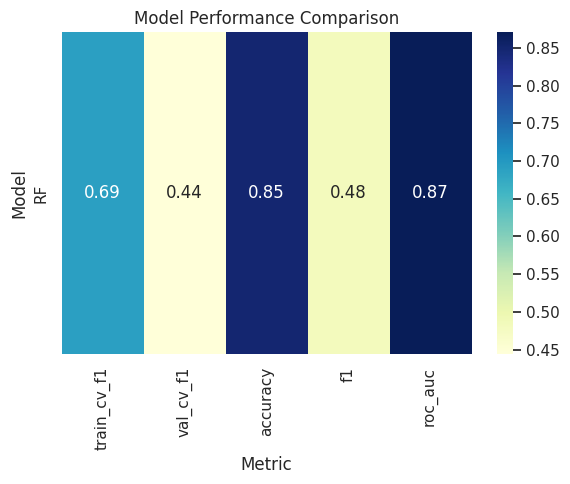

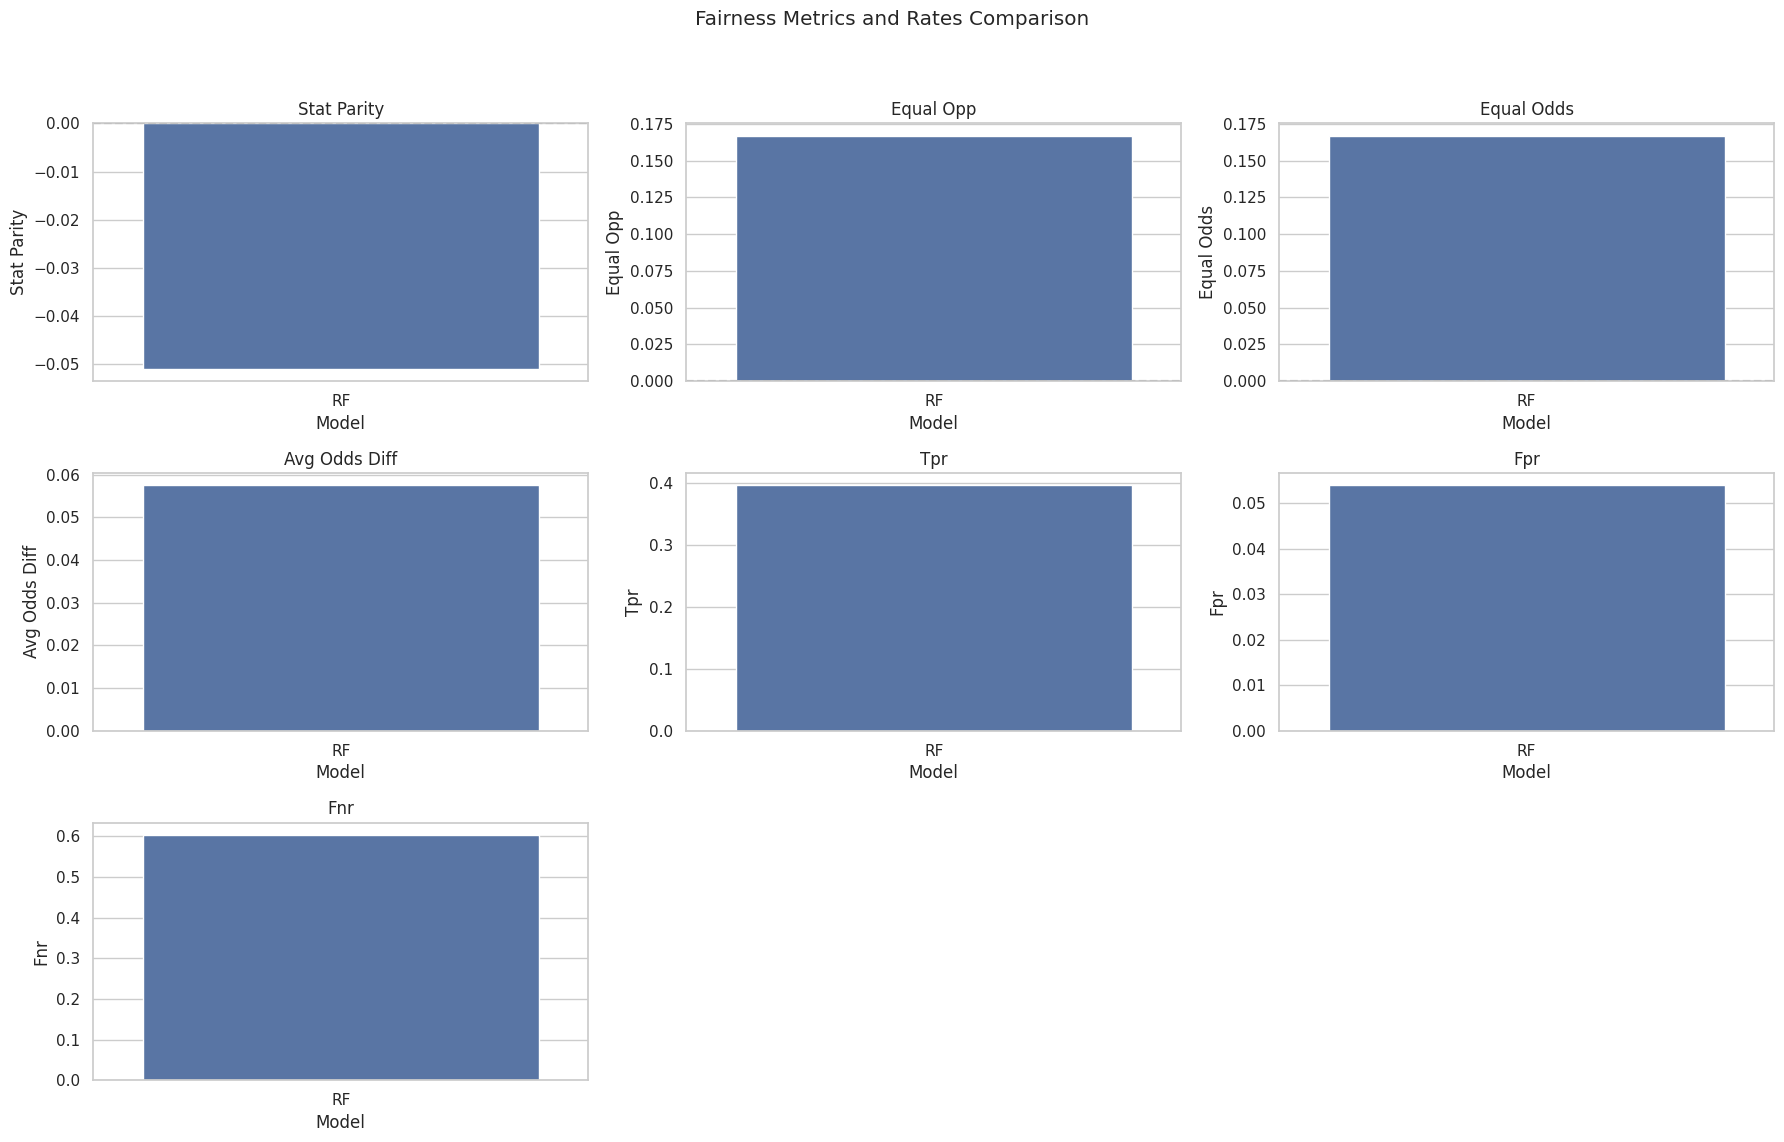

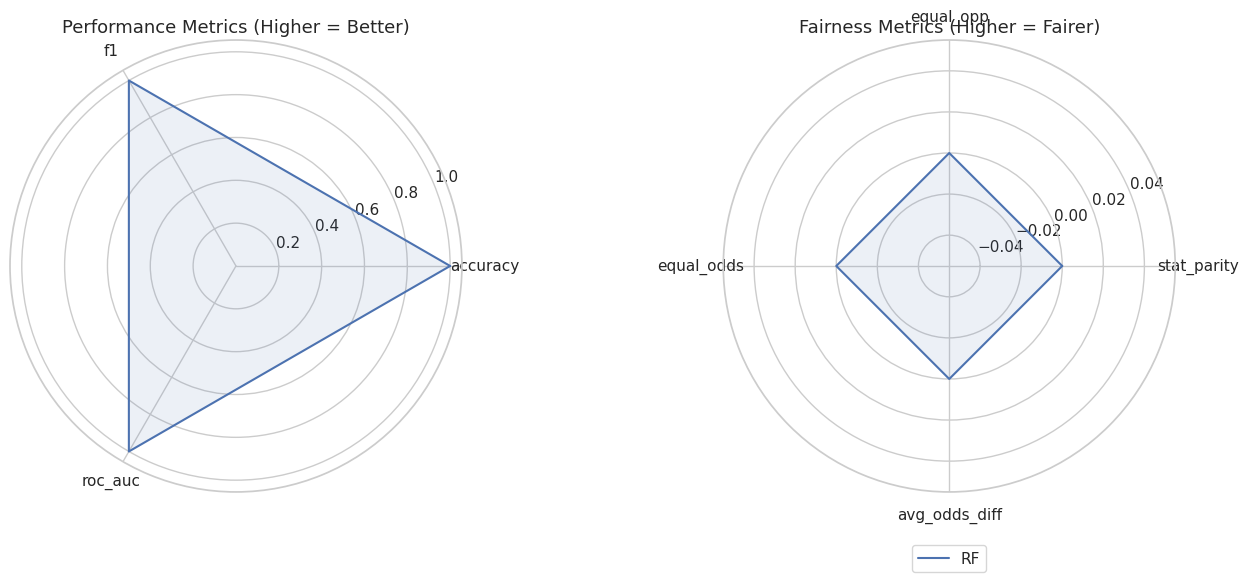

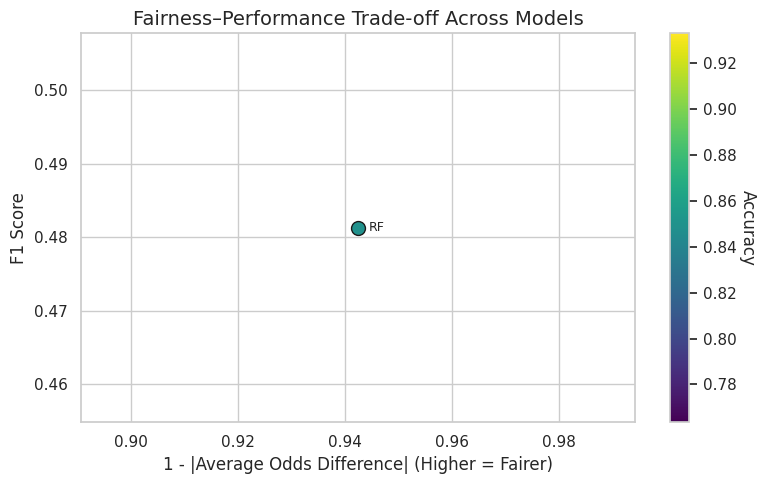

Balanced Best Model: RF
Model parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
epoch 0; iter: 0; batch classifier loss: 0.600666; batch adversarial loss: 0.785037
epoch 0; iter: 200; batch classifier loss: 1.106978; batch adversarial loss: 0.983481
epoch 1; iter: 0; batch classifier loss: 1.206052; batch adversarial loss: 0.883285
epoch 1; iter: 200; batch classifier loss: 1.094018; batch adversarial loss: 0.721722
epoch 2; iter: 0; batch classifier loss: 0.849460; batch adversarial loss: 0.663978
epoch 2; iter: 200; batch classifier loss: 0.427196; batch adversarial loss: 0.648298
epoch 3; iter: 0; batch classifier

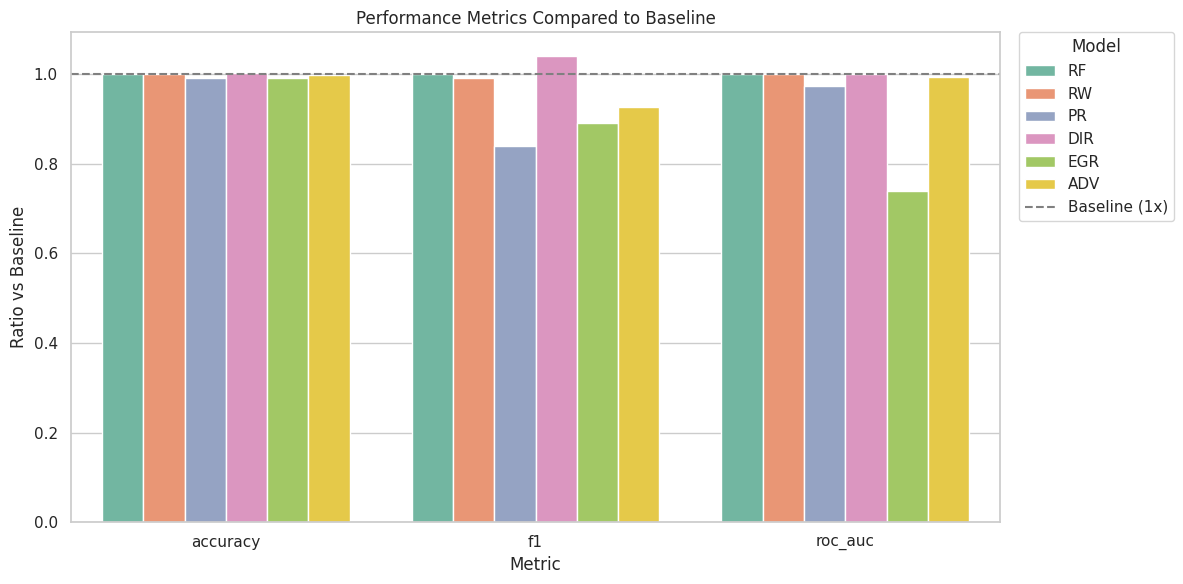

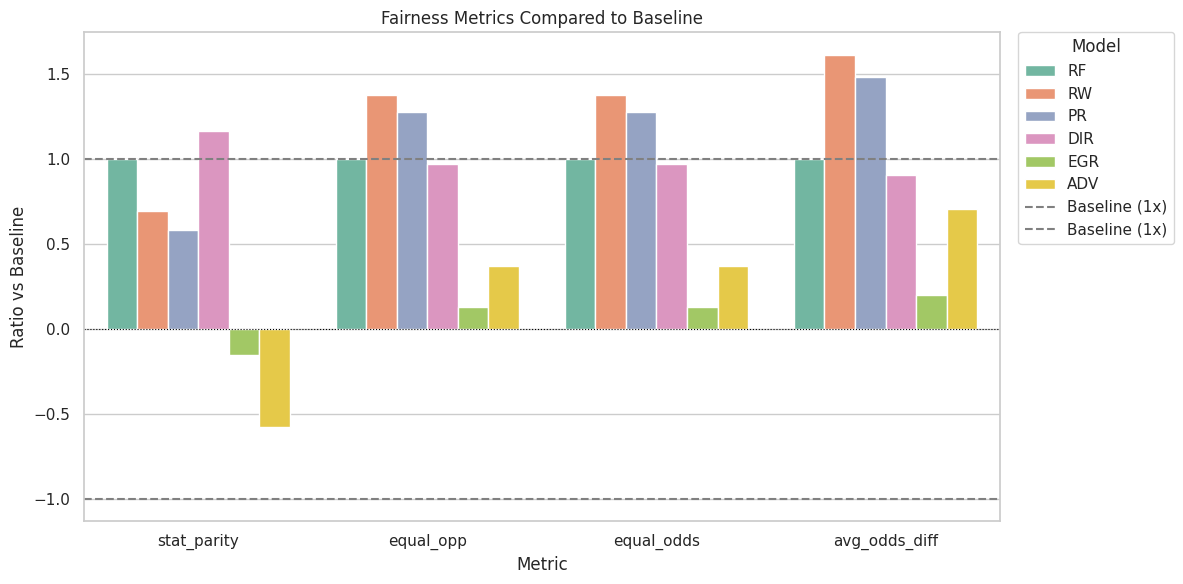

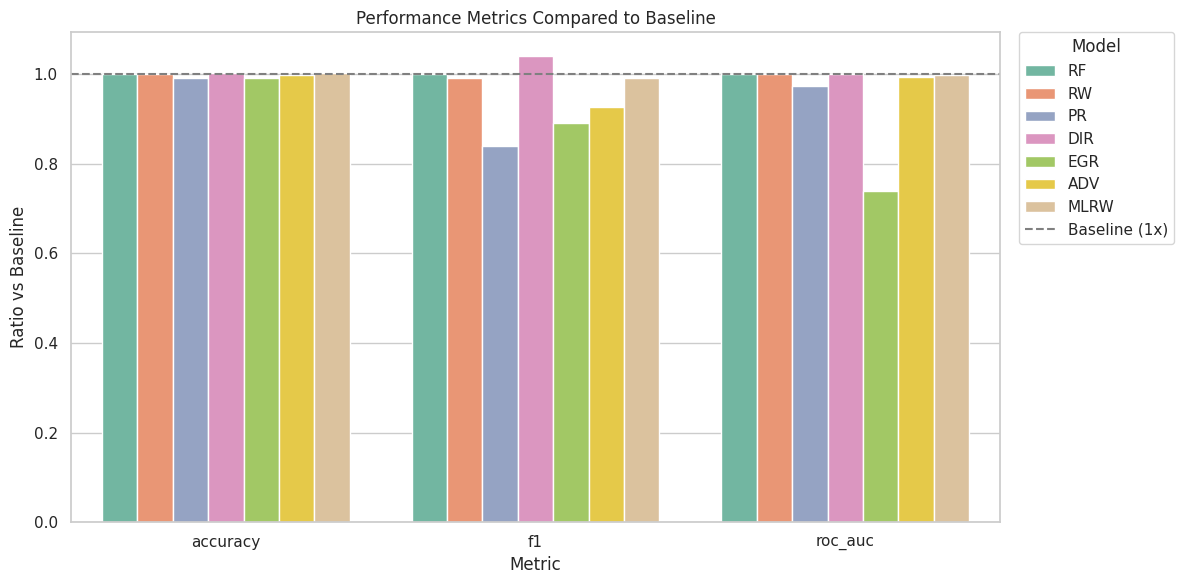

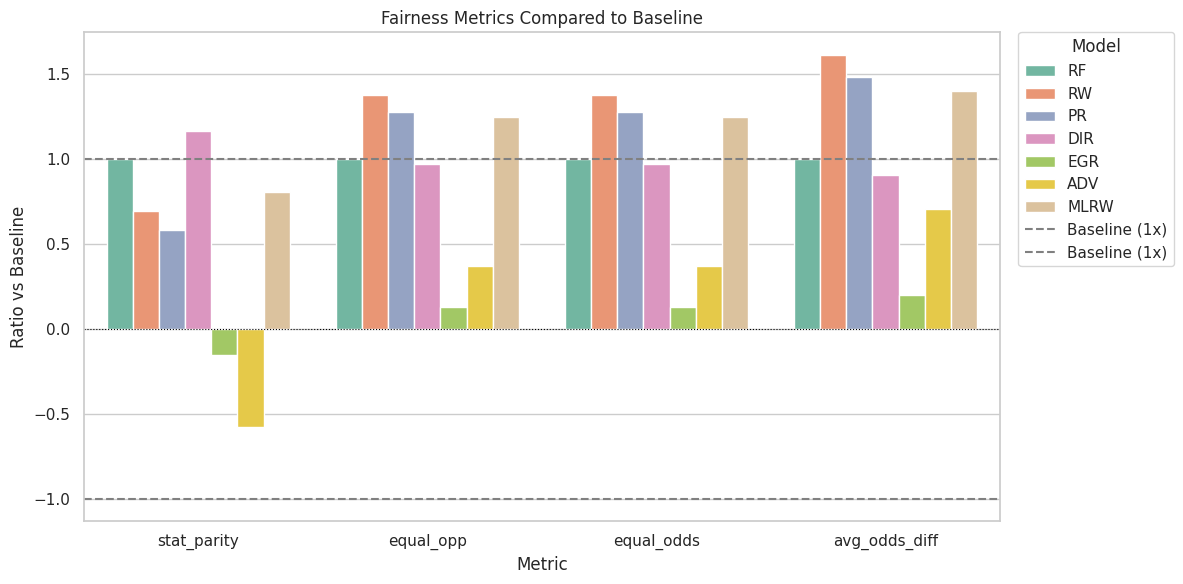

In [ ]:
combined_results2_df_flip, combined_results2_df_flip_mrlw = run_fair_ml_pipeline_fixedmodel(
    data=biased_df_flip,
    target=target,
    sensitive_feature=sensitive_feature,
    param_grid=param_grid
)

In [ ]:
combined_results2_df_flip_2, combined_results2_df_flip_2_mrlw = run_fair_ml_pipeline_fixedmodel(
    data=biased_df_flip_2,
    target=target,
    sensitive_feature=sensitive_feature,
    param_grid=param_grid
)

In [ ]:
combined_results2_df_flip_3, combined_results2_df_flip_3_mrlw = run_fair_ml_pipeline_fixedmodel(
    data=biased_df_flip_3,
    target=target,
    sensitive_feature=sensitive_feature,
    param_grid=param_grid
)

In [ ]:
combined_results2_df_flip_4, combined_results2_df_flip_4_mrlw = run_fair_ml_pipeline_fixedmodel(
    data=biased_df_flip_4,
    target=target,
    sensitive_feature=sensitive_feature,
    param_grid=param_grid
)

In [ ]:
combined_results2_genalgo, combined_results2_genalgo_mrlw = run_fair_ml_pipeline_fixedmodel(
    data=df_unfair,
    target=target,
    sensitive_feature=sensitive_feature,
    param_grid=param_grid
)

##  PART 2: SENSITIVE FEATURE IDENTIFICATION

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=random_seed)
rf.fit(X_train, y_train)
perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=random_seed)

importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': perm.importances_mean})
importance_df = importance_df.sort_values('importance', ascending=False)

sensitive_feature = importance_df.iloc[0]['feature']  # Most sensitive feature
print(f"Most sensitive feature: {sensitive_feature}")

Most sensitive feature: Curricular units 2nd sem (approved)


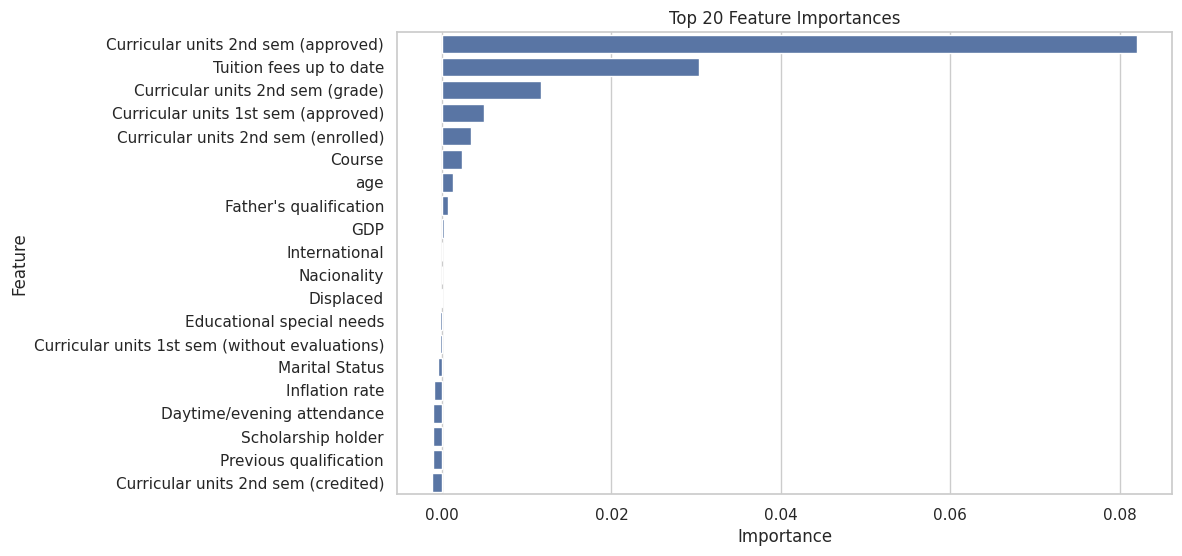

In [ ]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

###Fair Feature importance

Added a compute_fair_feature_importance function (inspired by FairSHAP). It uses permutation-based perturbation to estimate how each feature contributes to fairness metrics (like statistical parity or equal opportunity).

In [ ]:
def compute_fair_feature_importance(model, X_test, y_test, sensitive_feature, target, fairness_metric='stat_parity'):
    base_pred = model.predict(X_test)
    base_pred = np.array(base_pred).astype(int)
    val_df = X_test.copy()
    val_df[target] = y_test.astype(int)
    base_pred_df = X_test.copy()
    base_pred_df[target] = base_pred.astype(int)

    base_true = BinaryLabelDataset(df=val_df, label_names=[target], protected_attribute_names=[sensitive_feature])
    base_pred_ds = BinaryLabelDataset(df=base_pred_df, label_names=[target], protected_attribute_names=[sensitive_feature])
    base_metric = ClassificationMetric(base_true, base_pred_ds,
        privileged_groups=[{sensitive_feature: 1}], unprivileged_groups=[{sensitive_feature: 0}])

    base_score = {
        'stat_parity': base_metric.statistical_parity_difference(),
        'equal_opp': base_metric.equal_opportunity_difference(),
        'equal_odds': base_metric.equalized_odds_difference()
    }[fairness_metric]

    feature_importance = []
    for feature in X_test.columns:
        X_temp = X_test.copy()
        X_temp[feature] = np.random.permutation(X_temp[feature].values)

        y_pred_temp = model.predict(X_temp)
        y_pred_temp = np.array(y_pred_temp).astype(int)
        temp_df = X_test.copy()
        temp_df[target] = y_pred_temp

        temp_pred_ds = BinaryLabelDataset(df=temp_df, label_names=[target], protected_attribute_names=[sensitive_feature])
        temp_metric = ClassificationMetric(base_true, temp_pred_ds,
            privileged_groups=[{sensitive_feature: 1}], unprivileged_groups=[{sensitive_feature: 0}])

        temp_score = {
            'stat_parity': temp_metric.statistical_parity_difference(),
            'equal_opp': temp_metric.equal_opportunity_difference(),
            'equal_odds': temp_metric.equalized_odds_difference()
        }[fairness_metric]

        importance_score = abs(temp_score - base_score)
        feature_importance.append({
            'feature': feature,
            'fairness_importance': importance_score
        })

        print(f"{feature}: base_score={base_score:.4f}, temp_score={temp_score:.4f}")

    # Return sorted DataFrame
    importance_df = pd.DataFrame(feature_importance).sort_values(by='fairness_importance', ascending=False).reset_index(drop=True)

    return importance_df

In [ ]:
fair_importance = compute_fair_feature_importance(rf, X_test, y_test, sensitive_feature, target)
print(fair_importance.head())

/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/loc

age: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


fnlwgt: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


education-num: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


race: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


sex: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


capital-gain: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


capital-loss: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


hours-per-week: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


workclass_ Local-gov: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


workclass_ Private: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


workclass_ Self-emp-inc: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


workclass_ Self-emp-not-inc: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


workclass_ State-gov: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


workclass_ Without-pay: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


education_ 11th: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


education_ 12th: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


education_ 1st-4th: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


education_ 5th-6th: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


education_ 7th-8th: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


education_ 9th: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


education_ Assoc-acdm: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


education_ Assoc-voc: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


education_ Bachelors: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


education_ Doctorate: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


education_ HS-grad: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


education_ Masters: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


education_ Preschool: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


education_ Prof-school: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


education_ Some-college: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


marital-status_ Married-AF-spouse: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


marital-status_ Married-civ-spouse: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


marital-status_ Married-spouse-absent: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


marital-status_ Never-married: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


marital-status_ Separated: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


marital-status_ Widowed: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


occupation_ Armed-Forces: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


occupation_ Craft-repair: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


occupation_ Exec-managerial: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


occupation_ Farming-fishing: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


occupation_ Handlers-cleaners: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


occupation_ Machine-op-inspct: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


occupation_ Other-service: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


occupation_ Priv-house-serv: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


occupation_ Prof-specialty: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


occupation_ Protective-serv: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


occupation_ Sales: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


occupation_ Tech-support: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


occupation_ Transport-moving: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


relationship_ Not-in-family: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


relationship_ Other-relative: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


relationship_ Own-child: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


relationship_ Unmarried: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


relationship_ Wife: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Canada: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ China: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Columbia: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Cuba: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Dominican-Republic: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Ecuador: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ El-Salvador: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ England: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ France: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Germany: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Greece: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Guatemala: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Haiti: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Holand-Netherlands: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Honduras: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Hong: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Hungary: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ India: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Iran: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Ireland: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Italy: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Jamaica: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Japan: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Laos: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Mexico: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Nicaragua: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Outlying-US(Guam-USVI-etc): base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Peru: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Philippines: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Poland: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Portugal: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Puerto-Rico: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Scotland: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ South: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Taiwan: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Thailand: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Trinadad&Tobago: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ United-States: base_score=nan, temp_score=nan


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


native-country_ Vietnam: base_score=nan, temp_score=nan
native-country_ Yugoslavia: base_score=nan, temp_score=nan
         feature  fairness_importance
0            age                  NaN
1         fnlwgt                  NaN
2  education-num                  NaN
3           race                  NaN
4            sex                  NaN


/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,


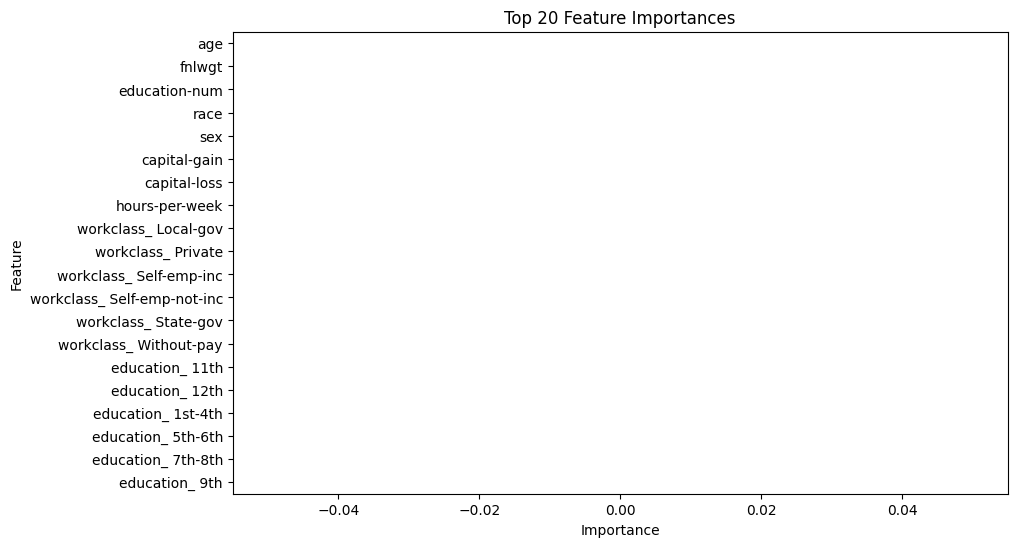

In [ ]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='fairness_importance', y='feature', data=fair_importance.head(20))
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## FairFIS

In [ ]:
!git clone https://github.com/DebolinaHalder/FairTreeFIS.git
!cd FairTreeFIS
!python3 setup.py install

fatal: destination path 'FairTreeFIS' already exists and is not an empty directory.
python3: can't open file '//setup.py': [Errno 2] No such file or directory


In [ ]:
!git clone https://github.com/DebolinaHalder/FairTreeFIS.git #Clone the repo
%cd FairTreeFIS #Navigate into directory.
!pip install . #Install the package to your environment
%cd ..

fatal: destination path 'FairTreeFIS' already exists and is not an empty directory.
[Errno 2] No such file or directory: 'FairTreeFIS #Navigate into directory.'
/content
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.
/


In [ ]:
from fairTreeFIS import FairTreeFIS

ModuleNotFoundError: No module named 'fairTreeFIS'

In [ ]:
sensitive_index = list(X.columns).index('sex') if isinstance(X, pd.DataFrame) else 9

fair_fis = FairTreeFIS(model=clf, X=X_test, y=y_test, sensitive_feature_index=sensitive_index)

fairfis_scores = fair_fis.compute_fair_fis()

In [ ]:
# Convert scores to sorted list
scores_sorted = sorted(fairfis_scores.items(), key=lambda x: abs(x[1]), reverse=True)

for feature_idx, score in scores_sorted:
    print(f"Feature {feature_idx}: FairFIS Score = {score:.4f}")

In [ ]:
def compute_fairfis_scores(model, X_test_array, y_test_array, sensitive_feature_index):
    fair_fis = FairTreeFIS(
        model=model,
        X=X_test_array,
        y=y_test_array,
        sensitive_feature_index=sensitive_feature_index
    )
    return fair_fis.compute_fair_fis()

FairFIS_model = DecisionTreeClassifier(max_depth=5, random_state=42)
FairFIS_model.fit(X_train, y_train)

# Convert to arrays if using DataFrames
X_test_array = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
sensitive_idx = X.columns.get_loc('sex') if 'sex' in X.columns else 0

fairfis_scores = compute_fairfis_scores(FairFIS_model, X_test_array, y_test.values, sensitive_idx)

# Display FairFIS scores sorted
sorted_scores = sorted(fairfis_scores.items(), key=lambda x: abs(x[1]), reverse=True)
for idx, score in sorted_scores:
    feature_name = X.columns[idx] if isinstance(X, pd.DataFrame) else f"Feature {idx}"
    print(f"{feature_name}: FairFIS Score = {score:.4f}")

NameError: name 'FairTreeFIS' is not defined

## Identifying Most Sensitive Features

In [ ]:
protected_candidates = ['sex', 'race']

for attr in protected_candidates:
    # Recover protected attribute from original X
    X_test_tmp = X_test.copy()
    X_test_tmp[attr] = X.loc[X_test.index, attr].values

    # Ensure predictions align with test set index
    y_pred_series = pd.Series(y_pred, index=X_test.index, name='income')

    # Construct true and predicted dataframes
    true_df = pd.concat([X_test_tmp, y_test], axis=1)
    pred_df = pd.concat([X_test_tmp, y_pred_series], axis=1)

    # Create AIF360 datasets
    true_dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=true_df,
        label_names=['income'],
        protected_attribute_names=[attr]
    )

    pred_dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=pred_df,
        label_names=['income'],
        protected_attribute_names=[attr]
    )

    # Fairness metric
    metric = ClassificationMetric(
        true_dataset, pred_dataset,
        unprivileged_groups=[{attr: 0}],
        privileged_groups=[{attr: 1}]
    )

    print(f"Fairness impact of {attr}:")
    print("  Statistical Parity:", round(metric.statistical_parity_difference(), 3))
    print("  Equal Opportunity:", round(metric.equal_opportunity_difference(), 3))
    print("  Disparate Impact:", round(metric.disparate_impact(), 3))
    print("-----")

Fairness impact of sex:
  Statistical Parity: -0.174
  Equal Opportunity: -0.058
  Disparate Impact: 0.331
-----


KeyError: 'race'

### Other Codes

In [ ]:
def apply_mlrw(train_df, label_column, protected_features_with_levels):
    """
    Apply MultiLevel Reweighing to training data.

    Args:
        train_df (pd.DataFrame): Input training DataFrame.
        label_column (str): Target label column name (e.g., 'income').
        protected_features_with_levels (list): List of dicts like:
            [{'feature_name': 'sex', 'privileged_value': 1, 'unprivileged_value': 0, 'level': 1}, ...]

    Returns:
        BinaryLabelDataset: AIF360 dataset with instance weights
    """
    multi_privileged_groups = [
        {'feature_name': d['feature_name'], 'privileged_value': d['privileged_value'], 'level': d['level']}
        for d in protected_features_with_levels
    ]
    multi_unprivileged_groups = [
        {'feature_name': d['feature_name'], 'unprivileged_value': d['unprivileged_value'], 'level': d['level']}
        for d in protected_features_with_levels
    ]

    dataset = BinaryLabelDataset(
        df=train_df.copy(),
        label_names=[label_column],
        protected_attribute_names=[d['feature_name'] for d in protected_features_with_levels]
    )

    mlrw = MultiLevelReweighing(multi_privileged_groups, multi_unprivileged_groups)
    mlrw.fit(dataset)
    dataset_mlrw = mlrw.transform(dataset)

    return dataset_mlrw

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:08:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 6428, number of negative: 33572
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 513
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160700 -> initscore=-1.653029
[LightGBM] [Info] Start training from score -1.653029


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


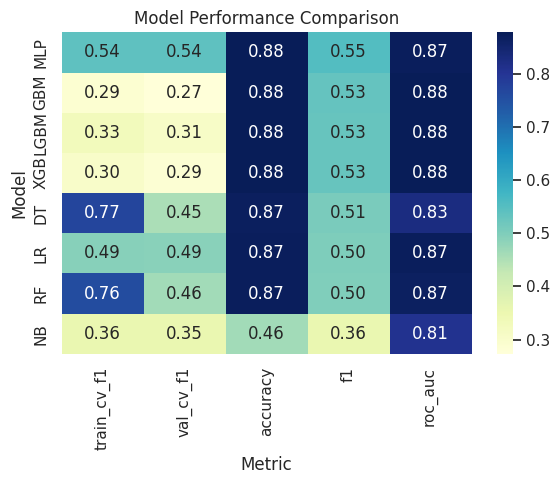

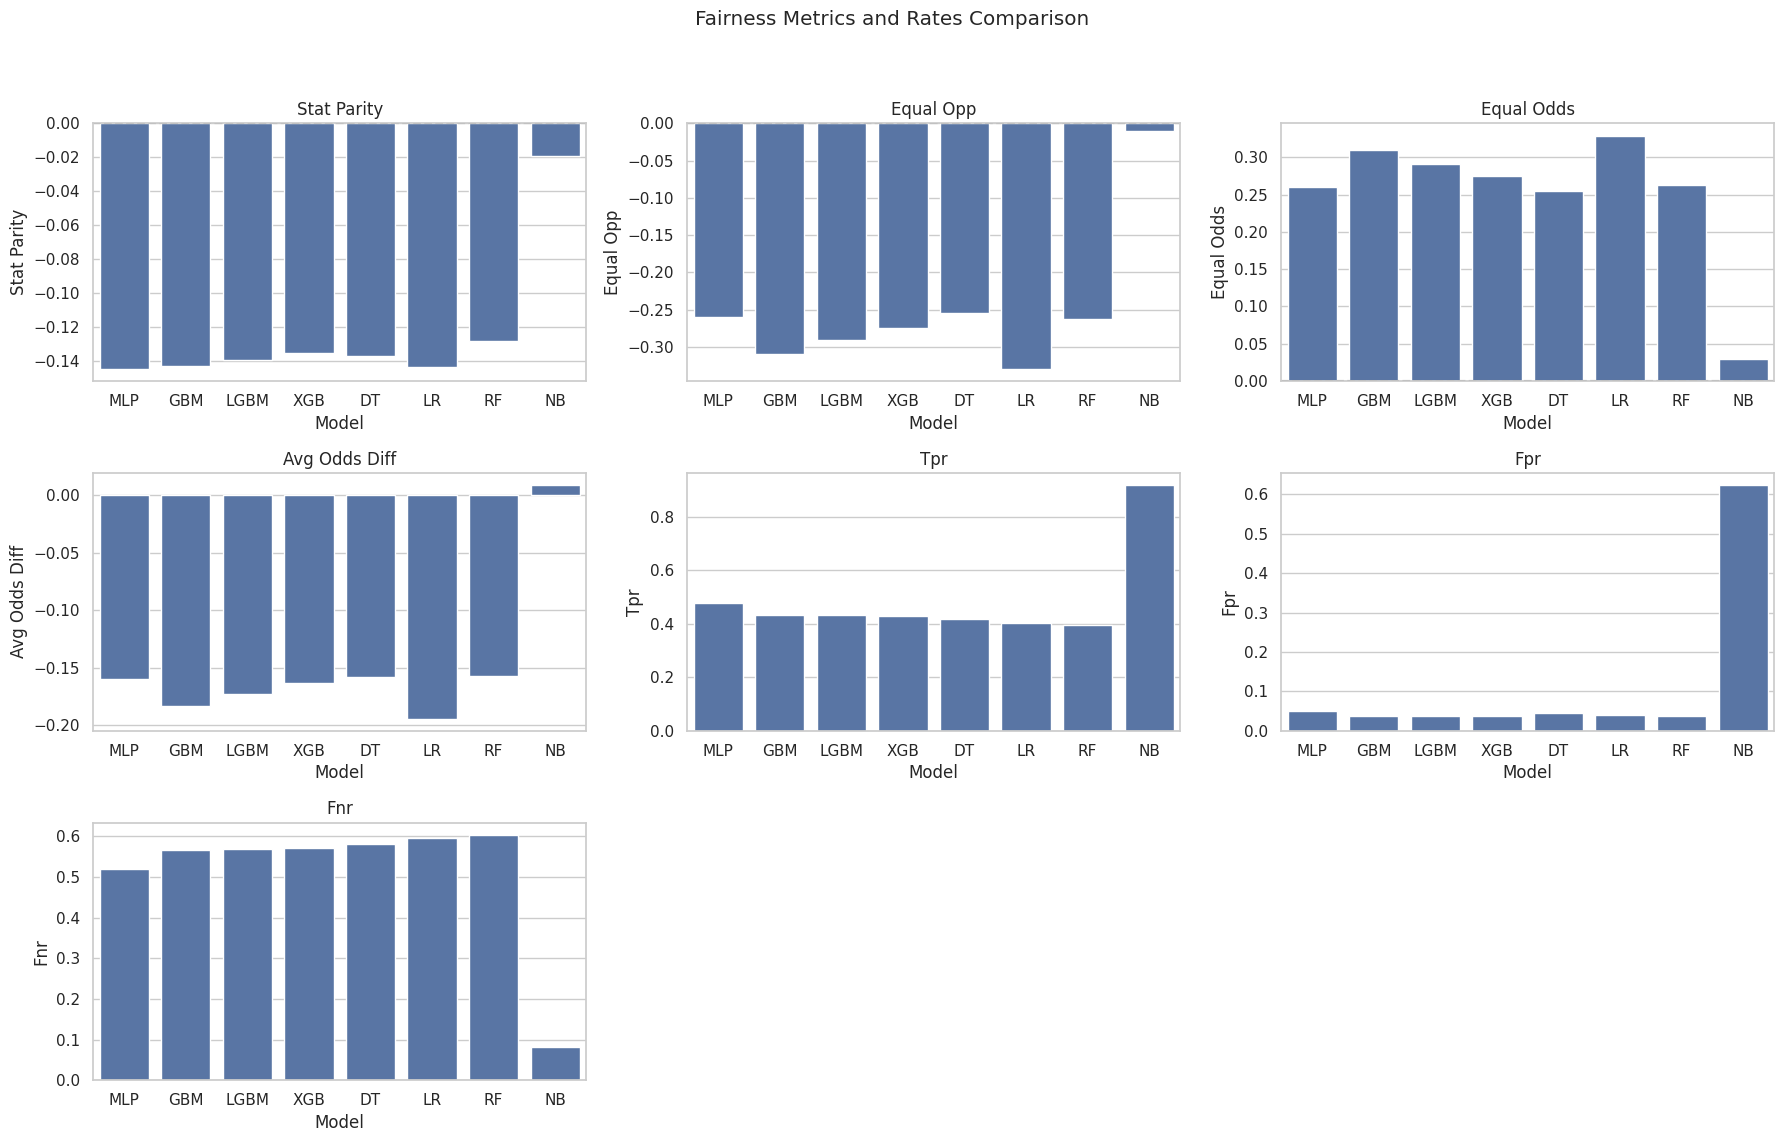

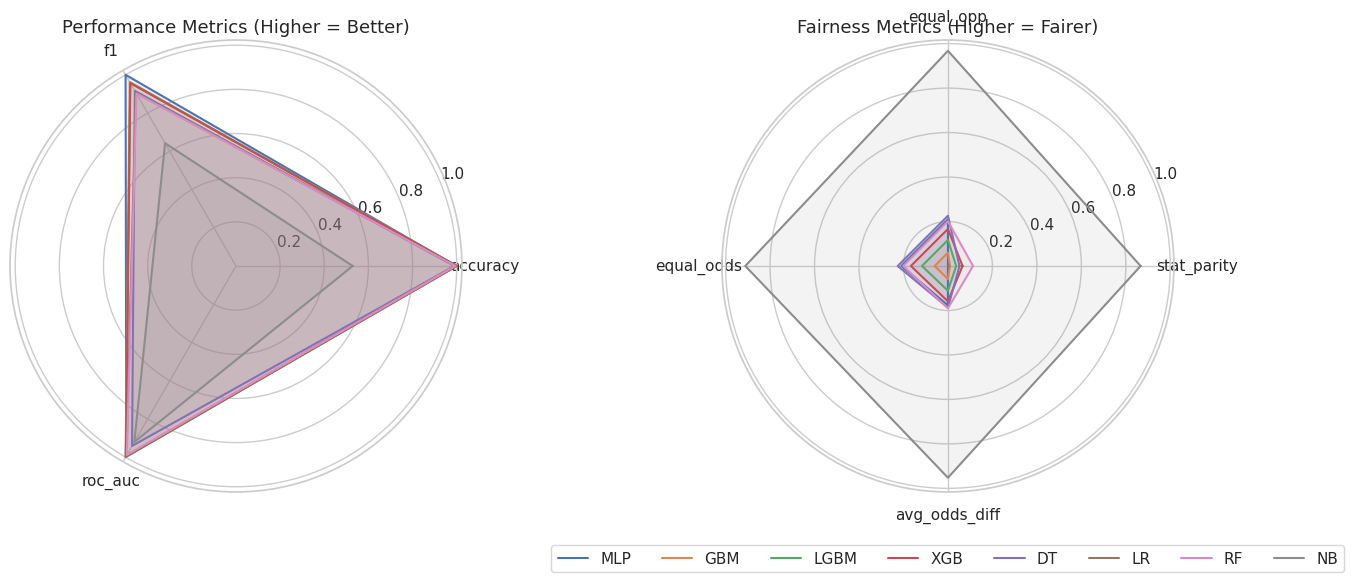

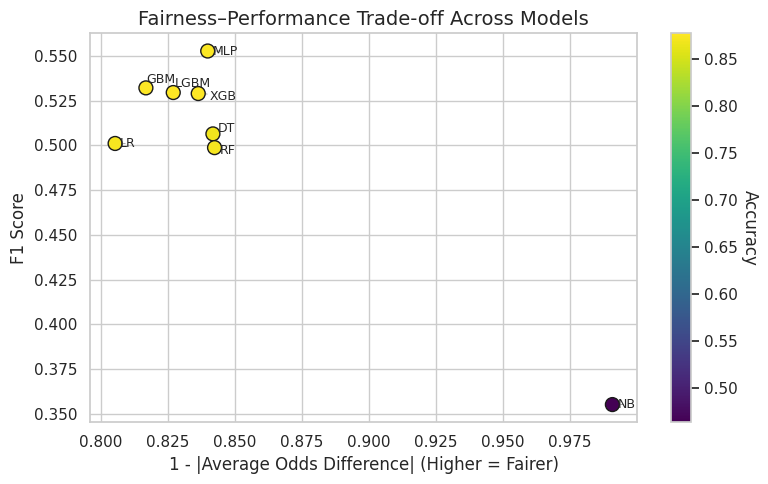

Balanced Best Model: NB
Model parameters: {'priors': None, 'var_smoothing': 1e-07}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/inprocessing/celisMeta/FalseDiscovery.py:31: RuntimeWarning: invalid value encountered in divide
  prob_y_1 = (prob_1_1 + prob_1_0) / total
/usr/local/lib/python3.11/dist-packages/aif360/algorithms/inprocessing/celisMeta/FalseDiscovery.py:32:

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
combined_results_2010 = run_fair_ml_pipeline(
    data=Adult_2010,
    target=target,
    sensitive_feature=sensitive_feature,
    param_grid=param_grid
)

In [ ]:
def compare_datasets(df1, df2, name1="Dataset 1", name2="Dataset 2"):
    """
    Compares two pandas DataFrames and reports differences in columns, data types, and basic value counts.

    Args:
        df1 (pd.DataFrame): The first DataFrame.
        df2 (pd.DataFrame): The second DataFrame.
        name1 (str): Name for the first dataset in reports.
        name2 (str): Name for the second dataset in reports.
    """
    print(f"--- Comparing {name1} and {name2} ---")

    # 1. Column Comparison
    cols1 = set(df1.columns)
    cols2 = set(df2.columns)

    if cols1 == cols2:
        print("Columns are identical.")
    else:
        print("Column differences found:")
        if cols1 - cols2:
            print(f"  Columns in {name1} but not in {name2}: {cols1 - cols2}")
        if cols2 - cols1:
            print(f"  Columns in {name2} but not in {name1}: {cols2 - cols1}")

    # Find common columns for further comparison
    common_cols = list(cols1.intersection(cols2))

    # 2. Data Type Comparison (for common columns)
    print("\n--- Data Type Comparison (Common Columns) ---")
    dtype_diffs = {}
    for col in common_cols:
        if df1[col].dtype != df2[col].dtype:
            dtype_diffs[col] = (df1[col].dtype, df2[col].dtype)

    if dtype_diffs:
        print("Data type differences found:")
        for col, dtypes in dtype_diffs.items():
            print(f"  Column '{col}': {name1} is {dtypes[0]}, {name2} is {dtypes[1]}")
    else:
        print("Data types are consistent for common columns.")

    # 3. Shape Comparison
    print("\n--- Shape Comparison ---")
    print(f"{name1} shape: {df1.shape}")
    print(f"{name2} shape: {df2.shape}")
    if df1.shape != df2.shape:
        print("Shapes are different.")
    else:
        print("Shapes are identical.")


    # 4. Value Count Comparison (for a few common categorical columns)
    # Identify common categorical columns
    cat_cols1 = df1[common_cols].select_dtypes(include='object').columns
    cat_cols2 = df2[common_cols].select_dtypes(include='object').columns
    common_cat_cols = list(cat_cols1.intersection(cat_cols2))

    if common_cat_cols:
        print("\n--- Value Count Comparison (Top Categorical Columns) ---")
        # Limit to a few columns for readability
        sample_cat_cols = common_cat_cols[:5]
        for col in sample_cat_cols:
            print(f"\nColumn: '{col}'")
            print(f"-- {name1} Value Counts --")
            print(df1[col].value_counts(normalize=True).head()) # Show top 5 normalized counts
            print(f"\n-- {name2} Value Counts --")
            print(df2[col].value_counts(normalize=True).head()) # Show top 5 normalized counts

            # Check if value sets are identical
            if set(df1[col].unique()) != set(df2[col].unique()):
                print(f"  Warning: Unique values differ for '{col}'")
    else:
        print("\nNo common categorical columns to compare value counts.")

    # 5. Basic Statistics Comparison (for a few common numeric columns)
    num_cols1 = df1[common_cols].select_dtypes(include=np.number).columns
    num_cols2 = df2[common_cols].select_dtypes(include=np.number).columns
    common_num_cols = list(num_cols1.intersection(num_cols2))

    if common_num_cols:
        print("\n--- Basic Statistics Comparison (Top Numeric Columns) ---")
        # Limit to a few columns for readability
        sample_num_cols = common_num_cols[:5]
        for col in sample_num_cols:
             print(f"\nColumn: '{col}'")
             print(f"-- {name1} Description --")
             print(df1[col].describe().head())
             print(f"\n-- {name2} Description --")
             print(df2[col].describe().head())

    else:
        print("\nNo common numeric columns to compare statistics.")

compare_datasets(Adult_2010, data, name1="Adult_2010", name2="Original Adult Data (1994)")


--- Comparing Adult_2010 and Original Adult Data (1994) ---
Columns are identical.

--- Data Type Comparison (Common Columns) ---
Data type differences found:
  Column 'capital-gain': Adult_2010 is float64, Original Adult Data (1994) is int64
  Column 'fnlwgt': Adult_2010 is float64, Original Adult Data (1994) is int64
  Column 'capital-loss': Adult_2010 is float64, Original Adult Data (1994) is int64

--- Shape Comparison ---
Adult_2010 shape: (50000, 15)
Original Adult Data (1994) shape: (45222, 15)
Shapes are different.

--- Value Count Comparison (Top Categorical Columns) ---

Column: 'occupation'
-- Adult_2010 Value Counts --
occupation
Other-services       0.20378
Adm-clerical         0.13842
Prof-specialty       0.13364
Sales                0.10646
Machine-op-inspct    0.09854
Name: proportion, dtype: float64

-- Original Adult Data (1994) Value Counts --
occupation
Craft-repair       0.133121
Prof-specialty     0.132856
Exec-managerial    0.132325
Adm-clerical       0.122507
Sa